In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/My Drive/DATA SCIENTIST/P6')

In [ ]:
#GPU Colab

%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


#Import librairies

In [ ]:
pip install -U sentence-transformers

     |████████████████████████████████| 71kB 7.2MB/s 
     |████████████████████████████████| 1.3MB 18.7MB/s 
     |████████████████████████████████| 890kB 50.3MB/s 
     |████████████████████████████████| 2.9MB 49.1MB/s 
     |████████████████████████████████| 1.1MB 51.8MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-0.3.9-cp36-none-any.whl size=101034 sha256=ee31c50fcb400c8e37b5627a6aa393af13149bba4183b313099476893a29581f
  Stored in directory: /root/.cache/pip/wheels/fc/89/43/f2f5bc00b03ef9724b0f6254a97eaf159a4c4ddc024b33e07a
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=df3a535724d9b3af4daf16ddf61ec1ea9ecb13017a93c48a3db41ec7a6bdbb30
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sentence-transformers sacremoses


In [ ]:
#Générale
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import dump, load 
import pylab as pl
import pickle

#Traitement images
from IPython.display import Image as image_display
from scipy.ndimage import gaussian_filter
from PIL import Image, ImageOps
import cv2

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

#Traitement Textes
import spacy
import nltk
from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer 
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

import gensim
from gensim.models import Word2Vec
from sentence_transformers import SentenceTransformer

#ML
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
#from scipy.cluster.vq import kmeans,vq 
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import silhouette_score, confusion_matrix, accuracy_score 
import sklearn.metrics 
import math
from sklearn.manifold import TSNE


#Exploration

In [ ]:
data = pd.read_csv('p6_data.csv')

In [ ]:
data.head()

uniq_id  ...                             product_specifications
0  55b85ea15a1536d46b7190ad6fff8ce7  ...  {"product_specification"=>[{"key"=>"Brand", "v...
1  7b72c92c2f6c40268628ec5f14c6d590  ...  {"product_specification"=>[{"key"=>"Machine Wa...
2  64d5d4a258243731dc7bbb1eef49ad74  ...  {"product_specification"=>[{"key"=>"Material",...
3  d4684dcdc759dd9cdf41504698d737d8  ...  {"product_specification"=>[{"key"=>"Brand", "v...
4  6325b6870c54cd47be6ebfbffa620ec7  ...  {"product_specification"=>[{"key"=>"Machine Wa...

[5 rows x 15 columns]

In [ ]:
#NaN par indicateur et par entrée, affiche les histo correspondant et renvoi un panda pour les indicateurs et les entrée avec leur taux de nan

def tau_nan(setframe):
  frame=setframe.copy()
  
  #par indicateur  
  taux_Nan_ind = [] 
  for i in range(len(frame.columns)): 
      taux_Nan_ind.append(frame[frame.columns[i]].isnull().sum()/len(frame)*100)
  
  data_NaN_indi=pd.DataFrame({'Indicateur': frame.columns, 'Taux NaN' : taux_Nan_ind})
  print('taux de NaN par indicateur:')
  data_NaN_indi['Taux NaN'].hist()
  plt.show()
  
  #par entrée
  taux_Nan_ent = [] 
  for i in range(len(frame)):
    taux_Nan_ent.append(frame.iloc[i].isnull().sum()/(len(frame.columns))*100)

  data_NaN_ent=pd.DataFrame({'Entrée': frame.index, 'Taux NaN' : taux_Nan_ent})
  print('taux de NaN par entrée:')
  data_NaN_ent['Taux NaN'].hist()
  plt.show()

  return data_NaN_indi, data_NaN_ent

In [ ]:
def analyse_uni (frame):
    
    for cat in frame.select_dtypes(['int64', 'float64']).columns:
        
      print('pour la catégorie :', str(cat))
      print("-"*20)
      print("Max:\n",frame[cat].max())#max
      print("min:\n",frame[cat].min())#min
      print("moy:\n",frame[cat].mean())#moyenne
      print("med:\n",frame[cat].median())#mediane
      print("mod:\n",frame[cat].mode())#modale
      print("var:\n",frame[cat].var(ddof=0))#variance
      print("ect:\n",frame[cat].std(ddof=0))#ecart type
      print("skw:\n",frame[cat].skew())#asymétrie
      print("kur:\n",frame[cat].kurtosis())#aplatissement
      print("-"*20)
      

      f, axes = plt.subplots(1,2, figsize=(12,4))
      titre = 'Distribution de ' + str(cat)
      plt.title(titre)
      sns.distplot(frame[cat], bins=30, ax=axes[0])
      titre = 'Distribution de ' + str(cat)
      plt.title(titre)
      sns.boxplot(frame[cat], ax=axes[1])
      plt.show()

    for cat in frame.columns:
      print('nb entrée unique pour l\'indicateur :', str(cat),': \n', frame[cat].nunique())

In [ ]:
def explor_set (dic_set):
  #Nécessite les fonctions tau_nan et analyse_uni
  #donne en entrée un dico de data set avec leur nom
  for name,set in dic_set.items():
    print(name)
    print('\n')
    print(set.head(3))
    print('-'*45)
    print('Format : ')
    print (set.shape)
    print('-'*45)
    print('Type : ')
    print (set.dtypes)
    print('-'*45)
    print('Nom des indicateurs :')
    print(set.columns)
    print('-'*45)
    tau_nan(set)
    print('-'*45)
    print('Nb doublons :')
    print(set.duplicated().sum())
    print('-'*45)
    analyse_uni(set)
    print('-'*45)
    print('-'*90)
    print('\n')

In [ ]:
dic_data={'data':data}

data


                            uniq_id  ...                             product_specifications
0  55b85ea15a1536d46b7190ad6fff8ce7  ...  {"product_specification"=>[{"key"=>"Brand", "v...
1  7b72c92c2f6c40268628ec5f14c6d590  ...  {"product_specification"=>[{"key"=>"Machine Wa...
2  64d5d4a258243731dc7bbb1eef49ad74  ...  {"product_specification"=>[{"key"=>"Material",...

[3 rows x 15 columns]
---------------------------------------------
Format : 
(1050, 15)
---------------------------------------------
Type : 
uniq_id                     object
crawl_timestamp             object
product_url                 object
product_name                object
product_category_tree       object
pid                         object
retail_price               float64
discounted_price           float64
image                       object
is_FK_Advantage_product       bool
description                 object
product_rating              object
overall_rating              object
brand                     

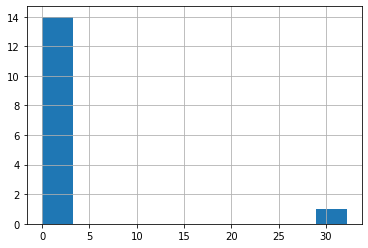

taux de NaN par entrée:


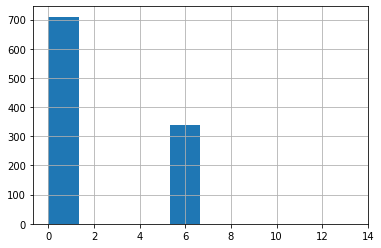

---------------------------------------------
Nb doublons :
0
---------------------------------------------
pour la catégorie : retail_price
--------------------
Max:
 201000.0
min:
 35.0
moy:
 2186.19733079123
med:
 999.0
mod:
 0    999.0
dtype: float64
var:
 58302194.12979243
ect:
 7635.587346746315
skw:
 19.77889735299606
kur:
 473.6948614188438
--------------------


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


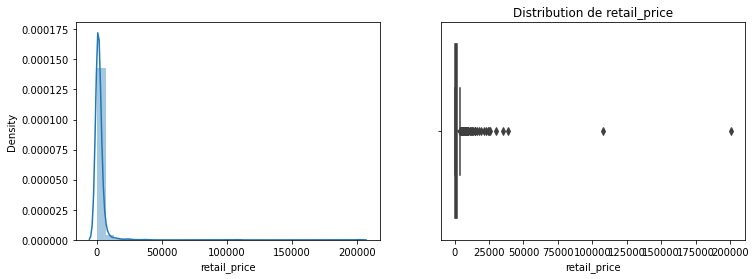

pour la catégorie : discounted_price
--------------------
Max:
 201000.0
min:
 35.0
moy:
 1584.5271687321258
med:
 600.0
mod:
 0    199.0
dtype: float64
var:
 55823848.20159733
ect:
 7471.535866312718
skw:
 21.22227615589593
kur:
 523.3905132118986
--------------------


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


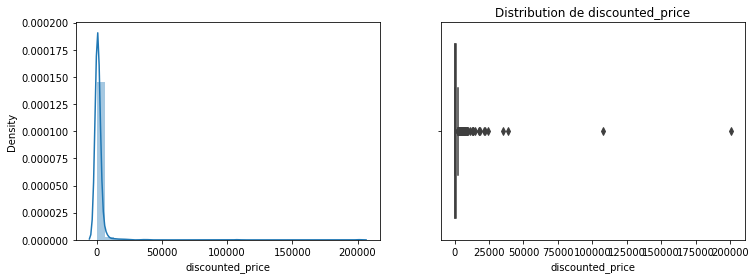

nb entrée unique pour l'indicateur : uniq_id : 
 1050
nb entrée unique pour l'indicateur : crawl_timestamp : 
 149
nb entrée unique pour l'indicateur : product_url : 
 1050
nb entrée unique pour l'indicateur : product_name : 
 1050
nb entrée unique pour l'indicateur : product_category_tree : 
 642
nb entrée unique pour l'indicateur : pid : 
 1050
nb entrée unique pour l'indicateur : retail_price : 
 354
nb entrée unique pour l'indicateur : discounted_price : 
 424
nb entrée unique pour l'indicateur : image : 
 1050
nb entrée unique pour l'indicateur : is_FK_Advantage_product : 
 2
nb entrée unique pour l'indicateur : description : 
 1050
nb entrée unique pour l'indicateur : product_rating : 
 27
nb entrée unique pour l'indicateur : overall_rating : 
 27
nb entrée unique pour l'indicateur : brand : 
 490
nb entrée unique pour l'indicateur : product_specifications : 
 984
---------------------------------------------
-----------------------------------------------------------------------

In [ ]:
explor_set(dic_data)

In [ ]:
### nb de produit :
data['uniq_id'].nunique()

1050

In [ ]:
### Vérification qu'un produit n'apparait pas 2 fois
data['uniq_id'].nunique()-data['product_name'].value_counts().sum()

0

In [ ]:
### plage temporelle :
min_time = data['crawl_timestamp'].min()
max_time = data['crawl_timestamp'].max()
print('De ',min_time, ' à ', max_time)

De  2015-12-01 06:13:00 +0000  à  2016-06-26 14:21:24 +0000


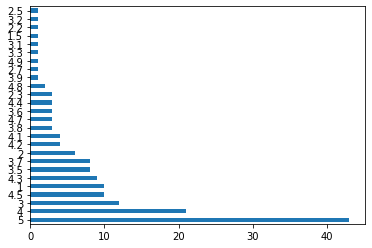

In [ ]:
### Répartition des notes sans les "not availabale"
data[data['product_rating']!='No rating available']['product_rating'].value_counts().plot.barh()

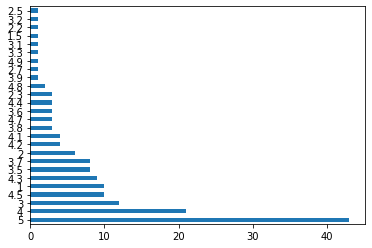

In [ ]:
### Répartition des notes sans les "not availabale"
data[data['overall_rating']!='No rating available']['product_rating'].value_counts().plot.barh()

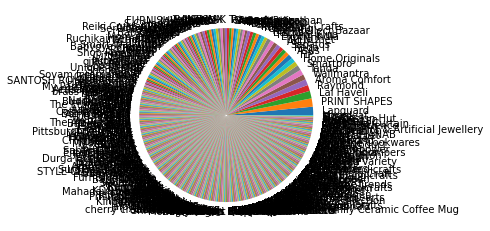

In [ ]:
### Répartition des marques de produit
data['brand'].value_counts().plot.pie()

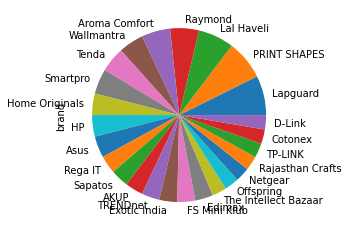

In [ ]:
### Répartition des 25 premières marques
data['brand'].value_counts().head(25).plot.pie()

# Feature engineering

In [ ]:
print(data['product_category_tree'][0])

["Home Furnishing >> Curtains & Accessories >> Curtains >> Elegance Polyester Multicolor Abstract Eyelet Do..."]


In [ ]:
data['product_name'][0]

'Elegance Polyester Multicolor Abstract Eyelet Door Curtain'

In [ ]:
#Extraction des catégories
def split_catego(catego, niv):
    
  catego = catego.split('["')[1].split('"]')[0]
  cat = catego.split(' >> ')

  if(len(cat)) < 3:
    cat = [cat[0], cat[1], 'Nan']
      
    if(len(cat))<2:
      cat = [cat[0], 'Nan', 'Nan']

  return cat[niv]

def catego_1(category):
  return split_catego(category,0)

def catego_2(category):
  return split_catego(category,1)

def catego_3(category):
  return split_catego(category,2)

def tree_category(dataframe):

  dataframe['catego_niv_1'] = dataframe['product_category_tree'].apply(catego_1)
  dataframe['catego_niv_2'] = dataframe['product_category_tree'].apply(catego_2)
  dataframe['catego_niv_3'] = dataframe['product_category_tree'].apply(catego_3)

  return dataframe.drop(['product_category_tree'], axis=1)

In [ ]:
catego_data = tree_category(data)

pour le niveau 1 :
nb de catégories différentes :  7
nb de produits par catégories :  
 Kitchen & Dining              150
Home Furnishing               150
Computers                     150
Watches                       150
Beauty and Personal Care      150
Baby Care                     150
Home Decor & Festive Needs    150
Name: catego_niv_1, dtype: int64


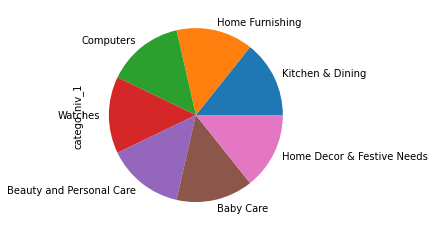

pour le niveau 2 :
nb de catégories différentes :  62
nb de produits par catégories :  
 Wrist Watches                  149
Laptop Accessories              87
Infant Wear                     84
Coffee Mugs                     74
Showpieces                      71
Bed Linen                       65
Fragrances                      65
Network Components              49
Table Decor & Handicrafts       27
Cookware                        27
Combos and Kits                 24
Wall Decor & Clocks             22
Bath Linen                      21
Curtains & Accessories          19
Makeup                          18
Baby & Kids Gifts               15
Baby Bedding                    15
Body and Skin Care              15
Decorative Lighting & Lamps     14
Baby Bath & Skin                14
Kitchen Tools                   14
Kitchen & Dining Linen          14
Cushions, Pillows & Covers      13
Containers & Bottles            13
Hair Care                        9
Name: catego_niv_2, dtype: int64


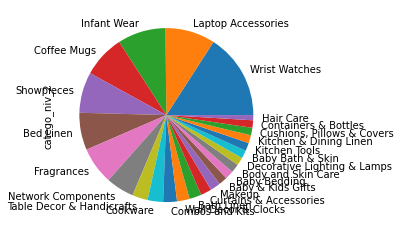

pour le niveau 3 :
nb de catégories différentes :  242
nb de produits par catégories :  
 Deodorants                     65
Blankets, Quilts & Dohars      57
Baby Girls' Clothes            49
Routers                        49
USB Gadgets                    38
Baby Boys' Clothes             35
Ethnic                         34
Prithish Coffee Mugs           26
Pots & Pans                    24
Maxima Wrist Watches           23
Showpieces                     23
Rockmantra Coffee Mugs         22
Batteries                      22
Curtains                       19
Towels                         19
Sonata Wrist Watches           19
Printland Coffee Mugs          13
Kitchen Implements             12
Cushion Covers                 12
Computer Accessories Combos    11
Name: catego_niv_3, dtype: int64


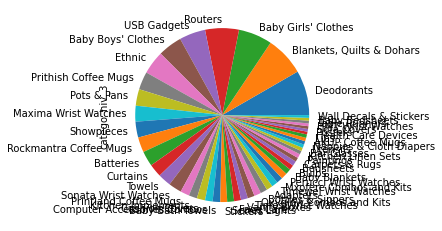

In [ ]:
### Répartition des 25 premières marques
print('pour le niveau 1 :')
print('nb de catégories différentes : ',catego_data['catego_niv_1'].nunique())
print('nb de produits par catégories : ','\n',catego_data['catego_niv_1'].value_counts().head(25))
catego_data['catego_niv_1'].value_counts().head(25).plot.pie()
plt.show()

print('pour le niveau 2 :')
print('nb de catégories différentes : ',catego_data['catego_niv_2'].nunique())
print('nb de produits par catégories : ','\n',catego_data['catego_niv_2'].value_counts().head(25))
catego_data['catego_niv_2'].value_counts().head(25).plot.pie()
plt.show()

print('pour le niveau 3 :')
print('nb de catégories différentes : ',catego_data['catego_niv_3'].nunique())
print('nb de produits par catégories : ','\n',catego_data['catego_niv_3'].value_counts().head(20))
catego_data['catego_niv_3'].value_counts().head(50).plot.pie()
plt.show()

In [ ]:
### Nouvelle feature : % de réduction
catego_data['%_remise']=(catego_data['retail_price']-catego_data['discounted_price'])/catego_data['retail_price']*100

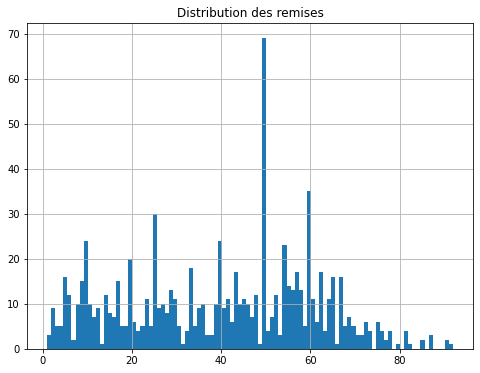

In [ ]:
### Distribution des remises
plt.figure(figsize=(8,6))
plt.title('Distribution des remises',fontsize=12)
catego_data[catego_data['%_remise']!=0]['%_remise'].hist(bins=100)

In [ ]:
### type objet en float
catego_data['product_rating']=catego_data['product_rating'].replace('No rating available',np.NaN).astype(float)
catego_data['overall_rating']=catego_data['overall_rating'].replace('No rating available',np.NaN).astype(float)

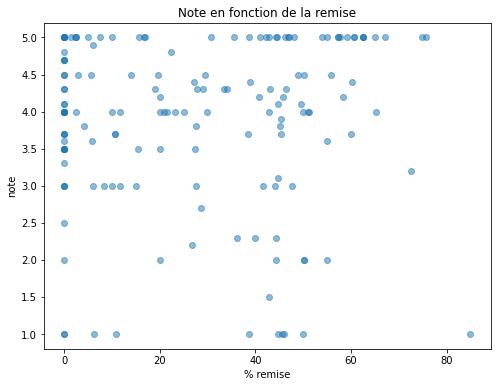

In [ ]:
### note en fonction de la remise
plt.figure(figsize=(8,6))
plt.title('Note en fonction de la remise',fontsize=12)
plt.scatter(x=catego_data['%_remise'],y=catego_data['overall_rating'],alpha=0.5)
plt.xlabel('% remise')
plt.ylabel('note')
plt.show()

In [ ]:
### Drop colonnes inutilisables
catego_data=catego_data.drop('product_specifications',axis = 1)

In [ ]:
### Données temporelles
catego_data['crawl_timestamp'] = pd.to_datetime(catego_data['crawl_timestamp'])

In [ ]:
catego_data['year'] = catego_data['crawl_timestamp'].apply(lambda x: x.year)
catego_data['month'] = catego_data['crawl_timestamp'].apply(lambda x: x.month)
catego_data['day'] = catego_data['crawl_timestamp'].apply(lambda x: x.day)

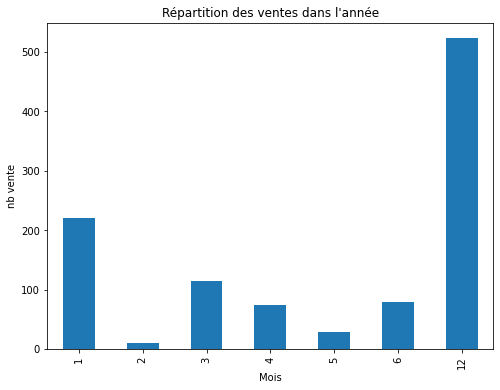

In [ ]:
### Nb de vente par mois
plt.figure(figsize=(8,6))
catego_data.groupby('month')['month'].count().plot(kind='bar')
plt.title('Répartition des ventes dans l\'année',fontsize=12)
plt.xlabel('Mois')
plt.ylabel('nb vente')
plt.show()

In [ ]:
### Nb de vente par année
catego_data['year'].value_counts()

2016    527
2015    523
Name: year, dtype: int64

##Construction du set de travail


In [ ]:
set_encod=catego_data.copy()

# Encodage des catégories
le=LabelEncoder()
set_encod['catego_niv_1']=le.fit_transform(np.array(set_encod['catego_niv_1']))

#### BUG de descripteur avec cette image 
set_encod=set_encod[set_encod['image'] != '9743e6d1c9f3180483825fe4d2e97836.jpg'] 
set_encod=set_encod.reset_index()

In [ ]:
set_stacking=pd.DataFrame()
set_stacking['image']=set_encod['image'].copy()
set_stacking['description']=set_encod['description'].copy()
set_stacking['catego']=set_encod['catego_niv_1'].copy()
set_stacking.head()

image  ... catego
0  55b85ea15a1536d46b7190ad6fff8ce7.jpg  ...      4
1  7b72c92c2f6c40268628ec5f14c6d590.jpg  ...      0
2  64d5d4a258243731dc7bbb1eef49ad74.jpg  ...      0
3  d4684dcdc759dd9cdf41504698d737d8.jpg  ...      4
4  6325b6870c54cd47be6ebfbffa620ec7.jpg  ...      4

[5 rows x 3 columns]

In [ ]:
set_stacking.shape

(1049, 3)

In [ ]:
def split_4(X,Y,train_ratio,val_ratio):
  X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=train_ratio)
  X_val, X_test_stack, y_val, y_test_stack = train_test_split(X_test,y_test, test_size=val_ratio)
  
  set_train=pd.DataFrame(X_train,columns=['image','description'])
  set_train['catego']=y_train
  set_test=pd.DataFrame(X_test,columns=['image','description'])
  set_test['catego']=y_test
  set_val=pd.DataFrame(X_val,columns=['image','description'])
  set_val['catego']=y_val
  set_test_stack=pd.DataFrame(X_test_stack,columns=['image','description'])
  set_test_stack['catego']=y_test_stack
  
  return  set_train, set_test, set_val, set_test_stack

In [ ]:
set_train, set_test, set_val, set_test_stack=split_4(set_stacking.drop('catego',axis=1),set_stacking['catego'],0.3,0.3)

In [ ]:
pickle.dump( set_train, open( "set_train.p", "wb" ) )
pickle.dump( set_test, open( "set_test.p", "wb" ) )
pickle.dump( set_val, open( "set_val.p", "wb" ) )
pickle.dump( set_test_stack, open( "set_test_stack.p", "wb" ) )

In [ ]:
set_train = pickle.load( open( "set_train.p", "rb" ) )
set_test = pickle.load( open( "set_test.p", "rb" ) )
set_val = pickle.load( open( "set_val.p", "rb" ) )
set_test_stack = pickle.load( open( "set_test_stack.p", "rb" ) )

#Classification images

##Traitement d'image

In [ ]:
# Charger l'image
img = Image.open("pictur/55b85ea15a1536d46b7190ad6fff8ce7.jpg") 

# Récupérer et afficher la taille de l'image (en pixels)
w, h = img.size
print("Largeur : {} px, hauteur : {} px".format(w, h))

Largeur : 3600 px, hauteur : 3600 px


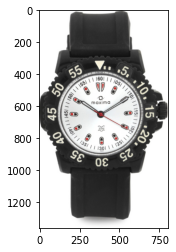

In [ ]:
# Charge l'image comme matrice de pixels
img = np.array(Image.open('pictur//1e15dbd9f59a8b2001f91d18ddc84b5a.jpg'))
plt.imshow(img)

### Niveau de gris

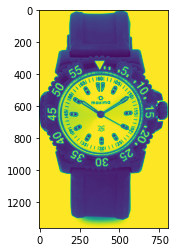

In [ ]:
img_gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
plt.imshow(img_gray)

###Réduction bruit

In [ ]:
img_bruit = gaussian_filter(img_gray, sigma=3)

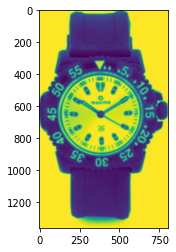

In [ ]:
plt.imshow(img_bruit)

### Contraste (Egaliseur Histo)

In [ ]:
# Générer et afficher l'histogramme
n, bins, patches = plt.hist(img_bruit.flatten(), bins=range(256))
plt.xlabel('niveau de gris')
plt.ylabel('Nb de pixels')
plt.show()

In [ ]:
hist, bins = np.histogram(img_bruit.flatten(), 256, [0,256])
cdf = hist.cumsum()
cdf_normalized = cdf * hist.max() / cdf.max()
plt.figure(figsize=(6,4))
sns.distplot(img_bruit.flatten(),256,[0,256], color = 'r')
plt.xlim([0,256])
plt.show()

In [ ]:
cdf_m = np.ma.masked_equal(cdf,0)
cdf_m = (cdf_m - cdf_m.min())*255/(cdf_m.max()-cdf_m.min())
cdf = np.ma.filled(cdf_m,0).astype('uint8')
im2=cdf[img_bruit]
plt.figure(figsize=(6,4))
sns.distplot(im2.flatten(),256,[0,256], color = 'r')
plt.xlim([0,256])
plt.show()

In [ ]:
img_egal=cv2.equalizeHist(img_bruit)
plt.imshow(img_egal)

In [ ]:
img_siz = cv2.resize(img_egal, dsize=(128,128))
plt.imshow(img_siz)

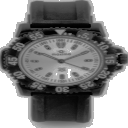

In [ ]:
Image.fromarray(img_siz)

### Fonction traitement image

In [ ]:
def traitement_image(pic):

  img = np.array(Image.open(pic))

  img_gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

  img_bruit = gaussian_filter(img_gray, sigma=3)

  img_egal=cv2.equalizeHist(img_bruit)

  img_siz = cv2.resize(img_egal, dsize=(128,128))

  return img_siz

##Bag Of Visual Word

### Exemple de descripteur

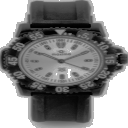

In [ ]:
img_trait= traitement_image('pictur/1e15dbd9f59a8b2001f91d18ddc84b5a.jpg')
Image.fromarray(img_trait)

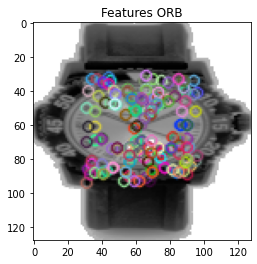

In [ ]:
img_orb= traitement_image('pictur//1e15dbd9f59a8b2001f91d18ddc84b5a.jpg')
orb = cv2.ORB_create()

#find keypoints and descriptors
kp, des = orb.detectAndCompute(img_orb, mask = None)

#draw only keypoints location, not size and orientation:
image_orb = cv2.drawKeypoints(img_orb, kp, outImage = True, flags=2)
plt.title('Features ORB')
plt.imshow(image_orb)
plt.show()

### Extraction des descripteurs

In [ ]:
set_train_img=set_train.copy()
set_test_img=set_test_stack.copy()
set_train_img['image'] = set_train_img['image'].apply(lambda x: 'pictur/'+str(x))
set_test_img['image'] = set_test_img['image'].apply(lambda x: 'pictur/'+str(x))

In [ ]:
def extraction_orb(liste_image):

  list_feat_orb=[]
  list_des_orb=[]

  for i in liste_image:
    
  #Chargement de l'image
    img=cv2.imread(i) #img = np.array(Image.open(pic))
    
  # Traitement image
    img_gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    img_bruit = gaussian_filter(img_gray, sigma=2)
    img_egal = cv2.equalizeHist(img_bruit)
    img_siz = cv2.resize(img, dsize=(128,128))

  #Keypoints et descripteurs (ORB)
    orb = cv2.ORB_create()
    kp, des = orb.detectAndCompute(img, mask = None) 
    list_feat_orb.append(kp)
    list_des_orb.append(des)
  
  #set des descripteurs
  frame_des=np.concatenate(list_des_orb)

  return list_des_orb, frame_des

In [ ]:
list_des_orb_train, frame_des_train = extraction_orb(set_train_img['image'])
list_des_orb_test, frame_des_test = extraction_orb(set_test_img['image'])

###Clustering de descripteurs

In [ ]:
dic_kmeans = {}
list_k=[100, 200, 300, 400]
for i in list_k:
  print(i)

  kmeans = KMeans(n_clusters=i,
                   verbose=1,
                   random_state=0,
                   n_jobs=-1).fit(frame_des_train)

  dic_kmeans[i] = kmeans
  print('OK')

100
OK
200


/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


OK
300


/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


OK
400


/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


OK


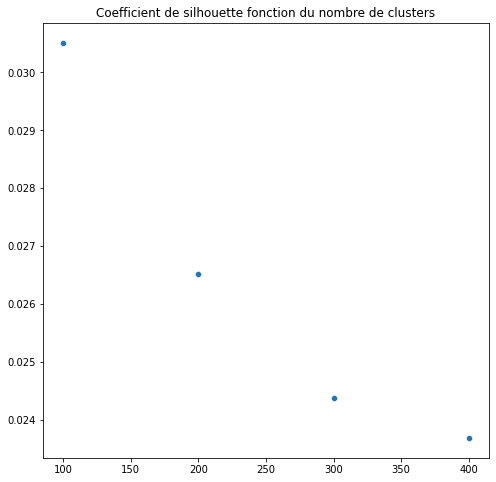

In [ ]:
coef_sil_kmeans = {}
for i in list_k:
    coef_sil_kmeans[i] = silhouette_score(X = frame_des_train, labels= list(dic_kmeans[(i)].labels_))
plt.figure(figsize=(8,8)),
plt.title('Coefficient de silhouette fonction du nombre de clusters')
sns.scatterplot(x = list(coef_sil_kmeans.keys()),y = list(coef_sil_kmeans.values()))
plt.show()

In [ ]:
dump(dic_kmeans, 'dic_kmeans_saved2.joblib') 

['dic_kmeans_saved2.joblib']

In [ ]:
dic_kmeans = load('dic_kmeans_saved2.joblib') 

### Classification RFC

In [ ]:
###Matrice encoder pour chaque image en fonction de ses descripteurs

def matrice_enc (list_orb,dico_kmean,num_k,list_tru_label): 
### liste des ORB
### Dictionnaire de kmeans
### num_k : num clusters
### liste des vrai label

  list_tru_label_index=list_tru_label.copy().reset_index(drop=True)

#Matrice images encodée
  set_kmean=pd.DataFrame(np.zeros((len(list_orb), num_k)))

  for i in range(len(list_orb)):

    num_col=dico_kmean[(num_k)].predict(list_orb[i])
    set_kmean.iloc[i,num_col] += 1

  #Ajout des catégories des images
  set_supervise=set_kmean.copy()
  set_supervise['catego']=list_tru_label_index

  return set_supervise

In [ ]:
#Fonction de classification Random Forest (CV)

def RFclassification(X_train,y_train,X_test,y_test):
   
  # Modélisation RFc

  from sklearn.ensemble import RandomForestClassifier
  from sklearn.model_selection import GridSearchCV
  import sklearn.metrics 

  n_featur = X_train.shape[1]

  param = {
      
      'max_depth' : [10,20,50], #profondeur de l'arbre
      'min_samples_leaf' : [1,3,5], #nombre de feuilles minimales dans un noeud
      'max_features': [n_featur, 'sqrt'] #nombre de features observées pour chaque arbre
      }

  rfr_search = GridSearchCV(RandomForestClassifier(n_estimators=500),
                                param_grid = param,
                                scoring='accuracy',
                                verbose=2,
                                cv=5)

  rfr_search.fit(X_train, y_train)
  print('-'*45)
  print('best parameter :', rfr_search.best_params_)
  print('best score :', rfr_search.best_score_)

  # Prédiction sur le test
  predic_label=rfr_search.predict(X_test)

  rfr_pred=pd.DataFrame()
  rfr_pred['true label']=y_test
  rfr_pred['pred label']=predic_label

  # Matrice de confusion
  from sklearn.metrics import confusion_matrix, accuracy_score 
  import pylab as pl

  def showconfusionmatrix(cm):
      pl.matshow(cm)
      pl.title('Confusion matrix')
      pl.colorbar()
      pl.show()

  accuracy = accuracy_score(y_test, predic_label)
  print("Score accuracy test = ", accuracy)
  cm = confusion_matrix(y_test, predic_label)
  print (cm)

  showconfusionmatrix(cm)
  print('-'*45)

  return rfr_search,accuracy

In [ ]:
#Fonction de classification Random Forest (CV)

def RFclassification_boucle(X_train,y_train,X_test,y_test):
   
  # Modélisation RFR

  from sklearn.ensemble import RandomForestClassifier
  from sklearn.model_selection import GridSearchCV
  import sklearn.metrics 

  list_scor_boucle=[]

  for i in range(1,6,1):

    n_featur = X_train.shape[1]

    param = {
        
        'max_depth' : [10,20,50], #profondeur de l'arbre
        'min_samples_leaf' : [1,3,5], #nombre de feuilles minimales dans un noeud
        'max_features': [n_featur, 'sqrt'] #nombre de features observées pour chaque arbre
        }

    rfr_search = GridSearchCV(RandomForestClassifier(n_estimators=1000),
                                  param_grid = param,
                                  scoring='accuracy',
                                  verbose=2,
                                  cv=5)

    rfr_search.fit(X_train, y_train)
    print('-'*45)
    print('best parameter :', rfr_search.best_params_)
    print('best score :', rfr_search.best_score_)

    # Prédiction sur le test
    predic_label=rfr_search.predict(X_test)

    rfr_pred=pd.DataFrame()
    rfr_pred['true label']=y_test
    rfr_pred['pred label']=predic_label

    # Matrice de confusion
    from sklearn.metrics import confusion_matrix, accuracy_score 
    import pylab as pl

    def showconfusionmatrix(cm):
        pl.matshow(cm)
        pl.title('Confusion matrix')
        pl.colorbar()
        pl.show()

    accuracy = accuracy_score(y_test, predic_label)
    print("Score accuracy test = ", accuracy)
    cm = confusion_matrix(y_test, predic_label)
    print (cm)

    showconfusionmatrix(cm)
    print('-'*45)

    list_scor_boucle.append(accuracy)

  return rfr_search,list_scor_boucle

clustering à k = 100
Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] max_depth=10, max_features=100, min_samples_leaf=1 ..............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=10, max_features=100, min_samples_leaf=1, total=   0.5s
[CV] max_depth=10, max_features=100, min_samples_leaf=1 ..............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV]  max_depth=10, max_features=100, min_samples_leaf=1, total=   0.4s
[CV] max_depth=10, max_features=100, min_samples_leaf=1 ..............
[CV]  max_depth=10, max_features=100, min_samples_leaf=1, total=   0.4s
[CV] max_depth=10, max_features=100, min_samples_leaf=1 ..............
[CV]  max_depth=10, max_features=100, min_samples_leaf=1, total=   0.4s
[CV] max_depth=10, max_features=100, min_samples_leaf=1 ..............
[CV]  max_depth=10, max_features=100, min_samples_leaf=1, total=   0.4s
[CV] max_depth=10, max_features=100, min_samples_leaf=3 ..............
[CV]  max_depth=10, max_features=100, min_samples_leaf=3, total=   0.4s
[CV] max_depth=10, max_features=100, min_samples_leaf=3 ..............
[CV]  max_depth=10, max_features=100, min_samples_leaf=3, total=   0.3s
[CV] max_depth=10, max_features=100, min_samples_leaf=3 ..............
[CV]  max_depth=10, max_features=100, min_samples_leaf=3, total=   0.3s
[CV] max_depth=10, max_features=100, min_samples_leaf=3 ..............

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:   25.2s finished


---------------------------------------------
best parameter : {'max_depth': 20, 'max_features': 100, 'min_samples_leaf': 1}
best score : 0.2806355418879881
Score accuracy test =  0.2736842105263158
[[6 0 3 6 3 2 3]
 [1 1 3 3 1 2 2]
 [2 1 7 1 0 0 1]
 [0 2 3 6 2 0 3]
 [1 1 3 1 3 3 2]
 [0 1 0 1 1 1 2]
 [3 1 0 3 2 0 2]]


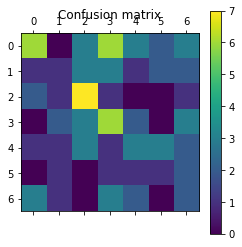

---------------------------------------------
clustering à k = 200
Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] max_depth=10, max_features=200, min_samples_leaf=1 ..............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=10, max_features=200, min_samples_leaf=1, total=   0.9s
[CV] max_depth=10, max_features=200, min_samples_leaf=1 ..............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV]  max_depth=10, max_features=200, min_samples_leaf=1, total=   0.9s
[CV] max_depth=10, max_features=200, min_samples_leaf=1 ..............
[CV]  max_depth=10, max_features=200, min_samples_leaf=1, total=   0.9s
[CV] max_depth=10, max_features=200, min_samples_leaf=1 ..............
[CV]  max_depth=10, max_features=200, min_samples_leaf=1, total=   0.9s
[CV] max_depth=10, max_features=200, min_samples_leaf=1 ..............
[CV]  max_depth=10, max_features=200, min_samples_leaf=1, total=   0.9s
[CV] max_depth=10, max_features=200, min_samples_leaf=3 ..............
[CV]  max_depth=10, max_features=200, min_samples_leaf=3, total=   0.7s
[CV] max_depth=10, max_features=200, min_samples_leaf=3 ..............
[CV]  max_depth=10, max_features=200, min_samples_leaf=3, total=   0.7s
[CV] max_depth=10, max_features=200, min_samples_leaf=3 ..............
[CV]  max_depth=10, max_features=200, min_samples_leaf=3, total=   0.7s
[CV] max_depth=10, max_features=200, min_samples_leaf=3 ..............

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:   42.8s finished


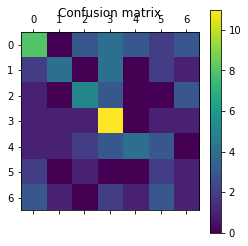

---------------------------------------------
clustering à k = 300
Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] max_depth=10, max_features=300, min_samples_leaf=1 ..............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=10, max_features=300, min_samples_leaf=1, total=   1.4s
[CV] max_depth=10, max_features=300, min_samples_leaf=1 ..............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s


[CV]  max_depth=10, max_features=300, min_samples_leaf=1, total=   1.4s
[CV] max_depth=10, max_features=300, min_samples_leaf=1 ..............
[CV]  max_depth=10, max_features=300, min_samples_leaf=1, total=   1.4s
[CV] max_depth=10, max_features=300, min_samples_leaf=1 ..............
[CV]  max_depth=10, max_features=300, min_samples_leaf=1, total=   1.4s
[CV] max_depth=10, max_features=300, min_samples_leaf=1 ..............
[CV]  max_depth=10, max_features=300, min_samples_leaf=1, total=   1.4s
[CV] max_depth=10, max_features=300, min_samples_leaf=3 ..............
[CV]  max_depth=10, max_features=300, min_samples_leaf=3, total=   1.1s
[CV] max_depth=10, max_features=300, min_samples_leaf=3 ..............
[CV]  max_depth=10, max_features=300, min_samples_leaf=3, total=   1.1s
[CV] max_depth=10, max_features=300, min_samples_leaf=3 ..............
[CV]  max_depth=10, max_features=300, min_samples_leaf=3, total=   1.1s
[CV] max_depth=10, max_features=300, min_samples_leaf=3 ..............

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:  1.0min finished


---------------------------------------------
best parameter : {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 3}
best score : 0.3391948560246017
Score accuracy test =  0.3263157894736842
[[5 0 4 4 4 1 5]
 [4 4 1 2 0 1 1]
 [1 1 6 2 0 0 2]
 [1 1 3 8 3 0 0]
 [3 2 1 5 3 0 0]
 [3 1 0 0 0 1 1]
 [1 3 0 1 2 0 4]]


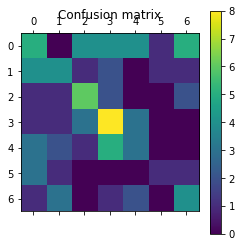

---------------------------------------------
clustering à k = 400
Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] max_depth=10, max_features=400, min_samples_leaf=1 ..............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=10, max_features=400, min_samples_leaf=1, total=   1.9s
[CV] max_depth=10, max_features=400, min_samples_leaf=1 ..............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s


[CV]  max_depth=10, max_features=400, min_samples_leaf=1, total=   1.8s
[CV] max_depth=10, max_features=400, min_samples_leaf=1 ..............
[CV]  max_depth=10, max_features=400, min_samples_leaf=1, total=   1.8s
[CV] max_depth=10, max_features=400, min_samples_leaf=1 ..............
[CV]  max_depth=10, max_features=400, min_samples_leaf=1, total=   1.8s
[CV] max_depth=10, max_features=400, min_samples_leaf=1 ..............
[CV]  max_depth=10, max_features=400, min_samples_leaf=1, total=   1.8s
[CV] max_depth=10, max_features=400, min_samples_leaf=3 ..............
[CV]  max_depth=10, max_features=400, min_samples_leaf=3, total=   1.5s
[CV] max_depth=10, max_features=400, min_samples_leaf=3 ..............
[CV]  max_depth=10, max_features=400, min_samples_leaf=3, total=   1.5s
[CV] max_depth=10, max_features=400, min_samples_leaf=3 ..............
[CV]  max_depth=10, max_features=400, min_samples_leaf=3, total=   1.5s
[CV] max_depth=10, max_features=400, min_samples_leaf=3 ..............

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:  1.3min finished


---------------------------------------------
best parameter : {'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 1}
best score : 0.32832913987512813
Score accuracy test =  0.3263157894736842
[[7 2 3 3 3 3 2]
 [2 4 0 2 2 1 2]
 [1 2 6 1 0 1 1]
 [0 3 1 8 0 3 1]
 [4 1 1 4 1 3 0]
 [1 0 0 1 0 2 2]
 [1 1 1 2 1 2 3]]


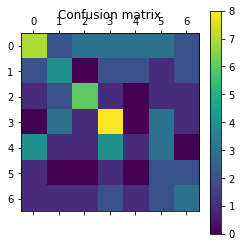

---------------------------------------------


k  accuracy_score
0  100        0.273684
1  200        0.368421
2  300        0.326316
3  400        0.326316

In [ ]:
list_rfc_accuracy=[]
list_k=[100, 200, 300, 400]

for k in list_k:
  print ('clustering à k =', k)
  
  # Encodage
  set_supervise_train= matrice_enc (list_des_orb_train, dic_kmeans,k,set_train_img['catego'])
  set_supervise_test= matrice_enc (list_des_orb_test, dic_kmeans,k,set_test_img['catego'])
  
  # RF classification
  rfc_search_orb,accuracy_orb= RFclassification(set_supervise_train.drop('catego',axis=1),
                                       set_supervise_train['catego'],
                                       set_supervise_test.drop('catego',axis=1),
                                       set_supervise_test['catego'])

  # Récupération du score
  list_rfc_accuracy.append(accuracy_orb)

result_nonsup=pd.DataFrame()
result_nonsup['k']=list_k
result_nonsup['accuracy_score']=list_rfc_accuracy
result_nonsup

clustering à k = 100
Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] max_depth=10, max_features=100, min_samples_leaf=1 ..............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=10, max_features=100, min_samples_leaf=1, total=   0.4s
[CV] max_depth=10, max_features=100, min_samples_leaf=1 ..............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV]  max_depth=10, max_features=100, min_samples_leaf=1, total=   0.4s
[CV] max_depth=10, max_features=100, min_samples_leaf=1 ..............
[CV]  max_depth=10, max_features=100, min_samples_leaf=1, total=   0.4s
[CV] max_depth=10, max_features=100, min_samples_leaf=1 ..............
[CV]  max_depth=10, max_features=100, min_samples_leaf=1, total=   0.4s
[CV] max_depth=10, max_features=100, min_samples_leaf=1 ..............
[CV]  max_depth=10, max_features=100, min_samples_leaf=1, total=   0.4s
[CV] max_depth=10, max_features=100, min_samples_leaf=3 ..............
[CV]  max_depth=10, max_features=100, min_samples_leaf=3, total=   0.3s
[CV] max_depth=10, max_features=100, min_samples_leaf=3 ..............
[CV]  max_depth=10, max_features=100, min_samples_leaf=3, total=   0.3s
[CV] max_depth=10, max_features=100, min_samples_leaf=3 ..............
[CV]  max_depth=10, max_features=100, min_samples_leaf=3, total=   0.3s
[CV] max_depth=10, max_features=100, min_samples_leaf=3 ..............

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:   25.2s finished


---------------------------------------------
best parameter : {'max_depth': 50, 'max_features': 100, 'min_samples_leaf': 3}
best score : 0.28469853694902614
Score accuracy test =  0.2631578947368421
[[4 2 2 6 3 3 3]
 [1 2 3 4 0 2 1]
 [2 1 7 1 0 0 1]
 [1 0 3 7 3 0 2]
 [4 1 2 1 3 2 1]
 [2 0 1 1 0 0 2]
 [4 1 0 1 2 1 2]]


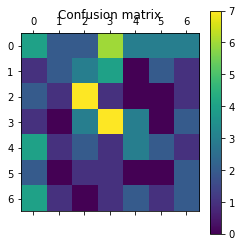

---------------------------------------------
Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] max_depth=10, max_features=100, min_samples_leaf=1 ..............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=10, max_features=100, min_samples_leaf=1, total=   0.4s
[CV] max_depth=10, max_features=100, min_samples_leaf=1 ..............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV]  max_depth=10, max_features=100, min_samples_leaf=1, total=   0.4s
[CV] max_depth=10, max_features=100, min_samples_leaf=1 ..............
[CV]  max_depth=10, max_features=100, min_samples_leaf=1, total=   0.4s
[CV] max_depth=10, max_features=100, min_samples_leaf=1 ..............
[CV]  max_depth=10, max_features=100, min_samples_leaf=1, total=   0.4s
[CV] max_depth=10, max_features=100, min_samples_leaf=1 ..............
[CV]  max_depth=10, max_features=100, min_samples_leaf=1, total=   0.4s
[CV] max_depth=10, max_features=100, min_samples_leaf=3 ..............
[CV]  max_depth=10, max_features=100, min_samples_leaf=3, total=   0.4s
[CV] max_depth=10, max_features=100, min_samples_leaf=3 ..............
[CV]  max_depth=10, max_features=100, min_samples_leaf=3, total=   0.3s
[CV] max_depth=10, max_features=100, min_samples_leaf=3 ..............
[CV]  max_depth=10, max_features=100, min_samples_leaf=3, total=   0.4s
[CV] max_depth=10, max_features=100, min_samples_leaf=3 ..............

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:   25.4s finished


---------------------------------------------
best parameter : {'max_depth': 10, 'max_features': 100, 'min_samples_leaf': 1}
best score : 0.2765352716429037
Score accuracy test =  0.25263157894736843
[[6 1 3 5 1 4 3]
 [2 2 1 3 1 1 3]
 [3 1 6 1 0 0 1]
 [1 0 4 5 5 1 0]
 [3 0 2 2 3 1 3]
 [1 1 1 1 0 0 2]
 [3 0 1 1 4 0 2]]


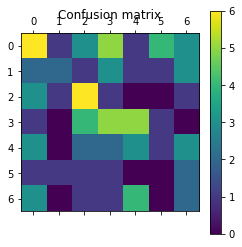

---------------------------------------------
Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] max_depth=10, max_features=100, min_samples_leaf=1 ..............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=10, max_features=100, min_samples_leaf=1, total=   0.4s
[CV] max_depth=10, max_features=100, min_samples_leaf=1 ..............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV]  max_depth=10, max_features=100, min_samples_leaf=1, total=   0.4s
[CV] max_depth=10, max_features=100, min_samples_leaf=1 ..............
[CV]  max_depth=10, max_features=100, min_samples_leaf=1, total=   0.4s
[CV] max_depth=10, max_features=100, min_samples_leaf=1 ..............
[CV]  max_depth=10, max_features=100, min_samples_leaf=1, total=   0.4s
[CV] max_depth=10, max_features=100, min_samples_leaf=1 ..............
[CV]  max_depth=10, max_features=100, min_samples_leaf=1, total=   0.4s
[CV] max_depth=10, max_features=100, min_samples_leaf=3 ..............
[CV]  max_depth=10, max_features=100, min_samples_leaf=3, total=   0.3s
[CV] max_depth=10, max_features=100, min_samples_leaf=3 ..............
[CV]  max_depth=10, max_features=100, min_samples_leaf=3, total=   0.4s
[CV] max_depth=10, max_features=100, min_samples_leaf=3 ..............
[CV]  max_depth=10, max_features=100, min_samples_leaf=3, total=   0.3s
[CV] max_depth=10, max_features=100, min_samples_leaf=3 ..............

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:   25.3s finished


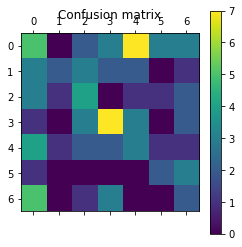

---------------------------------------------
Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] max_depth=10, max_features=100, min_samples_leaf=1 ..............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=10, max_features=100, min_samples_leaf=1, total=   0.4s
[CV] max_depth=10, max_features=100, min_samples_leaf=1 ..............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV]  max_depth=10, max_features=100, min_samples_leaf=1, total=   0.4s
[CV] max_depth=10, max_features=100, min_samples_leaf=1 ..............
[CV]  max_depth=10, max_features=100, min_samples_leaf=1, total=   0.4s
[CV] max_depth=10, max_features=100, min_samples_leaf=1 ..............
[CV]  max_depth=10, max_features=100, min_samples_leaf=1, total=   0.4s
[CV] max_depth=10, max_features=100, min_samples_leaf=1 ..............
[CV]  max_depth=10, max_features=100, min_samples_leaf=1, total=   0.4s
[CV] max_depth=10, max_features=100, min_samples_leaf=3 ..............
[CV]  max_depth=10, max_features=100, min_samples_leaf=3, total=   0.4s
[CV] max_depth=10, max_features=100, min_samples_leaf=3 ..............
[CV]  max_depth=10, max_features=100, min_samples_leaf=3, total=   0.4s
[CV] max_depth=10, max_features=100, min_samples_leaf=3 ..............
[CV]  max_depth=10, max_features=100, min_samples_leaf=3, total=   0.3s
[CV] max_depth=10, max_features=100, min_samples_leaf=3 ..............

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:   25.3s finished


---------------------------------------------
best parameter : {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 3}
best score : 0.2806075854999534
Score accuracy test =  0.29473684210526313
[[6 0 3 6 2 3 3]
 [0 2 3 3 1 1 3]
 [2 1 7 2 0 0 0]
 [0 1 3 6 3 1 2]
 [3 1 2 4 2 1 1]
 [0 1 0 0 1 2 2]
 [4 0 0 2 2 0 3]]


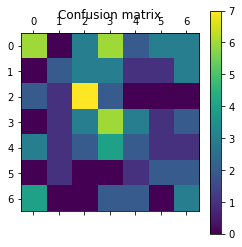

---------------------------------------------
Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] max_depth=10, max_features=100, min_samples_leaf=1 ..............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=10, max_features=100, min_samples_leaf=1, total=   0.4s
[CV] max_depth=10, max_features=100, min_samples_leaf=1 ..............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV]  max_depth=10, max_features=100, min_samples_leaf=1, total=   0.4s
[CV] max_depth=10, max_features=100, min_samples_leaf=1 ..............
[CV]  max_depth=10, max_features=100, min_samples_leaf=1, total=   0.4s
[CV] max_depth=10, max_features=100, min_samples_leaf=1 ..............
[CV]  max_depth=10, max_features=100, min_samples_leaf=1, total=   0.4s
[CV] max_depth=10, max_features=100, min_samples_leaf=1 ..............
[CV]  max_depth=10, max_features=100, min_samples_leaf=1, total=   0.4s
[CV] max_depth=10, max_features=100, min_samples_leaf=3 ..............
[CV]  max_depth=10, max_features=100, min_samples_leaf=3, total=   0.4s
[CV] max_depth=10, max_features=100, min_samples_leaf=3 ..............
[CV]  max_depth=10, max_features=100, min_samples_leaf=3, total=   0.4s
[CV] max_depth=10, max_features=100, min_samples_leaf=3 ..............
[CV]  max_depth=10, max_features=100, min_samples_leaf=3, total=   0.3s
[CV] max_depth=10, max_features=100, min_samples_leaf=3 ..............

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:   25.4s finished


---------------------------------------------
best parameter : {'max_depth': 50, 'max_features': 100, 'min_samples_leaf': 5}
best score : 0.2779517286366602
Score accuracy test =  0.29473684210526313
[[5 2 2 5 5 2 2]
 [1 2 3 2 1 2 2]
 [2 1 7 1 0 0 1]
 [1 0 4 8 1 1 1]
 [5 0 3 0 3 1 2]
 [1 1 0 1 1 1 1]
 [2 0 1 1 5 0 2]]


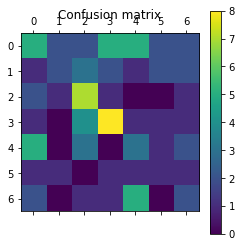

---------------------------------------------
clustering à k = 200
Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] max_depth=10, max_features=200, min_samples_leaf=1 ..............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=10, max_features=200, min_samples_leaf=1, total=   0.9s
[CV] max_depth=10, max_features=200, min_samples_leaf=1 ..............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV]  max_depth=10, max_features=200, min_samples_leaf=1, total=   0.9s
[CV] max_depth=10, max_features=200, min_samples_leaf=1 ..............
[CV]  max_depth=10, max_features=200, min_samples_leaf=1, total=   0.9s
[CV] max_depth=10, max_features=200, min_samples_leaf=1 ..............
[CV]  max_depth=10, max_features=200, min_samples_leaf=1, total=   0.9s
[CV] max_depth=10, max_features=200, min_samples_leaf=1 ..............
[CV]  max_depth=10, max_features=200, min_samples_leaf=1, total=   0.9s
[CV] max_depth=10, max_features=200, min_samples_leaf=3 ..............
[CV]  max_depth=10, max_features=200, min_samples_leaf=3, total=   0.7s
[CV] max_depth=10, max_features=200, min_samples_leaf=3 ..............
[CV]  max_depth=10, max_features=200, min_samples_leaf=3, total=   0.7s
[CV] max_depth=10, max_features=200, min_samples_leaf=3 ..............
[CV]  max_depth=10, max_features=200, min_samples_leaf=3, total=   0.7s
[CV] max_depth=10, max_features=200, min_samples_leaf=3 ..............

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:   43.4s finished


---------------------------------------------
best parameter : {'max_depth': 50, 'max_features': 200, 'min_samples_leaf': 3}
best score : 0.31067002143323086
Score accuracy test =  0.2631578947368421
[[4 2 3 2 4 2 6]
 [0 4 4 1 1 1 2]
 [2 1 5 1 0 1 2]
 [0 5 2 5 1 2 1]
 [1 3 2 1 3 3 1]
 [1 0 0 1 1 1 2]
 [2 2 0 1 3 0 3]]


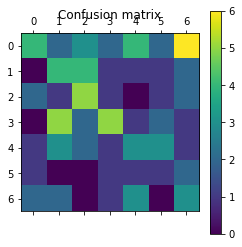

---------------------------------------------
Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] max_depth=10, max_features=200, min_samples_leaf=1 ..............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=10, max_features=200, min_samples_leaf=1, total=   0.9s
[CV] max_depth=10, max_features=200, min_samples_leaf=1 ..............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV]  max_depth=10, max_features=200, min_samples_leaf=1, total=   0.9s
[CV] max_depth=10, max_features=200, min_samples_leaf=1 ..............
[CV]  max_depth=10, max_features=200, min_samples_leaf=1, total=   0.9s
[CV] max_depth=10, max_features=200, min_samples_leaf=1 ..............
[CV]  max_depth=10, max_features=200, min_samples_leaf=1, total=   0.9s
[CV] max_depth=10, max_features=200, min_samples_leaf=1 ..............
[CV]  max_depth=10, max_features=200, min_samples_leaf=1, total=   0.9s
[CV] max_depth=10, max_features=200, min_samples_leaf=3 ..............
[CV]  max_depth=10, max_features=200, min_samples_leaf=3, total=   0.7s
[CV] max_depth=10, max_features=200, min_samples_leaf=3 ..............
[CV]  max_depth=10, max_features=200, min_samples_leaf=3, total=   0.7s
[CV] max_depth=10, max_features=200, min_samples_leaf=3 ..............
[CV]  max_depth=10, max_features=200, min_samples_leaf=3, total=   0.7s
[CV] max_depth=10, max_features=200, min_samples_leaf=3 ..............

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:   43.1s finished


---------------------------------------------
best parameter : {'max_depth': 20, 'max_features': 200, 'min_samples_leaf': 3}
best score : 0.31744478613363153
Score accuracy test =  0.2631578947368421
[[5 1 3 4 1 5 4]
 [1 2 2 1 2 3 2]
 [5 0 4 1 0 0 2]
 [1 3 1 6 1 2 2]
 [4 1 2 2 3 2 0]
 [1 1 0 1 0 2 1]
 [2 1 2 1 1 1 3]]


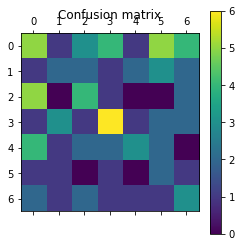

---------------------------------------------
Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] max_depth=10, max_features=200, min_samples_leaf=1 ..............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=10, max_features=200, min_samples_leaf=1, total=   0.9s
[CV] max_depth=10, max_features=200, min_samples_leaf=1 ..............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV]  max_depth=10, max_features=200, min_samples_leaf=1, total=   0.9s
[CV] max_depth=10, max_features=200, min_samples_leaf=1 ..............
[CV]  max_depth=10, max_features=200, min_samples_leaf=1, total=   0.9s
[CV] max_depth=10, max_features=200, min_samples_leaf=1 ..............
[CV]  max_depth=10, max_features=200, min_samples_leaf=1, total=   0.9s
[CV] max_depth=10, max_features=200, min_samples_leaf=1 ..............
[CV]  max_depth=10, max_features=200, min_samples_leaf=1, total=   0.9s
[CV] max_depth=10, max_features=200, min_samples_leaf=3 ..............
[CV]  max_depth=10, max_features=200, min_samples_leaf=3, total=   0.7s
[CV] max_depth=10, max_features=200, min_samples_leaf=3 ..............
[CV]  max_depth=10, max_features=200, min_samples_leaf=3, total=   0.7s
[CV] max_depth=10, max_features=200, min_samples_leaf=3 ..............
[CV]  max_depth=10, max_features=200, min_samples_leaf=3, total=   0.7s
[CV] max_depth=10, max_features=200, min_samples_leaf=3 ..............

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:   43.1s finished


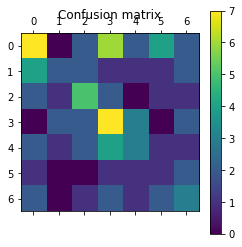

---------------------------------------------
Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] max_depth=10, max_features=200, min_samples_leaf=1 ..............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=10, max_features=200, min_samples_leaf=1, total=   0.9s
[CV] max_depth=10, max_features=200, min_samples_leaf=1 ..............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV]  max_depth=10, max_features=200, min_samples_leaf=1, total=   0.9s
[CV] max_depth=10, max_features=200, min_samples_leaf=1 ..............
[CV]  max_depth=10, max_features=200, min_samples_leaf=1, total=   0.9s
[CV] max_depth=10, max_features=200, min_samples_leaf=1 ..............
[CV]  max_depth=10, max_features=200, min_samples_leaf=1, total=   0.9s
[CV] max_depth=10, max_features=200, min_samples_leaf=1 ..............
[CV]  max_depth=10, max_features=200, min_samples_leaf=1, total=   0.9s
[CV] max_depth=10, max_features=200, min_samples_leaf=3 ..............
[CV]  max_depth=10, max_features=200, min_samples_leaf=3, total=   0.7s
[CV] max_depth=10, max_features=200, min_samples_leaf=3 ..............
[CV]  max_depth=10, max_features=200, min_samples_leaf=3, total=   0.7s
[CV] max_depth=10, max_features=200, min_samples_leaf=3 ..............
[CV]  max_depth=10, max_features=200, min_samples_leaf=3, total=   0.7s
[CV] max_depth=10, max_features=200, min_samples_leaf=3 ..............

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:   43.2s finished


---------------------------------------------
best parameter : {'max_depth': 20, 'max_features': 200, 'min_samples_leaf': 1}
best score : 0.32288696300437986
Score accuracy test =  0.2631578947368421
[[5 0 3 3 3 4 5]
 [4 1 2 1 1 3 1]
 [3 0 4 2 0 1 2]
 [0 5 2 7 0 0 2]
 [3 2 2 1 3 3 0]
 [0 1 0 1 0 2 2]
 [1 1 1 1 3 1 3]]


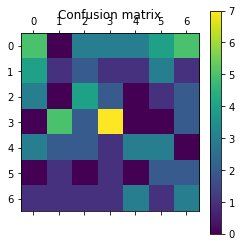

---------------------------------------------
Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] max_depth=10, max_features=200, min_samples_leaf=1 ..............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=10, max_features=200, min_samples_leaf=1, total=   0.9s
[CV] max_depth=10, max_features=200, min_samples_leaf=1 ..............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV]  max_depth=10, max_features=200, min_samples_leaf=1, total=   0.9s
[CV] max_depth=10, max_features=200, min_samples_leaf=1 ..............
[CV]  max_depth=10, max_features=200, min_samples_leaf=1, total=   0.9s
[CV] max_depth=10, max_features=200, min_samples_leaf=1 ..............
[CV]  max_depth=10, max_features=200, min_samples_leaf=1, total=   0.9s
[CV] max_depth=10, max_features=200, min_samples_leaf=1 ..............
[CV]  max_depth=10, max_features=200, min_samples_leaf=1, total=   0.9s
[CV] max_depth=10, max_features=200, min_samples_leaf=3 ..............
[CV]  max_depth=10, max_features=200, min_samples_leaf=3, total=   0.7s
[CV] max_depth=10, max_features=200, min_samples_leaf=3 ..............
[CV]  max_depth=10, max_features=200, min_samples_leaf=3, total=   0.7s
[CV] max_depth=10, max_features=200, min_samples_leaf=3 ..............
[CV]  max_depth=10, max_features=200, min_samples_leaf=3, total=   0.7s
[CV] max_depth=10, max_features=200, min_samples_leaf=3 ..............

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:   43.0s finished


---------------------------------------------
best parameter : {'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 1}
best score : 0.31467710371819957
Score accuracy test =  0.29473684210526313
[[6 0 2 4 4 4 3]
 [2 2 3 1 0 2 3]
 [4 0 4 3 0 0 1]
 [0 2 1 8 1 2 2]
 [3 2 2 2 5 0 0]
 [1 0 0 1 0 1 3]
 [1 2 0 1 2 3 2]]


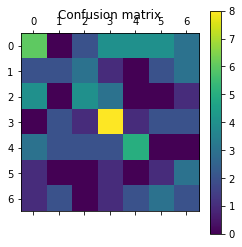

---------------------------------------------
clustering à k = 300
Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] max_depth=10, max_features=300, min_samples_leaf=1 ..............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=10, max_features=300, min_samples_leaf=1, total=   1.4s
[CV] max_depth=10, max_features=300, min_samples_leaf=1 ..............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s


[CV]  max_depth=10, max_features=300, min_samples_leaf=1, total=   1.4s
[CV] max_depth=10, max_features=300, min_samples_leaf=1 ..............
[CV]  max_depth=10, max_features=300, min_samples_leaf=1, total=   1.4s
[CV] max_depth=10, max_features=300, min_samples_leaf=1 ..............
[CV]  max_depth=10, max_features=300, min_samples_leaf=1, total=   1.4s
[CV] max_depth=10, max_features=300, min_samples_leaf=1 ..............
[CV]  max_depth=10, max_features=300, min_samples_leaf=1, total=   1.3s
[CV] max_depth=10, max_features=300, min_samples_leaf=3 ..............
[CV]  max_depth=10, max_features=300, min_samples_leaf=3, total=   1.1s
[CV] max_depth=10, max_features=300, min_samples_leaf=3 ..............
[CV]  max_depth=10, max_features=300, min_samples_leaf=3, total=   1.1s
[CV] max_depth=10, max_features=300, min_samples_leaf=3 ..............
[CV]  max_depth=10, max_features=300, min_samples_leaf=3, total=   1.1s
[CV] max_depth=10, max_features=300, min_samples_leaf=3 ..............

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:  1.0min finished


---------------------------------------------
best parameter : {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 5}
best score : 0.3459789395210139
Score accuracy test =  0.3263157894736842
[[3 1 4 5 3 2 5]
 [4 3 0 3 2 0 1]
 [1 0 7 1 1 0 2]
 [0 2 1 9 2 1 1]
 [3 1 1 4 4 1 0]
 [1 1 0 1 0 1 2]
 [2 1 0 2 2 0 4]]


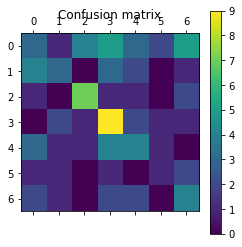

---------------------------------------------
Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] max_depth=10, max_features=300, min_samples_leaf=1 ..............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=10, max_features=300, min_samples_leaf=1, total=   1.4s
[CV] max_depth=10, max_features=300, min_samples_leaf=1 ..............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s


[CV]  max_depth=10, max_features=300, min_samples_leaf=1, total=   1.4s
[CV] max_depth=10, max_features=300, min_samples_leaf=1 ..............
[CV]  max_depth=10, max_features=300, min_samples_leaf=1, total=   1.4s
[CV] max_depth=10, max_features=300, min_samples_leaf=1 ..............
[CV]  max_depth=10, max_features=300, min_samples_leaf=1, total=   1.4s
[CV] max_depth=10, max_features=300, min_samples_leaf=1 ..............
[CV]  max_depth=10, max_features=300, min_samples_leaf=1, total=   1.4s
[CV] max_depth=10, max_features=300, min_samples_leaf=3 ..............
[CV]  max_depth=10, max_features=300, min_samples_leaf=3, total=   1.1s
[CV] max_depth=10, max_features=300, min_samples_leaf=3 ..............
[CV]  max_depth=10, max_features=300, min_samples_leaf=3, total=   1.1s
[CV] max_depth=10, max_features=300, min_samples_leaf=3 ..............
[CV]  max_depth=10, max_features=300, min_samples_leaf=3, total=   1.1s
[CV] max_depth=10, max_features=300, min_samples_leaf=3 ..............

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:  1.0min finished


---------------------------------------------
best parameter : {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 5}
best score : 0.3282452707110241
Score accuracy test =  0.29473684210526313
[[5 2 4 3 4 1 4]
 [3 3 2 1 0 1 3]
 [1 0 6 1 0 3 1]
 [0 3 1 9 0 2 1]
 [4 1 2 4 2 1 0]
 [2 1 1 0 0 1 1]
 [1 2 0 1 2 3 2]]


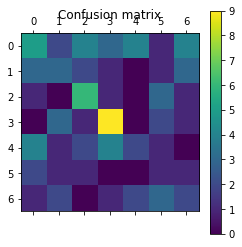

---------------------------------------------
Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] max_depth=10, max_features=300, min_samples_leaf=1 ..............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=10, max_features=300, min_samples_leaf=1, total=   1.4s
[CV] max_depth=10, max_features=300, min_samples_leaf=1 ..............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s


[CV]  max_depth=10, max_features=300, min_samples_leaf=1, total=   1.4s
[CV] max_depth=10, max_features=300, min_samples_leaf=1 ..............
[CV]  max_depth=10, max_features=300, min_samples_leaf=1, total=   1.4s
[CV] max_depth=10, max_features=300, min_samples_leaf=1 ..............
[CV]  max_depth=10, max_features=300, min_samples_leaf=1, total=   1.4s
[CV] max_depth=10, max_features=300, min_samples_leaf=1 ..............
[CV]  max_depth=10, max_features=300, min_samples_leaf=1, total=   1.4s
[CV] max_depth=10, max_features=300, min_samples_leaf=3 ..............
[CV]  max_depth=10, max_features=300, min_samples_leaf=3, total=   1.1s
[CV] max_depth=10, max_features=300, min_samples_leaf=3 ..............
[CV]  max_depth=10, max_features=300, min_samples_leaf=3, total=   1.1s
[CV] max_depth=10, max_features=300, min_samples_leaf=3 ..............
[CV]  max_depth=10, max_features=300, min_samples_leaf=3, total=   1.1s
[CV] max_depth=10, max_features=300, min_samples_leaf=3 ..............

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:  1.0min finished


---------------------------------------------
best parameter : {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1}
best score : 0.35147702916783147
Score accuracy test =  0.24210526315789474
[[3 1 2 0 5 6 6]
 [3 2 0 4 0 1 3]
 [1 1 5 2 0 0 3]
 [2 2 1 7 2 1 1]
 [1 0 3 6 3 0 1]
 [0 1 0 0 1 2 2]
 [3 3 0 2 2 0 1]]


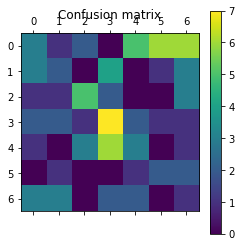

---------------------------------------------
Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] max_depth=10, max_features=300, min_samples_leaf=1 ..............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=10, max_features=300, min_samples_leaf=1, total=   1.4s
[CV] max_depth=10, max_features=300, min_samples_leaf=1 ..............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s


[CV]  max_depth=10, max_features=300, min_samples_leaf=1, total=   1.4s
[CV] max_depth=10, max_features=300, min_samples_leaf=1 ..............
[CV]  max_depth=10, max_features=300, min_samples_leaf=1, total=   1.4s
[CV] max_depth=10, max_features=300, min_samples_leaf=1 ..............
[CV]  max_depth=10, max_features=300, min_samples_leaf=1, total=   1.4s
[CV] max_depth=10, max_features=300, min_samples_leaf=1 ..............
[CV]  max_depth=10, max_features=300, min_samples_leaf=1, total=   1.4s
[CV] max_depth=10, max_features=300, min_samples_leaf=3 ..............
[CV]  max_depth=10, max_features=300, min_samples_leaf=3, total=   1.1s
[CV] max_depth=10, max_features=300, min_samples_leaf=3 ..............
[CV]  max_depth=10, max_features=300, min_samples_leaf=3, total=   1.1s
[CV] max_depth=10, max_features=300, min_samples_leaf=3 ..............
[CV]  max_depth=10, max_features=300, min_samples_leaf=3, total=   1.1s
[CV] max_depth=10, max_features=300, min_samples_leaf=3 ..............

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:  1.0min finished


---------------------------------------------
best parameter : {'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 5}
best score : 0.3378529493989376
Score accuracy test =  0.43157894736842106
[[9 0 3 4 3 2 2]
 [5 6 1 0 0 0 1]
 [2 0 6 2 1 0 1]
 [1 3 1 9 1 1 0]
 [3 1 1 2 6 1 0]
 [1 1 0 0 1 1 2]
 [2 2 0 2 0 1 4]]


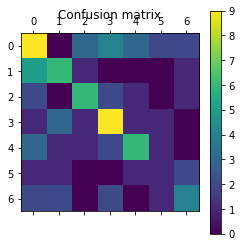

---------------------------------------------
Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] max_depth=10, max_features=300, min_samples_leaf=1 ..............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=10, max_features=300, min_samples_leaf=1, total=   1.4s
[CV] max_depth=10, max_features=300, min_samples_leaf=1 ..............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s


[CV]  max_depth=10, max_features=300, min_samples_leaf=1, total=   1.4s
[CV] max_depth=10, max_features=300, min_samples_leaf=1 ..............
[CV]  max_depth=10, max_features=300, min_samples_leaf=1, total=   1.4s
[CV] max_depth=10, max_features=300, min_samples_leaf=1 ..............
[CV]  max_depth=10, max_features=300, min_samples_leaf=1, total=   1.4s
[CV] max_depth=10, max_features=300, min_samples_leaf=1 ..............
[CV]  max_depth=10, max_features=300, min_samples_leaf=1, total=   1.4s
[CV] max_depth=10, max_features=300, min_samples_leaf=3 ..............
[CV]  max_depth=10, max_features=300, min_samples_leaf=3, total=   1.1s
[CV] max_depth=10, max_features=300, min_samples_leaf=3 ..............
[CV]  max_depth=10, max_features=300, min_samples_leaf=3, total=   1.1s
[CV] max_depth=10, max_features=300, min_samples_leaf=3 ..............
[CV]  max_depth=10, max_features=300, min_samples_leaf=3, total=   1.1s
[CV] max_depth=10, max_features=300, min_samples_leaf=3 ..............

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:  1.0min finished


---------------------------------------------
best parameter : {'max_depth': 50, 'max_features': 300, 'min_samples_leaf': 3}
best score : 0.3324014537321778
Score accuracy test =  0.30526315789473685
[[5 0 4 1 5 4 4]
 [4 2 0 4 1 0 2]
 [0 0 7 2 0 1 2]
 [1 2 2 8 1 1 1]
 [2 3 2 2 3 2 0]
 [2 1 0 0 0 2 1]
 [4 1 1 0 1 2 2]]


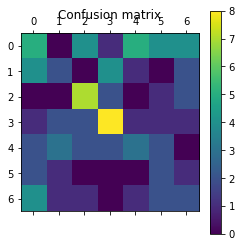

---------------------------------------------
clustering à k = 400
Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] max_depth=10, max_features=400, min_samples_leaf=1 ..............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=10, max_features=400, min_samples_leaf=1, total=   1.9s
[CV] max_depth=10, max_features=400, min_samples_leaf=1 ..............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s


[CV]  max_depth=10, max_features=400, min_samples_leaf=1, total=   1.8s
[CV] max_depth=10, max_features=400, min_samples_leaf=1 ..............
[CV]  max_depth=10, max_features=400, min_samples_leaf=1, total=   1.9s
[CV] max_depth=10, max_features=400, min_samples_leaf=1 ..............
[CV]  max_depth=10, max_features=400, min_samples_leaf=1, total=   1.9s
[CV] max_depth=10, max_features=400, min_samples_leaf=1 ..............
[CV]  max_depth=10, max_features=400, min_samples_leaf=1, total=   1.8s
[CV] max_depth=10, max_features=400, min_samples_leaf=3 ..............
[CV]  max_depth=10, max_features=400, min_samples_leaf=3, total=   1.5s
[CV] max_depth=10, max_features=400, min_samples_leaf=3 ..............
[CV]  max_depth=10, max_features=400, min_samples_leaf=3, total=   1.5s
[CV] max_depth=10, max_features=400, min_samples_leaf=3 ..............
[CV]  max_depth=10, max_features=400, min_samples_leaf=3, total=   1.5s
[CV] max_depth=10, max_features=400, min_samples_leaf=3 ..............

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:  1.3min finished


---------------------------------------------
best parameter : {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 5}
best score : 0.3350945857795173
Score accuracy test =  0.30526315789473685
[[4 0 4 1 8 2 4]
 [2 3 2 3 0 2 1]
 [0 2 5 1 0 2 2]
 [0 3 1 9 2 0 1]
 [3 0 0 4 5 2 0]
 [1 1 0 0 0 1 3]
 [2 3 0 2 1 1 2]]


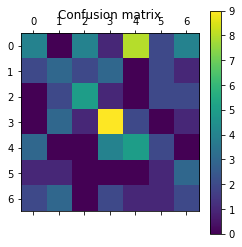

---------------------------------------------
Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] max_depth=10, max_features=400, min_samples_leaf=1 ..............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=10, max_features=400, min_samples_leaf=1, total=   1.9s
[CV] max_depth=10, max_features=400, min_samples_leaf=1 ..............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s


[CV]  max_depth=10, max_features=400, min_samples_leaf=1, total=   1.9s
[CV] max_depth=10, max_features=400, min_samples_leaf=1 ..............
[CV]  max_depth=10, max_features=400, min_samples_leaf=1, total=   1.9s
[CV] max_depth=10, max_features=400, min_samples_leaf=1 ..............
[CV]  max_depth=10, max_features=400, min_samples_leaf=1, total=   1.9s
[CV] max_depth=10, max_features=400, min_samples_leaf=1 ..............
[CV]  max_depth=10, max_features=400, min_samples_leaf=1, total=   2.0s
[CV] max_depth=10, max_features=400, min_samples_leaf=3 ..............
[CV]  max_depth=10, max_features=400, min_samples_leaf=3, total=   1.6s
[CV] max_depth=10, max_features=400, min_samples_leaf=3 ..............
[CV]  max_depth=10, max_features=400, min_samples_leaf=3, total=   1.6s
[CV] max_depth=10, max_features=400, min_samples_leaf=3 ..............
[CV]  max_depth=10, max_features=400, min_samples_leaf=3, total=   1.6s
[CV] max_depth=10, max_features=400, min_samples_leaf=3 ..............

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:  1.4min finished


---------------------------------------------
best parameter : {'max_depth': 20, 'max_features': 400, 'min_samples_leaf': 5}
best score : 0.33650172397726213
Score accuracy test =  0.35789473684210527
[[ 6  0  4  0  5  3  5]
 [ 1  3  1  1  0  4  3]
 [ 1  1  6  1  1  1  1]
 [ 1  0  1 11  1  1  1]
 [ 3  1  1  2  2  4  1]
 [ 2  1  0  1  0  1  1]
 [ 0  2  0  0  2  2  5]]


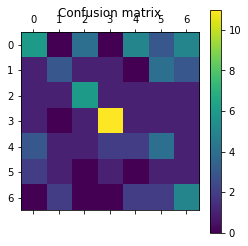

---------------------------------------------
Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] max_depth=10, max_features=400, min_samples_leaf=1 ..............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=10, max_features=400, min_samples_leaf=1, total=   1.9s
[CV] max_depth=10, max_features=400, min_samples_leaf=1 ..............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s


[CV]  max_depth=10, max_features=400, min_samples_leaf=1, total=   1.9s
[CV] max_depth=10, max_features=400, min_samples_leaf=1 ..............
[CV]  max_depth=10, max_features=400, min_samples_leaf=1, total=   1.9s
[CV] max_depth=10, max_features=400, min_samples_leaf=1 ..............
[CV]  max_depth=10, max_features=400, min_samples_leaf=1, total=   1.9s
[CV] max_depth=10, max_features=400, min_samples_leaf=1 ..............
[CV]  max_depth=10, max_features=400, min_samples_leaf=1, total=   1.9s
[CV] max_depth=10, max_features=400, min_samples_leaf=3 ..............
[CV]  max_depth=10, max_features=400, min_samples_leaf=3, total=   1.6s
[CV] max_depth=10, max_features=400, min_samples_leaf=3 ..............
[CV]  max_depth=10, max_features=400, min_samples_leaf=3, total=   1.5s
[CV] max_depth=10, max_features=400, min_samples_leaf=3 ..............
[CV]  max_depth=10, max_features=400, min_samples_leaf=3, total=   1.6s
[CV] max_depth=10, max_features=400, min_samples_leaf=3 ..............

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:  1.4min finished


---------------------------------------------
best parameter : {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 5}
best score : 0.35008852856210976
Score accuracy test =  0.28421052631578947
[[7 0 4 2 4 2 4]
 [2 2 0 4 0 3 2]
 [2 2 6 1 0 0 1]
 [1 2 1 8 2 2 0]
 [2 0 2 5 2 2 1]
 [2 0 0 1 0 2 1]
 [3 2 0 1 1 4 0]]


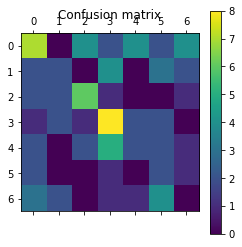

---------------------------------------------
Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] max_depth=10, max_features=400, min_samples_leaf=1 ..............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=10, max_features=400, min_samples_leaf=1, total=   1.9s
[CV] max_depth=10, max_features=400, min_samples_leaf=1 ..............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s


[CV]  max_depth=10, max_features=400, min_samples_leaf=1, total=   1.9s
[CV] max_depth=10, max_features=400, min_samples_leaf=1 ..............
[CV]  max_depth=10, max_features=400, min_samples_leaf=1, total=   1.9s
[CV] max_depth=10, max_features=400, min_samples_leaf=1 ..............
[CV]  max_depth=10, max_features=400, min_samples_leaf=1, total=   1.9s
[CV] max_depth=10, max_features=400, min_samples_leaf=1 ..............
[CV]  max_depth=10, max_features=400, min_samples_leaf=1, total=   1.9s
[CV] max_depth=10, max_features=400, min_samples_leaf=3 ..............
[CV]  max_depth=10, max_features=400, min_samples_leaf=3, total=   1.6s
[CV] max_depth=10, max_features=400, min_samples_leaf=3 ..............
[CV]  max_depth=10, max_features=400, min_samples_leaf=3, total=   1.6s
[CV] max_depth=10, max_features=400, min_samples_leaf=3 ..............
[CV]  max_depth=10, max_features=400, min_samples_leaf=3, total=   1.6s
[CV] max_depth=10, max_features=400, min_samples_leaf=3 ..............

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:  1.4min finished


---------------------------------------------
best parameter : {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1}
best score : 0.3350759481874942
Score accuracy test =  0.29473684210526313
[[6 2 2 1 4 2 6]
 [1 4 1 1 1 1 4]
 [2 1 5 1 1 1 1]
 [2 2 1 9 0 0 2]
 [4 0 2 5 1 1 1]
 [1 0 0 2 0 1 2]
 [2 2 0 2 1 2 2]]


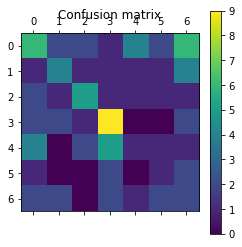

---------------------------------------------
Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] max_depth=10, max_features=400, min_samples_leaf=1 ..............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=10, max_features=400, min_samples_leaf=1, total=   1.9s
[CV] max_depth=10, max_features=400, min_samples_leaf=1 ..............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s


[CV]  max_depth=10, max_features=400, min_samples_leaf=1, total=   1.9s
[CV] max_depth=10, max_features=400, min_samples_leaf=1 ..............
[CV]  max_depth=10, max_features=400, min_samples_leaf=1, total=   1.9s
[CV] max_depth=10, max_features=400, min_samples_leaf=1 ..............
[CV]  max_depth=10, max_features=400, min_samples_leaf=1, total=   1.9s
[CV] max_depth=10, max_features=400, min_samples_leaf=1 ..............
[CV]  max_depth=10, max_features=400, min_samples_leaf=1, total=   1.9s
[CV] max_depth=10, max_features=400, min_samples_leaf=3 ..............
[CV]  max_depth=10, max_features=400, min_samples_leaf=3, total=   1.6s
[CV] max_depth=10, max_features=400, min_samples_leaf=3 ..............
[CV]  max_depth=10, max_features=400, min_samples_leaf=3, total=   1.6s
[CV] max_depth=10, max_features=400, min_samples_leaf=3 ..............
[CV]  max_depth=10, max_features=400, min_samples_leaf=3, total=   1.6s
[CV] max_depth=10, max_features=400, min_samples_leaf=3 ..............

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:  1.4min finished


---------------------------------------------
best parameter : {'max_depth': 10, 'max_features': 400, 'min_samples_leaf': 5}
best score : 0.32964309011275744
Score accuracy test =  0.2736842105263158
[[6 0 4 4 4 1 4]
 [1 3 1 0 0 6 2]
 [1 3 5 0 0 2 1]
 [0 0 1 8 2 4 1]
 [3 0 3 6 1 1 0]
 [3 0 0 1 0 1 1]
 [2 2 1 0 1 3 2]]


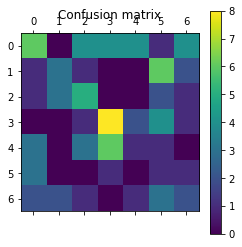

---------------------------------------------


k                                     accuracy_score
0  100  [0.2631578947368421, 0.25263157894736843, 0.26...
1  200  [0.2631578947368421, 0.2631578947368421, 0.294...
2  300  [0.3263157894736842, 0.29473684210526313, 0.24...
3  400  [0.30526315789473685, 0.35789473684210527, 0.2...

In [ ]:
###BOUCLE
list_rfc_accuracy=[]
list_k=[100, 200, 300, 400]

for k in list_k:
  print ('clustering à k =', k)
  
  # Encodage
  set_supervise_train= matrice_enc (list_des_orb_train, dic_kmeans,k,set_train_img['catego'])
  set_supervise_test= matrice_enc (list_des_orb_test, dic_kmeans,k,set_test_img['catego'])
  
  # RF classification
  rfc_search_orb,accuracy_orb= RFclassification_boucle(set_supervise_train.drop('catego',axis=1),
                                       set_supervise_train['catego'],
                                       set_supervise_test.drop('catego',axis=1),
                                       set_supervise_test['catego'])

  # Récupération du score
  list_rfc_accuracy.append(accuracy_orb)

result_nonsup=pd.DataFrame()
result_nonsup['k']=list_k
result_nonsup['accuracy_score']=list_rfc_accuracy
result_nonsup

In [ ]:
set_test_scor=pd.DataFrame()
j=100
for i in list_rfc_accuracy:
  set_test_scor[j]=i
  j+=100
set_test_scor=set_test_scor.T

In [ ]:
set_test_scor

0         1         2         3         4
100  0.263158  0.252632  0.263158  0.294737  0.294737
200  0.263158  0.263158  0.294737  0.263158  0.294737
300  0.326316  0.294737  0.242105  0.431579  0.305263
400  0.305263  0.357895  0.284211  0.294737  0.273684

In [ ]:
list_moy_scor_bow=[]
for i in range(len(set_test_scor)):
  list_moy_scor_bow.append(set_test_scor.iloc[i,:].mean())

set_moy_scor_bow=pd.DataFrame()
set_moy_scor_bow['k']=list_k
set_moy_scor_bow['score_moy']=list_moy_scor_bow
set_moy_scor_bow


k  score_moy
0  100   0.273684
1  200   0.275789
2  300   0.320000
3  400   0.303158

In [ ]:
set_bow_scor_max=set_test_scor.iloc[2,:].T.copy()
set_bow_scor_max

0    0.326316
1    0.294737
2    0.242105
3    0.431579
4    0.305263
Name: 300, dtype: float64

##CNN

###Préparation des images

In [ ]:
# fonction de création de répertoires d'images avec les noms des différentes catégories
def creat_img_folder (liste_img,list_nom,folder_name):

  X = np.array([np.array((os.path.join('pictur/', name_image))) for name_image in liste_img])

  for x, y, name_image in zip(X, list_nom.astype('str'),liste_img) :
      new_dir = 'Images'+'_'+ folder_name + '/' + y # Nouveau dossier de sauvegarde
      if not os.path.exists(new_dir):
          os.makedirs(new_dir) # Check si le dossier existe ou non
      img = Image.open(x) # Lecture de l'image
      img.save(os.path.join(new_dir, name_image))

In [ ]:
creat_img_folder (set_train['image'],set_train['catego'],'train')
creat_img_folder (set_test_stack['image'],set_test_stack['catego'],'test_stack')

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


###Nouveau réseau de neurone

In [ ]:
batch_size = 250
img_height = 32
img_width = 32

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
   'Images_train/',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 734 files belonging to 7 classes.
Using 588 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  'Images_train/',
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 734 files belonging to 7 classes.
Using 146 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['0', '1', '2', '3', '4', '5', '6']


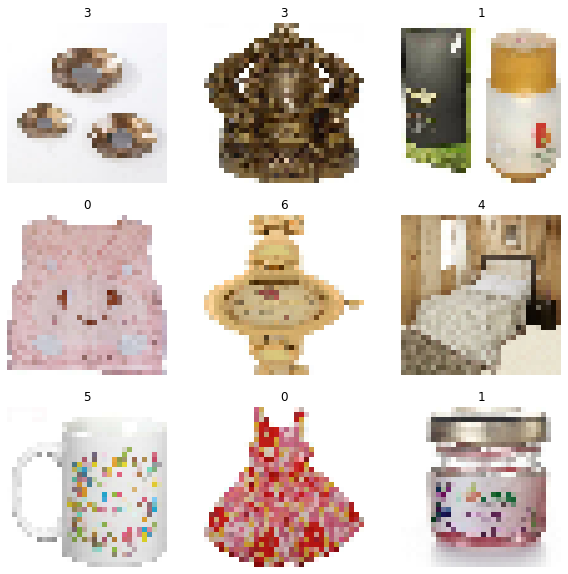

In [ ]:
### Exemple d'images 
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
### Nouveau réseau de neurones

num_classes = 7

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes,activation='softmax')
])

model.summary()

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

###Transfert Learning

####MobilNetV2

##### Set Train et Set Validation

In [ ]:
batch_size = len(set_train['image'])
img_height = 160
img_width = 160

In [ ]:
#Set d'images train 
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
                                                  'Images_train/',
                                                  validation_split=0.2,
                                                  subset="training",
                                                  seed=123,
                                                  image_size=(img_height, img_width),
                                                  batch_size=batch_size)

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
                                                  'Images_train/',
                                                  validation_split=0.2,
                                                  subset="validation",
                                                  seed=123,
                                                  image_size=(img_height, img_width),
                                                  batch_size=batch_size)

Found 734 files belonging to 7 classes.
Using 588 files for training.
Found 734 files belonging to 7 classes.
Using 146 files for validation.


#####Mise en place du modèle

In [ ]:
# Couche d'augmentation des données

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

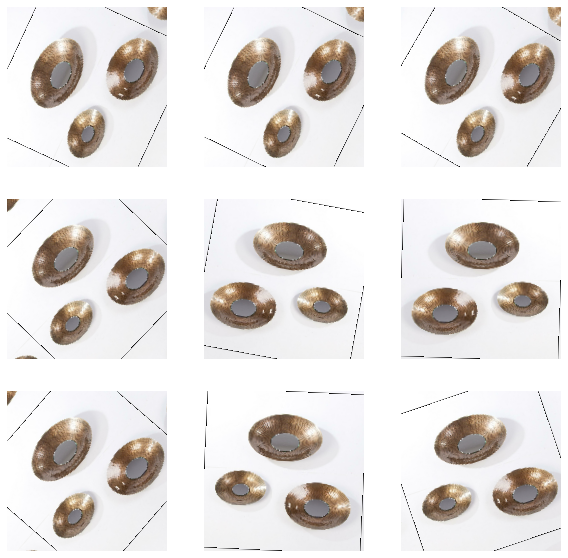

In [ ]:
# Test de la couche
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [ ]:
# Couche de formatages des images
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

#Chargement du model MobileNetV2
IMG_SIZE = (160, 160)
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

#Freeze des couches profondes
base_model.trainable = False

# Couche de réduction dimentionnelle pour approche non sup
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

# Couche de prédiction (7 sorties)
prediction_layer = tf.keras.layers.Dense(7,activation='softmax')

In [ ]:
# Construction du modèle
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)# pour éviter le surapprentissage
outputs = prediction_layer(x)
model_mnv2 = tf.keras.Model(inputs, outputs)

In [ ]:
# Compilation du modèle
model_mnv2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
model_mnv2.summary()

Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential_6 (Sequential)    (None, 160, 160, 3)       0         
_________________________________________________________________
tf_op_layer_RealDiv_5 (Tenso [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub_5 (TensorFlo [(None, 160, 160, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_5 ( (None, 1280)              0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 1280)            

##### Entrainement du modèle

In [ ]:
# Callback
checkpoint_path = 'saves/cp-{epoch:04d}.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callbacks = [
                
    keras.callbacks.EarlyStopping(
        # Stop training quand `val_loss` ne bouge plus
        monitor="val_loss",
        # limite de variantion
        min_delta=1e-3,
        # durant un nb d'epoch
        patience=5,
        verbose=1,),
    
    tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path, 
        verbose=1, 
        save_weights_only=True,
        save_freq=5)
  ]

In [ ]:
# Entrainement du modèle
history = model_mnv2.fit(train_dataset,
                    epochs=80,
                    validation_data=validation_dataset,callbacks=[cp_callbacks])

Epoch 1/80
1/1 [==============================] - 3s 3s/step - loss: 2.5696 - accuracy: 0.1071 - val_loss: 2.2143 - val_accuracy: 0.1986
Epoch 2/80
1/1 [==============================] - 1s 1s/step - loss: 2.4161 - accuracy: 0.1752 - val_loss: 2.0706 - val_accuracy: 0.2397
Epoch 3/80
1/1 [==============================] - 2s 2s/step - loss: 2.2312 - accuracy: 0.2177 - val_loss: 1.9406 - val_accuracy: 0.2534
Epoch 4/80
1/1 [==============================] - 2s 2s/step - loss: 2.0734 - accuracy: 0.2415 - val_loss: 1.8188 - val_accuracy: 0.3151
Epoch 5/80

Epoch 00005: saving model to saves/cp-0005.ckpt
1/1 [==============================] - 2s 2s/step - loss: 1.9454 - accuracy: 0.2806 - val_loss: 1.7047 - val_accuracy: 0.3425
Epoch 6/80
1/1 [==============================] - 1s 1s/step - loss: 1.8429 - accuracy: 0.3350 - val_loss: 1.6010 - val_accuracy: 0.3904
Epoch 7/80
1/1 [==============================] - 1s 1s/step - loss: 1.7128 - accuracy: 0.3724 - val_loss: 1.5070 - val_accuracy:

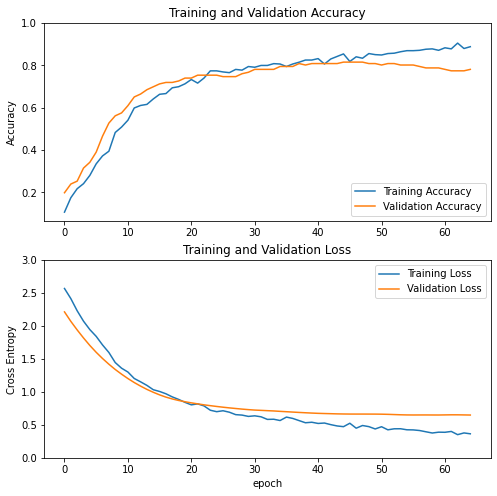

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,3.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show() 

##### Prédiction

In [ ]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  'Images_test_stack/',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 95 files belonging to 7 classes.


In [ ]:
image_batch, label_batch = test_ds.as_numpy_iterator().next() 
predictions = model_mnv2.predict_on_batch(image_batch)

In [ ]:
set_predict_modilnet=pd.DataFrame(predictions,columns=['0','1','2','3','4','5','6'])

list_label_pred=[]
for i in range(len(set_predict_modilnet)):

  list_label_pred.append(set_predict_modilnet.iloc[i,:].argmax())

set_predict_modilnet['High categorie']=list_label_pred
set_predict_modilnet['Categorie name']=le.inverse_transform(set_predict_modilnet['High categorie'])
set_predict_modilnet['true categorie']=label_batch
set_predict_modilnet['true categorie name']=le.inverse_transform(set_predict_modilnet['true categorie'])
set_predict_modilnet

0         1  ...  true categorie         true categorie name
0   0.000510  0.989972  ...               1    Beauty and Personal Care
1   0.016413  0.948755  ...               1    Beauty and Personal Care
2   0.247978  0.725570  ...               1    Beauty and Personal Care
3   0.168246  0.011293  ...               4             Home Furnishing
4   0.029974  0.619988  ...               0                   Baby Care
..       ...       ...  ...             ...                         ...
90  0.110652  0.867498  ...               1    Beauty and Personal Care
91  0.407021  0.055051  ...               0                   Baby Care
92  0.002183  0.003136  ...               6                     Watches
93  0.736287  0.005418  ...               3  Home Decor & Festive Needs
94  0.013227  0.219914  ...               2                   Computers

[95 rows x 11 columns]

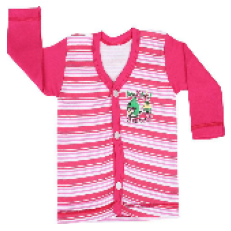

true label : Baby Care
pred label : Baby Care


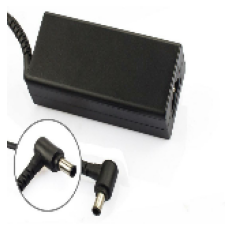

true label : Computers
pred label : Computers


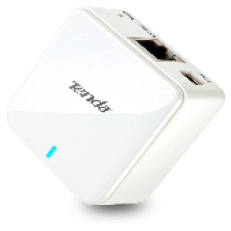

true label : Computers
pred label : Computers


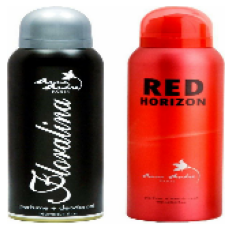

true label : Beauty and Personal Care
pred label : Beauty and Personal Care


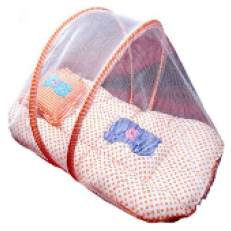

true label : Baby Care
pred label : Baby Care


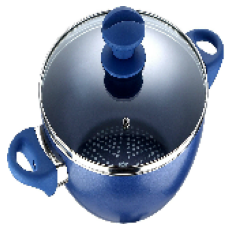

true label : Kitchen & Dining
pred label : Kitchen & Dining


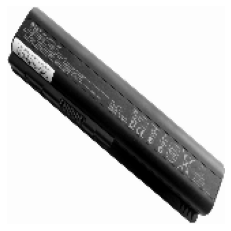

true label : Computers
pred label : Computers


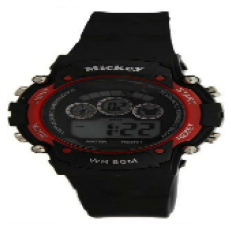

true label : Watches
pred label : Watches


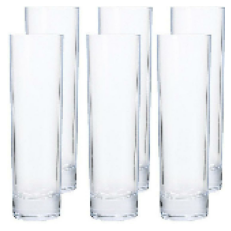

true label : Kitchen & Dining
pred label : Beauty and Personal Care


In [ ]:
plt.figure(figsize=(4,4))
for i in range(9):
  plt.imshow(image_batch[i].astype("uint8"))
  plt.axis("off")
  plt.show()
  print('true label :', set_predict_modilnet.iloc[i,10])
  print('pred label :', set_predict_modilnet.iloc[i,8])

accuracy =  0.8105263157894737
[[19  1  1  0  2  0  0]
 [ 2 11  0  0  0  0  0]
 [ 0  2  9  0  0  0  1]
 [ 2  1  0 13  0  0  0]
 [ 2  0  0  3  8  1  0]
 [ 0  0  0  0  0  6  0]
 [ 0  0  0  0  0  0 11]]


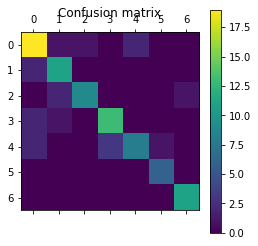

In [ ]:
rfc_mnv2_scor = accuracy_score(set_predict_modilnet['true categorie'],set_predict_modilnet['High categorie'] )
print ("accuracy = ", rfc_mnv2_scor)
cm = confusion_matrix(set_predict_modilnet['true categorie'],set_predict_modilnet['High categorie'])
print (cm)

showconfusionmatrix(cm)

pour le cluster ['Baby Care']


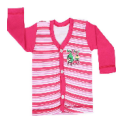

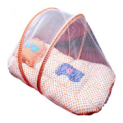

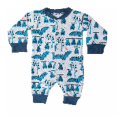

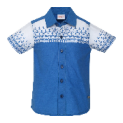

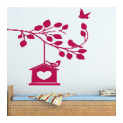

pour le cluster ['Beauty and Personal Care']


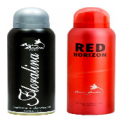

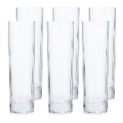

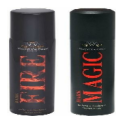

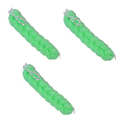

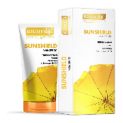

pour le cluster ['Computers']


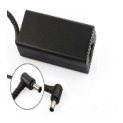

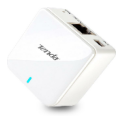

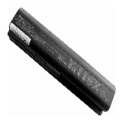

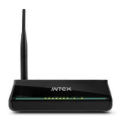

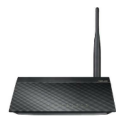

pour le cluster ['Home Decor & Festive Needs']


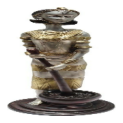

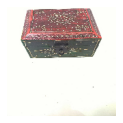

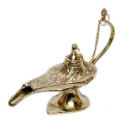

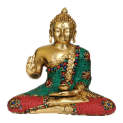

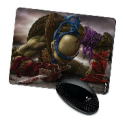

pour le cluster ['Home Furnishing']


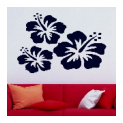

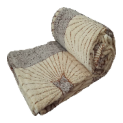

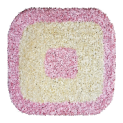

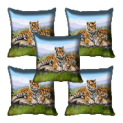

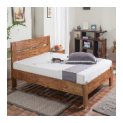

pour le cluster ['Kitchen & Dining']


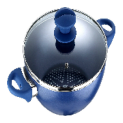

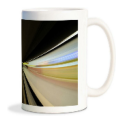

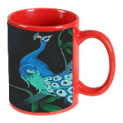

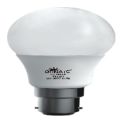

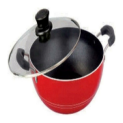

pour le cluster ['Watches']


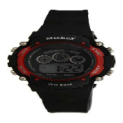

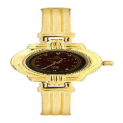

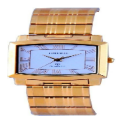

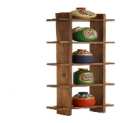

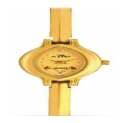

In [ ]:
for clus in range(7):
  set_clus=set_predict_modilnet[set_predict_modilnet['High categorie']==clus].head(5).copy()
  print( "pour le cluster", le.inverse_transform([clus]))
  for i in list(set_clus.index):
    plt.figure(figsize=(2,2))
    plt.imshow(image_batch[i].astype("uint8"))
    plt.axis("off")
    plt.show()
  

#### Approche non supervisée

##### ACP

In [ ]:
#retrait de la couche dense du model
model_CNN = Sequential()
for layer in model_mnv2.layers[:-1]: 
  model_CNN.add(layer)
for layer in model_CNN.layers:
  layer.trainable = False

#récupération des output
feature_map= model_CNN.predict(train_dataset)

# ACP
pca = PCA()
des_ss = StandardScaler()
outputnon_sup_ss=des_ss.fit_transform(feature_map)
pca.fit(outputnon_sup_ss)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

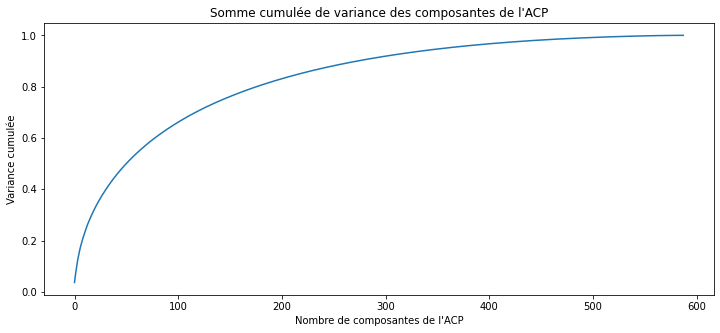

In [ ]:
plt.figure(figsize=(12,5))
plt.title('Somme cumulée de variance des composantes de l\'ACP')
plt.xlabel('Nombre de composantes de l\'ACP')
plt.ylabel('Variance cumulée')
plt.plot(list(range(feature_map.shape[0])),
         np.cumsum(pca.explained_variance_ratio_))

In [ ]:
np.cumsum(pca.explained_variance_ratio_)[400]

0.9671758

In [ ]:
descripteurs_reduit = pca.transform(feature_map)[:,:400]

##### Clustering

In [ ]:
dic_kmeans = {}
for i in range(2,16,1):
  print(i)

  kmeans = KMeans(n_clusters=i,
                   verbose=1,
                   random_state=0,
                   n_jobs=-1).fit(descripteurs_reduit)

  dic_kmeans[i] = kmeans
  print('OK')

2
OK
3
OK
4
OK
5
OK
6
OK
7
OK
8
OK
9
OK
10
OK
11
OK
12
OK
13
OK
14
OK
15
OK


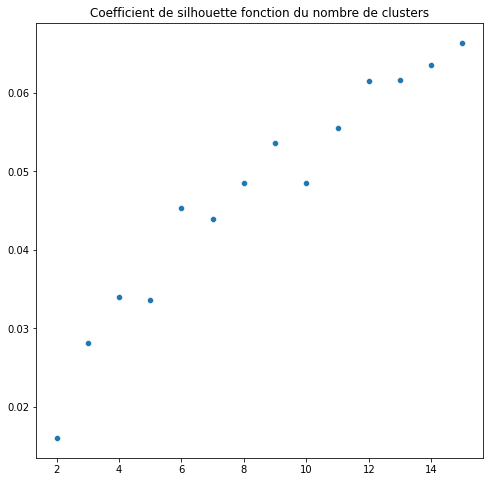

In [ ]:
coef_sil_kmeans = {}
for i in range(2,16,1):
    coef_sil_kmeans[i] = silhouette_score(X = descripteurs_reduit, labels= list(dic_kmeans[(i)].labels_))
plt.figure(figsize=(8,8)),
plt.title('Coefficient de silhouette fonction du nombre de clusters')
sns.scatterplot(x = list(coef_sil_kmeans.keys()),y = list(coef_sil_kmeans.values()))
plt.show()

In [ ]:
tsne = TSNE(n_components=2)
set_tsne = tsne.fit_transform(descripteurs_reduit.copy())

nb cluster = 7


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


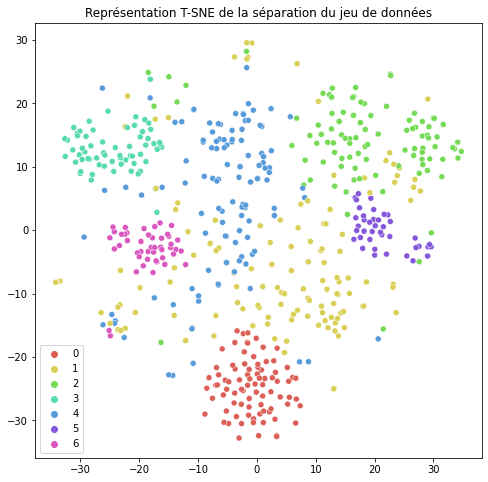

In [ ]:
print('nb cluster =', 7)
plt.figure(figsize=(8,8))
plt.title('Représentation T-SNE de la séparation du jeu de données')
sns.scatterplot(set_tsne[:,0],set_tsne[:,1],hue=dic_kmeans[7].labels_,
                legend='full', palette=sns.color_palette("hls",7))
plt.show()

In [ ]:
#récupération des prédictions
label_pred=dic_kmeans[(7)].labels_
set_label_pred=pd.DataFrame(label_pred,columns=['cluster_num'])
#récupération des labels
image_batch, label_batch = train_dataset.as_numpy_iterator().next() 
set_label_tru=pd.DataFrame(label_batch,columns=['label'])

In [ ]:
#nb d'article par catégorie
set_bar=pd.DataFrame()
set_bar['Catego']=[0,1,2,3,4,5,6]
set_bar['True']=list(set_label_tru.value_counts(sort=False))
set_bar['Pred']=list(set_label_pred.value_counts(sort=False))
set_bar

Catego  True  Pred
0       0    77    85
1       1    84   133
2       2    91   100
3       3    79    65
4       4    80   118
5       5    91    41
6       6    86    46

#####Distribution des catégories dans chaque cluster

In [ ]:
label_dict_enc=[0,1,2,3,4,5,6]
class_names={}
for i in label_dict_enc:
  class_names[i] = le.inverse_transform([label_dict_enc[i]])

Cluster 0


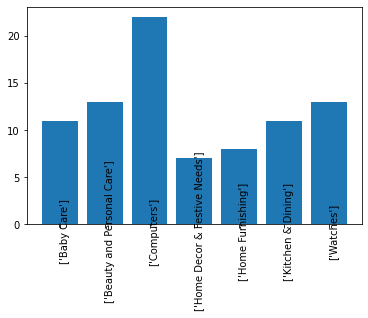

Cluster 1


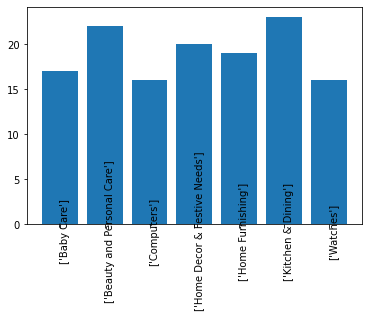

Cluster 2


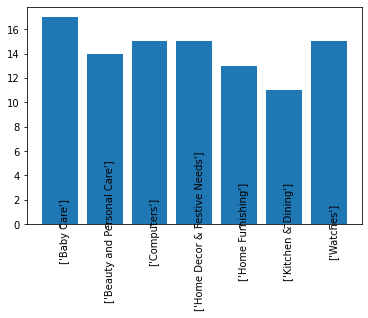

Cluster 3


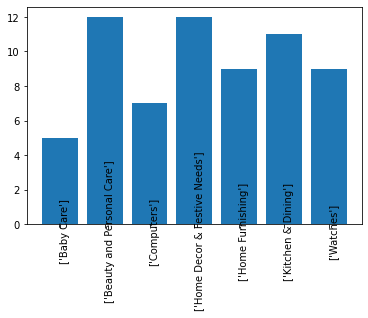

Cluster 4


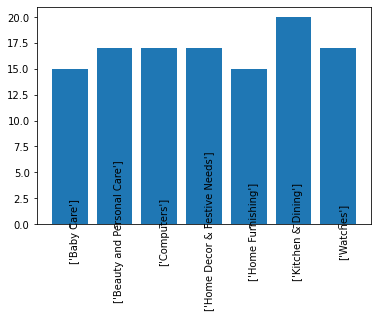

Cluster 5


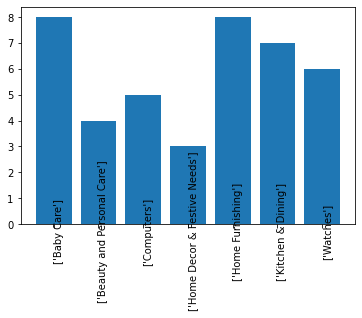

Cluster 6


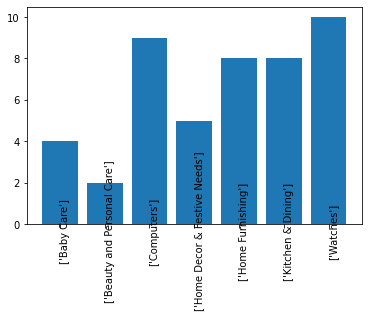

In [ ]:
for clu in range(7):
  set_cluster_index=set_label_pred[set_label_pred['cluster_num']==clu].copy()
  #compte des catégories dans le cluster
  list_label_cluster=[]
  for i in list(set_cluster_index.index):
    list_label_cluster.append(set_label_tru.iloc[i,0])
    unique,counts=np.unique(list_label_cluster,return_counts=True)
    dict_label_count = dict(zip(unique, counts))
  #plot en bar
  print("Cluster",clu)
  plt.bar(range(len(dict_label_count)), list(dict_label_count.values()), align='center')
  a = []
  for i in [*dict_label_count]: 
    a.append(class_names[i])
  plt.xticks(range(len(dict_label_count)), list(a), rotation=90, rotation_mode='anchor')
  plt.show()

#Classification de texte

In [ ]:
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
pip install spacy[lookups]

     |████████████████████████████████| 28.0MB 161kB/s 
  Created wheel for spacy-lookups-data: filename=spacy_lookups_data-0.1.0-py2.py3-none-any.whl size=28052144 sha256=280ffc9b0f18de8d879a28732ec6d93dbc24ff99377914c7e1e48450e5cee51a
  Stored in directory: /root/.cache/pip/wheels/2a/2b/0a/d6fb6235c56d014d224bca760d15d7cbdd820813085ffcd35d
Successfully built spacy-lookups-data


In [ ]:
text_data_train=pd.DataFrame()
text_data_train['description']=set_train['description'].copy()
text_data_train['catego']=set_train['catego'].copy() 
text_data_test=pd.DataFrame()
text_data_test['description']=set_test_stack['description'].copy()
text_data_test['catego']=set_test_stack['catego'].copy() 

text_data_train.head(5)

description  catego
734  Key Features of AntiqueShop ABKL_GRN_GRN_GRN S...       1
83   HEAVENLY Dress Baby Boy's  Combo Price: Rs. 59...       0
588  Shopfloor.XYZ Vacuum Cleaner for Computers, La...       2
341  Buy Belkin Share Modem (N) Router only for Rs....       2
179  Rockmantra Beautiful Girl With Big Feather Hat...       5

##Traitement de texte

In [ ]:
text_ex=text_data_train['description'].head(1)
text_ex[0:11]

734    Key Features of AntiqueShop ABKL_GRN_GRN_GRN S...
Name: description, dtype: object

In [ ]:
#Suppresion des chiffres
text_ex = (re.sub(r'\d+', '', text_ex.item()))
text_ex

'Key Features of AntiqueShop ABKL_GRN_GRN_GRN Soft on the skin Rope loop for easy hanging Durable, long lasting material Great for liquid soaps and body wash With this soft sponge, you can have a comforting and relaxing warm shower,AntiqueShop ABKL_GRN_GRN_GRN Price: Rs.  Brand New Nylon Body Shower Bath Puff Sponge Loofah Wash, Reaching Where No Other Scrubber Reaches. This product is made out of soft mesh, crafted perfectly thinking in exfoliating gently your skin, body and scrubbing away dead skin. Soft on the skin. Rope loop for easy hanging. Durable, long lasting material. Great for liquid soaps and body wash. With this soft sponge, you can have a comforting and relaxing warm shower. For more range of AntiqueShop, kindly type "AntiqueShop" in flipkart search. Please note that colour in picture and product received may varry depend upon availability in stock.,Specifications of AntiqueShop ABKL_GRN_GRN_GRN In the Box  Back Loofah Loofah Traits Material Nylon Size Medium Additional T

In [ ]:
#suppresion des petits mots
shortword = re.compile(r'\W*\b\w{1,2}\b')
text_ex=shortword.sub('', text_ex)

In [ ]:
text_ex

'Key Features AntiqueShop ABKL_GRN_GRN_GRN Soft the skin Rope loop for easy hanging Durable, long lasting material Great for liquid soaps and body wash With this soft sponge, you can have comforting and relaxing warm shower,AntiqueShop ABKL_GRN_GRN_GRN Price.  Brand New Nylon Body Shower Bath Puff Sponge Loofah Wash, Reaching Where Other Scrubber Reaches. This product made out soft mesh, crafted perfectly thinking exfoliating gently your skin, body and scrubbing away dead skin. Soft the skin. Rope loop for easy hanging. Durable, long lasting material. Great for liquid soaps and body wash. With this soft sponge, you can have comforting and relaxing warm shower. For more range AntiqueShop, kindly type "AntiqueShop flipkart search. Please note that colour picture and product received may varry depend upon availability stock.,Specifications AntiqueShop ABKL_GRN_GRN_GRN the Box  Back Loofah Loofah Traits Material Nylon Size Medium Additional Traits Great for liquid soaps and body wash'

In [ ]:
# Extraction des tokens
tokenizer = nltk.RegexpTokenizer(r'\w+')
text_ex=tokenizer.tokenize(text_ex)
len(text_ex)

148

In [ ]:
text_ex[0:10]

['Key',
 'Features',
 'AntiqueShop',
 'ABKL_GRN_GRN_GRN',
 'Soft',
 'the',
 'skin',
 'Rope',
 'loop',
 'for']

In [ ]:
 #Normalisation
 text_ex_low = []
 for i in text_ex:
  text_ex_low.append(i.lower())
text_ex_low[0:10]

['key',
 'features',
 'antiqueshop',
 'abkl_grn_grn_grn',
 'soft',
 'the',
 'skin',
 'rope',
 'loop',
 'for']

In [ ]:
#Stop word et adverbes/adjectifs
nlp = spacy.load("en_core_web_sm")
text_ex_nlp=[]
tags = {"NOUN", "VERB", "ADP", "PROPN"}

for desc in text_ex_lem:
    doc = nlp(desc)
    for token in doc:
        if not token.is_stop:
          if token.pos_ in tags :
            text_ex_nlp.append(doc)
len(text_ex_nlp)

84

In [ ]:
#lemmantisation
lemmatizer = WordNetLemmatizer()
text_ex_lem=[]
for i in text_ex_low:
  text_ex_lem.append(lemmatizer.lemmatize(i))
text_ex_lem[0:10]

##Etude des fréquences

In [ ]:
def clean_nlp_freq (frame):
  
  text_chi = []
  words = [] #list des tokens cleanés
  words_freq = [] #list des tokens les plus fréquents
  words_vals = [] #list des fréqences

  text=frame.copy()
  
  for st in text:
    
    # Suppression des chiffres
    text_sup=(re.sub(r'\d+', '', st))

    # Suppression des mots inf à 3 caractères
    shortword = re.compile(r'\W*\b\w{1,2}\b')
    text_chi.append(shortword.sub('', text_sup))

  # Extraction des tokens
  tokenizer = nltk.RegexpTokenizer(r'\w+')
  lemmatizer = WordNetLemmatizer()
  nlp = spacy.load("en_core_web_sm")
  tags = {"NOUN", "VERB", "ADP", "PROPN"}

  text_token=[]
  for i in text_chi:
    text_token.append(tokenizer.tokenize(i))

  # Normalisation, lemmentisation et suppression des stopwords et adverbes/adjectifs
  for t in text_token:
    for desc in t:
        low = desc.lower()
        lem = lemmatizer.lemmatize(low)
        doc = nlp(lem)
        for token in doc:
            if not token.is_stop:
              if token.pos_ in tags :
                words.append(doc)

  # Calcul des fréquences
  f = nltk.FreqDist(words)
  for tok, freq in f.most_common(100):#récupère les mots les plus fréqents
      words_freq.append(tok)
      words_vals.append(freq)

  return words, words_freq, words_vals

In [ ]:
words_des, words_freq_des, words_vals_des = clean_nlp_freq(text_data_train['description'].head(5))

In [ ]:
len(words_des)

427

In [ ]:
def freq_show(set_freq):
# Nuage de mots a partir de la fréquence des mots
  im = WordCloud(width=640, height=800).generate(",".join([i.text for i in set_freq]))
  f, a = plt.subplots(figsize=(4, 6))
  a.imshow(im, interpolation='nearest', aspect='auto')
  plt.axis("off")
  plt.show()

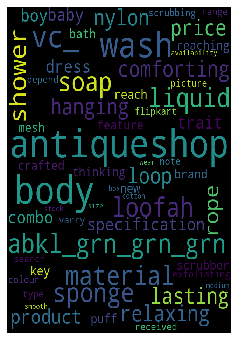

In [ ]:
freq_show(words_freq_des)

pour la catégorie : [0]


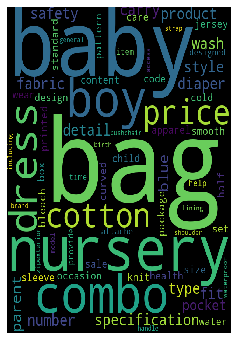

--------------------------------------------------
pour la catégorie : [1]


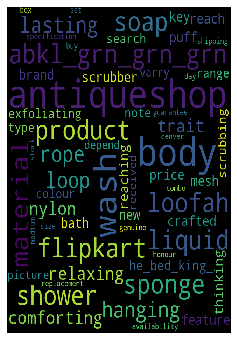

--------------------------------------------------
pour la catégorie : [2]


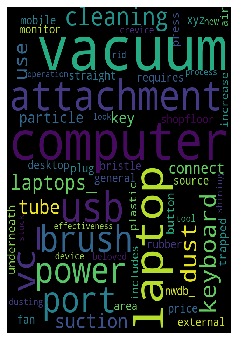

--------------------------------------------------
pour la catégorie : [3]


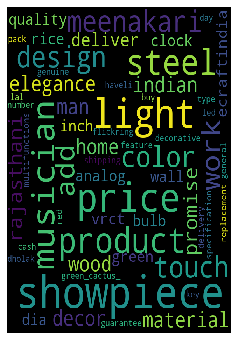

--------------------------------------------------
pour la catégorie : [4]


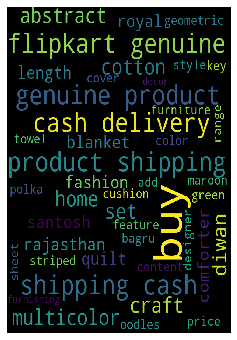

--------------------------------------------------
pour la catégorie : [5]


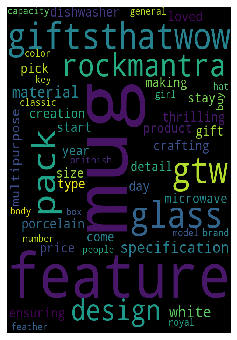

--------------------------------------------------
pour la catégorie : [6]


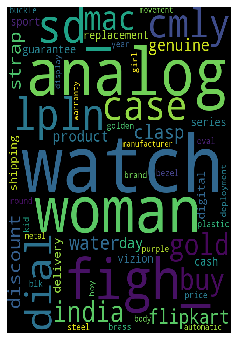

--------------------------------------------------


In [ ]:
for i in range(0,7,1):
  
  set_catego = text_data_train[text_data_train['catego']==i]
  print("pour la catégorie :", set_catego['catego'].unique())
  words_cat, words_freq_cat, words_vals_cat = clean_nlp_freq(set_catego['description'])
  freq_show (words_freq_cat)
  print('-'*50)

##Préparation des descriptions

In [ ]:
def clean_nlp (frame):
  text=frame.copy()

  # Extraction des tokens
  list_text_clean=[]
  tokenizer = nltk.RegexpTokenizer(r'\w+')
  lemmatizer = WordNetLemmatizer()
  nlp = spacy.load("en_core_web_sm")
  tags = {"NOUN", "VERB", "ADP", "PROPN"}

  for st in text['description']:
    words=[]
    # Suppression des chiffres
    text_sup=(re.sub(r'\d+', '', st))

    # Suppression des mots inf à 3 caractères
    shortword = re.compile(r'\W*\b\w{1,2}\b')
    text_chi=tokenizer.tokenize(shortword.sub('', text_sup))

  # Normalisation, lemmentisation et suppression des stopwords et adverbes/adjectifs
    
    for desc in text_chi:
        low = desc.lower()
        lem = lemmatizer.lemmatize(low)
        doc = nlp(lem)
        for token in doc:
            if not token.is_stop:
              if token.pos_ in tags :
                words.append(str(doc))
    
    list_text_clean.append(words)
    
  set_clean_t=pd.DataFrame()
  set_clean_t['des_clean']=list_text_clean
  set_clean_t['catego']=text['catego'].reset_index(drop=True)

  string_list=[]
  for i in range(len(set_clean_t['des_clean'])):
    string_list.append(' '.join(set_clean_t['des_clean'][i]))

  return string_list, set_clean_t 

In [ ]:
string_list_train, set_clean_train = clean_nlp (text_data_train)
pickle.dump( string_list_train, open( "string_list_train.p", "wb" ) )
pickle.dump( set_clean_train, open( "set_clean_train.p", "wb" ) )

In [ ]:
string_list_test, set_clean_test = clean_nlp (text_data_test)
pickle.dump( string_list_test, open( "string_list_test2.p", "wb" ) )
pickle.dump( set_clean_test, open( "set_clean_test2.p", "wb" ) )

In [ ]:
string_list_train = pickle.load( open( "string_list_train.p", "rb" ) )
set_clean_train = pickle.load( open( "set_clean_train.p", "rb" ) )

string_list_test = pickle.load( open( "string_list_test.p", "rb" ) )
set_clean_test = pickle.load( open( "set_clean_test.p", "rb" ) )

##Bag of Word

In [ ]:
tf_vectorizer = CountVectorizer(
                      max_df=0.65,
                      min_df=2,
                      )

tf=tf_vectorizer.fit_transform(string_list_train)

In [ ]:
tf_vector_train=tf.toarray()
set_bow_train=pd.DataFrame(tf_vector_train, columns=tf_vectorizer.get_feature_names())
set_bow_train['catego']=set_clean_train['catego']
set_bow_train.shape

(734, 1317)

In [ ]:
#Set de test
tf_vector_test=tf_vectorizer.transform(string_list_test).toarray() 
set_bow_test=pd.DataFrame(tf_vector_test, columns=tf_vectorizer.get_feature_names())
set_clean_test_index=set_clean_test['catego']
set_bow_test['catego']=set_clean_test_index
set_bow_test.shape

(95, 1317)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] max_depth=10, max_features=1316, min_samples_leaf=1 .............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=10, max_features=1316, min_samples_leaf=1, total=   1.2s
[CV] max_depth=10, max_features=1316, min_samples_leaf=1 .............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s


[CV]  max_depth=10, max_features=1316, min_samples_leaf=1, total=   1.2s
[CV] max_depth=10, max_features=1316, min_samples_leaf=1 .............
[CV]  max_depth=10, max_features=1316, min_samples_leaf=1, total=   1.2s
[CV] max_depth=10, max_features=1316, min_samples_leaf=1 .............
[CV]  max_depth=10, max_features=1316, min_samples_leaf=1, total=   1.2s
[CV] max_depth=10, max_features=1316, min_samples_leaf=1 .............
[CV]  max_depth=10, max_features=1316, min_samples_leaf=1, total=   1.2s
[CV] max_depth=10, max_features=1316, min_samples_leaf=3 .............
[CV]  max_depth=10, max_features=1316, min_samples_leaf=3, total=   1.2s
[CV] max_depth=10, max_features=1316, min_samples_leaf=3 .............
[CV]  max_depth=10, max_features=1316, min_samples_leaf=3, total=   1.2s
[CV] max_depth=10, max_features=1316, min_samples_leaf=3 .............
[CV]  max_depth=10, max_features=1316, min_samples_leaf=3, total=   1.2s
[CV] max_depth=10, max_features=1316, min_samples_leaf=3 ......

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:  1.1min finished


---------------------------------------------
best parameter : {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1}
best score : 0.9387009598359892
Score accuracy test =  0.9263157894736842
[[17  0  0  2  4  0  0]
 [ 0 13  0  0  0  0  0]
 [ 0  0 11  1  0  0  0]
 [ 0  0  0 16  0  0  0]
 [ 0  0  0  0 14  0  0]
 [ 0  0  0  0  0  6  0]
 [ 0  0  0  0  0  0 11]]


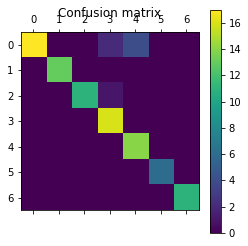

---------------------------------------------


In [ ]:
rfc_bow, rfc_bow_scor=RFclassification(set_bow_train.drop('catego',axis=1),
                                       set_bow_train['catego'],
                                       set_bow_test.drop('catego',axis=1),
                                       set_bow_test['catego'])

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] max_depth=10, max_features=1316, min_samples_leaf=1 .............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=10, max_features=1316, min_samples_leaf=1, total=   1.3s
[CV] max_depth=10, max_features=1316, min_samples_leaf=1 .............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s


[CV]  max_depth=10, max_features=1316, min_samples_leaf=1, total=   1.3s
[CV] max_depth=10, max_features=1316, min_samples_leaf=1 .............
[CV]  max_depth=10, max_features=1316, min_samples_leaf=1, total=   1.3s
[CV] max_depth=10, max_features=1316, min_samples_leaf=1 .............
[CV]  max_depth=10, max_features=1316, min_samples_leaf=1, total=   1.3s
[CV] max_depth=10, max_features=1316, min_samples_leaf=1 .............
[CV]  max_depth=10, max_features=1316, min_samples_leaf=1, total=   1.3s
[CV] max_depth=10, max_features=1316, min_samples_leaf=3 .............
[CV]  max_depth=10, max_features=1316, min_samples_leaf=3, total=   1.2s
[CV] max_depth=10, max_features=1316, min_samples_leaf=3 .............
[CV]  max_depth=10, max_features=1316, min_samples_leaf=3, total=   1.2s
[CV] max_depth=10, max_features=1316, min_samples_leaf=3 .............
[CV]  max_depth=10, max_features=1316, min_samples_leaf=3, total=   1.3s
[CV] max_depth=10, max_features=1316, min_samples_leaf=3 ......

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:  1.2min finished


---------------------------------------------
best parameter : {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1}
best score : 0.9373590532103252
Score accuracy test =  0.9157894736842105
[[17  0  0  2  4  0  0]
 [ 0 13  0  0  0  0  0]
 [ 0  0 11  1  0  0  0]
 [ 0  0  0 16  0  0  0]
 [ 0  0  0  1 13  0  0]
 [ 0  0  0  0  0  6  0]
 [ 0  0  0  0  0  0 11]]


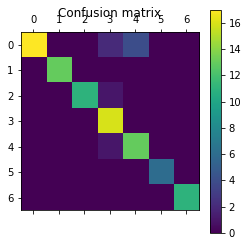

---------------------------------------------
Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] max_depth=10, max_features=1316, min_samples_leaf=1 .............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=10, max_features=1316, min_samples_leaf=1, total=   1.3s
[CV] max_depth=10, max_features=1316, min_samples_leaf=1 .............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s


[CV]  max_depth=10, max_features=1316, min_samples_leaf=1, total=   1.3s
[CV] max_depth=10, max_features=1316, min_samples_leaf=1 .............
[CV]  max_depth=10, max_features=1316, min_samples_leaf=1, total=   1.4s
[CV] max_depth=10, max_features=1316, min_samples_leaf=1 .............
[CV]  max_depth=10, max_features=1316, min_samples_leaf=1, total=   1.3s
[CV] max_depth=10, max_features=1316, min_samples_leaf=1 .............
[CV]  max_depth=10, max_features=1316, min_samples_leaf=1, total=   1.3s
[CV] max_depth=10, max_features=1316, min_samples_leaf=3 .............
[CV]  max_depth=10, max_features=1316, min_samples_leaf=3, total=   1.2s
[CV] max_depth=10, max_features=1316, min_samples_leaf=3 .............
[CV]  max_depth=10, max_features=1316, min_samples_leaf=3, total=   1.2s
[CV] max_depth=10, max_features=1316, min_samples_leaf=3 .............
[CV]  max_depth=10, max_features=1316, min_samples_leaf=3, total=   1.3s
[CV] max_depth=10, max_features=1316, min_samples_leaf=3 ......

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:  1.2min finished


---------------------------------------------
best parameter : {'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 1}
best score : 0.9305004193458204
Score accuracy test =  0.8842105263157894
[[17  0  0  3  3  0  0]
 [ 0 13  0  0  0  0  0]
 [ 0  0 11  1  0  0  0]
 [ 0  0  0 15  1  0  0]
 [ 1  0  0  2 11  0  0]
 [ 0  0  0  0  0  6  0]
 [ 0  0  0  0  0  0 11]]


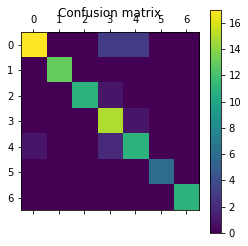

---------------------------------------------
Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] max_depth=10, max_features=1316, min_samples_leaf=1 .............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=10, max_features=1316, min_samples_leaf=1, total=   1.3s
[CV] max_depth=10, max_features=1316, min_samples_leaf=1 .............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s


[CV]  max_depth=10, max_features=1316, min_samples_leaf=1, total=   1.3s
[CV] max_depth=10, max_features=1316, min_samples_leaf=1 .............
[CV]  max_depth=10, max_features=1316, min_samples_leaf=1, total=   1.4s
[CV] max_depth=10, max_features=1316, min_samples_leaf=1 .............
[CV]  max_depth=10, max_features=1316, min_samples_leaf=1, total=   1.3s
[CV] max_depth=10, max_features=1316, min_samples_leaf=1 .............
[CV]  max_depth=10, max_features=1316, min_samples_leaf=1, total=   1.3s
[CV] max_depth=10, max_features=1316, min_samples_leaf=3 .............
[CV]  max_depth=10, max_features=1316, min_samples_leaf=3, total=   1.3s
[CV] max_depth=10, max_features=1316, min_samples_leaf=3 .............
[CV]  max_depth=10, max_features=1316, min_samples_leaf=3, total=   1.2s
[CV] max_depth=10, max_features=1316, min_samples_leaf=3 .............
[CV]  max_depth=10, max_features=1316, min_samples_leaf=3, total=   1.3s
[CV] max_depth=10, max_features=1316, min_samples_leaf=3 ......

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:  1.2min finished


---------------------------------------------
best parameter : {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1}
best score : 0.9332681017612525
Score accuracy test =  0.9157894736842105
[[17  0  0  3  3  0  0]
 [ 0 13  0  0  0  0  0]
 [ 0  0 11  1  0  0  0]
 [ 0  0  0 16  0  0  0]
 [ 1  0  0  0 13  0  0]
 [ 0  0  0  0  0  6  0]
 [ 0  0  0  0  0  0 11]]


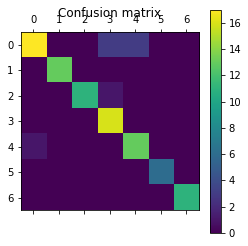

---------------------------------------------
Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] max_depth=10, max_features=1316, min_samples_leaf=1 .............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=10, max_features=1316, min_samples_leaf=1, total=   1.3s
[CV] max_depth=10, max_features=1316, min_samples_leaf=1 .............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s


[CV]  max_depth=10, max_features=1316, min_samples_leaf=1, total=   1.3s
[CV] max_depth=10, max_features=1316, min_samples_leaf=1 .............
[CV]  max_depth=10, max_features=1316, min_samples_leaf=1, total=   1.3s
[CV] max_depth=10, max_features=1316, min_samples_leaf=1 .............
[CV]  max_depth=10, max_features=1316, min_samples_leaf=1, total=   1.3s
[CV] max_depth=10, max_features=1316, min_samples_leaf=1 .............
[CV]  max_depth=10, max_features=1316, min_samples_leaf=1, total=   1.3s
[CV] max_depth=10, max_features=1316, min_samples_leaf=3 .............
[CV]  max_depth=10, max_features=1316, min_samples_leaf=3, total=   1.3s
[CV] max_depth=10, max_features=1316, min_samples_leaf=3 .............
[CV]  max_depth=10, max_features=1316, min_samples_leaf=3, total=   1.2s
[CV] max_depth=10, max_features=1316, min_samples_leaf=3 .............
[CV]  max_depth=10, max_features=1316, min_samples_leaf=3, total=   1.3s
[CV] max_depth=10, max_features=1316, min_samples_leaf=3 ......

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:  1.2min finished


---------------------------------------------
best parameter : {'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 1}
best score : 0.927788649706458
Score accuracy test =  0.8947368421052632
[[17  0  0  3  3  0  0]
 [ 0 13  0  0  0  0  0]
 [ 0  0 11  1  0  0  0]
 [ 0  0  0 15  1  0  0]
 [ 1  0  0  1 12  0  0]
 [ 0  0  0  0  0  6  0]
 [ 0  0  0  0  0  0 11]]


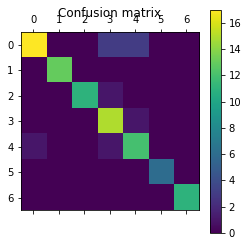

---------------------------------------------
Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] max_depth=10, max_features=1316, min_samples_leaf=1 .............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=10, max_features=1316, min_samples_leaf=1, total=   1.4s
[CV] max_depth=10, max_features=1316, min_samples_leaf=1 .............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s


[CV]  max_depth=10, max_features=1316, min_samples_leaf=1, total=   1.3s
[CV] max_depth=10, max_features=1316, min_samples_leaf=1 .............
[CV]  max_depth=10, max_features=1316, min_samples_leaf=1, total=   1.4s
[CV] max_depth=10, max_features=1316, min_samples_leaf=1 .............
[CV]  max_depth=10, max_features=1316, min_samples_leaf=1, total=   1.3s
[CV] max_depth=10, max_features=1316, min_samples_leaf=1 .............
[CV]  max_depth=10, max_features=1316, min_samples_leaf=1, total=   1.3s
[CV] max_depth=10, max_features=1316, min_samples_leaf=3 .............
[CV]  max_depth=10, max_features=1316, min_samples_leaf=3, total=   1.3s
[CV] max_depth=10, max_features=1316, min_samples_leaf=3 .............
[CV]  max_depth=10, max_features=1316, min_samples_leaf=3, total=   1.2s
[CV] max_depth=10, max_features=1316, min_samples_leaf=3 .............
[CV]  max_depth=10, max_features=1316, min_samples_leaf=3, total=   1.3s
[CV] max_depth=10, max_features=1316, min_samples_leaf=3 ......

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:  1.2min finished


---------------------------------------------
best parameter : {'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 1}
best score : 0.9291678315161681
Score accuracy test =  0.8842105263157894
[[17  0  0  3  3  0  0]
 [ 0 13  0  0  0  0  0]
 [ 0  0 11  1  0  0  0]
 [ 0  0  0 15  1  0  0]
 [ 1  1  0  1 11  0  0]
 [ 0  0  0  0  0  6  0]
 [ 0  0  0  0  0  0 11]]


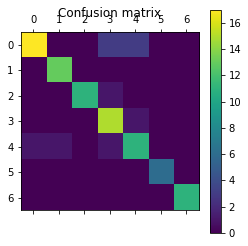

---------------------------------------------


In [ ]:
#### BOUCLE
rfc_bow, rfc_bow_scor=RFclassification_boucle(set_bow_train.drop('catego',axis=1),
                                       set_bow_train['catego'],
                                       set_bow_test.drop('catego',axis=1),
                                       set_bow_test['catego'])

##Tf-idf


In [ ]:
tfidf_vect = TfidfVectorizer(
                    analyzer='word',
                    max_df=0.65,
                    min_df=3
                    )
#Train
text_tfidf_train = tfidf_vect.fit_transform(string_list_train)

set_tfidf_train = pd.DataFrame(text_tfidf_train.toarray(), columns=tfidf_vect.get_feature_names())
set_tfidf_train['catego']=set_clean_train['catego']

#Test
text_tfidf_test = tfidf_vect.transform(string_list_test)

set_tfidf_test = pd.DataFrame(text_tfidf_test.toarray(), columns=tfidf_vect.get_feature_names())
set_tfidf_test['catego']=set_clean_test['catego']

set_tfidf_test.head()

absorbent  abstract  accessory  act  ...  yardley      year    yellow  catego
0        0.0       0.0        0.0  0.0  ...      0.0  0.000000  0.000000       1
1        0.0       0.0        0.0  0.0  ...      0.0  0.083862  0.000000       3
2        0.0       0.0        0.0  0.0  ...      0.0  0.000000  0.000000       2
3        0.0       0.0        0.0  0.0  ...      0.0  0.000000  0.000000       3
4        0.0       0.0        0.0  0.0  ...      0.0  0.000000  0.384718       0

[5 rows x 889 columns]

In [ ]:
set_tfidf_train.to_csv('feat_NLP_train2.csv')
set_tfidf_test.to_csv('feat_NLP_test2.csv')

In [ ]:
set_tfidf_train=pd.read_csv('feat_NLP_train2.csv')
set_tfidf_train=set_tfidf_train.drop('Unnamed: 0',axis=1)

set_tfidf_test=pd.read_csv('feat_NLP_test2.csv')
set_tfidf_test=set_tfidf_test.drop('Unnamed: 0',axis=1)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] max_depth=10, max_features=888, min_samples_leaf=1 ..............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=10, max_features=888, min_samples_leaf=1, total=   1.2s
[CV] max_depth=10, max_features=888, min_samples_leaf=1 ..............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s


[CV]  max_depth=10, max_features=888, min_samples_leaf=1, total=   1.2s
[CV] max_depth=10, max_features=888, min_samples_leaf=1 ..............
[CV]  max_depth=10, max_features=888, min_samples_leaf=1, total=   1.3s
[CV] max_depth=10, max_features=888, min_samples_leaf=1 ..............
[CV]  max_depth=10, max_features=888, min_samples_leaf=1, total=   1.2s
[CV] max_depth=10, max_features=888, min_samples_leaf=1 ..............
[CV]  max_depth=10, max_features=888, min_samples_leaf=1, total=   1.2s
[CV] max_depth=10, max_features=888, min_samples_leaf=3 ..............
[CV]  max_depth=10, max_features=888, min_samples_leaf=3, total=   1.2s
[CV] max_depth=10, max_features=888, min_samples_leaf=3 ..............
[CV]  max_depth=10, max_features=888, min_samples_leaf=3, total=   1.1s
[CV] max_depth=10, max_features=888, min_samples_leaf=3 ..............
[CV]  max_depth=10, max_features=888, min_samples_leaf=3, total=   1.2s
[CV] max_depth=10, max_features=888, min_samples_leaf=3 ..............

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:  1.1min finished


---------------------------------------------
best parameter : {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1}
best score : 0.9196533407883702
Score accuracy test =  0.9263157894736842
[[18  0  0  2  3  0  0]
 [ 0 13  0  0  0  0  0]
 [ 0  0 11  1  0  0  0]
 [ 0  0  0 16  0  0  0]
 [ 0  0  0  1 13  0  0]
 [ 0  0  0  0  0  6  0]
 [ 0  0  0  0  0  0 11]]


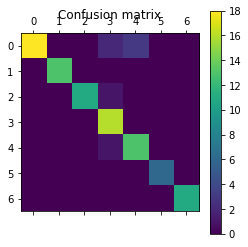

---------------------------------------------


In [ ]:
rfc_tfidf,rfc_tfidf_scor=RFclassification(set_tfidf_train.drop('catego',axis=1),
                                          set_tfidf_train['catego'],
                                          set_tfidf_test.drop('catego',axis=1),
                                          set_tfidf_test['catego'])

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] max_depth=10, max_features=888, min_samples_leaf=1 ..............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=10, max_features=888, min_samples_leaf=1, total=   1.3s
[CV] max_depth=10, max_features=888, min_samples_leaf=1 ..............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s


[CV]  max_depth=10, max_features=888, min_samples_leaf=1, total=   1.3s
[CV] max_depth=10, max_features=888, min_samples_leaf=1 ..............
[CV]  max_depth=10, max_features=888, min_samples_leaf=1, total=   1.3s
[CV] max_depth=10, max_features=888, min_samples_leaf=1 ..............
[CV]  max_depth=10, max_features=888, min_samples_leaf=1, total=   1.3s
[CV] max_depth=10, max_features=888, min_samples_leaf=1 ..............
[CV]  max_depth=10, max_features=888, min_samples_leaf=1, total=   1.3s
[CV] max_depth=10, max_features=888, min_samples_leaf=3 ..............
[CV]  max_depth=10, max_features=888, min_samples_leaf=3, total=   1.3s
[CV] max_depth=10, max_features=888, min_samples_leaf=3 ..............
[CV]  max_depth=10, max_features=888, min_samples_leaf=3, total=   1.2s
[CV] max_depth=10, max_features=888, min_samples_leaf=3 ..............
[CV]  max_depth=10, max_features=888, min_samples_leaf=3, total=   1.3s
[CV] max_depth=10, max_features=888, min_samples_leaf=3 ..............

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:  1.2min finished


---------------------------------------------
best parameter : {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1}
best score : 0.9169136147609729
Score accuracy test =  0.9263157894736842
[[17  0  0  3  3  0  0]
 [ 0 13  0  0  0  0  0]
 [ 0  0 11  1  0  0  0]
 [ 0  0  0 16  0  0  0]
 [ 0  0  0  0 14  0  0]
 [ 0  0  0  0  0  6  0]
 [ 0  0  0  0  0  0 11]]


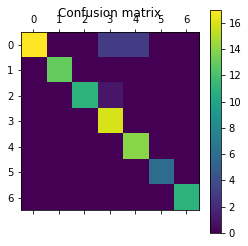

---------------------------------------------
Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] max_depth=10, max_features=888, min_samples_leaf=1 ..............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=10, max_features=888, min_samples_leaf=1, total=   1.3s
[CV] max_depth=10, max_features=888, min_samples_leaf=1 ..............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s


[CV]  max_depth=10, max_features=888, min_samples_leaf=1, total=   1.3s
[CV] max_depth=10, max_features=888, min_samples_leaf=1 ..............
[CV]  max_depth=10, max_features=888, min_samples_leaf=1, total=   1.3s
[CV] max_depth=10, max_features=888, min_samples_leaf=1 ..............
[CV]  max_depth=10, max_features=888, min_samples_leaf=1, total=   1.3s
[CV] max_depth=10, max_features=888, min_samples_leaf=1 ..............
[CV]  max_depth=10, max_features=888, min_samples_leaf=1, total=   1.3s
[CV] max_depth=10, max_features=888, min_samples_leaf=3 ..............
[CV]  max_depth=10, max_features=888, min_samples_leaf=3, total=   1.3s
[CV] max_depth=10, max_features=888, min_samples_leaf=3 ..............
[CV]  max_depth=10, max_features=888, min_samples_leaf=3, total=   1.2s
[CV] max_depth=10, max_features=888, min_samples_leaf=3 ..............
[CV]  max_depth=10, max_features=888, min_samples_leaf=3, total=   1.3s
[CV] max_depth=10, max_features=888, min_samples_leaf=3 ..............

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:  1.2min finished


---------------------------------------------
best parameter : {'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 1}
best score : 0.9128226633119001
Score accuracy test =  0.9263157894736842
[[17  0  0  2  3  1  0]
 [ 0 13  0  0  0  0  0]
 [ 0  0 11  1  0  0  0]
 [ 0  0  0 16  0  0  0]
 [ 0  0  0  0 14  0  0]
 [ 0  0  0  0  0  6  0]
 [ 0  0  0  0  0  0 11]]


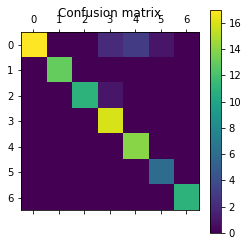

---------------------------------------------
Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] max_depth=10, max_features=888, min_samples_leaf=1 ..............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=10, max_features=888, min_samples_leaf=1, total=   1.3s
[CV] max_depth=10, max_features=888, min_samples_leaf=1 ..............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s


[CV]  max_depth=10, max_features=888, min_samples_leaf=1, total=   1.3s
[CV] max_depth=10, max_features=888, min_samples_leaf=1 ..............
[CV]  max_depth=10, max_features=888, min_samples_leaf=1, total=   1.3s
[CV] max_depth=10, max_features=888, min_samples_leaf=1 ..............
[CV]  max_depth=10, max_features=888, min_samples_leaf=1, total=   1.3s
[CV] max_depth=10, max_features=888, min_samples_leaf=1 ..............
[CV]  max_depth=10, max_features=888, min_samples_leaf=1, total=   1.3s
[CV] max_depth=10, max_features=888, min_samples_leaf=3 ..............
[CV]  max_depth=10, max_features=888, min_samples_leaf=3, total=   1.3s
[CV] max_depth=10, max_features=888, min_samples_leaf=3 ..............
[CV]  max_depth=10, max_features=888, min_samples_leaf=3, total=   1.2s
[CV] max_depth=10, max_features=888, min_samples_leaf=3 ..............
[CV]  max_depth=10, max_features=888, min_samples_leaf=3, total=   1.3s
[CV] max_depth=10, max_features=888, min_samples_leaf=3 ..............

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:  1.2min finished


---------------------------------------------
best parameter : {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1}
best score : 0.91827415897866
Score accuracy test =  0.9157894736842105
[[17  0  0  3  3  0  0]
 [ 0 13  0  0  0  0  0]
 [ 0  0 11  1  0  0  0]
 [ 0  0  0 16  0  0  0]
 [ 0  1  0  0 13  0  0]
 [ 0  0  0  0  0  6  0]
 [ 0  0  0  0  0  0 11]]


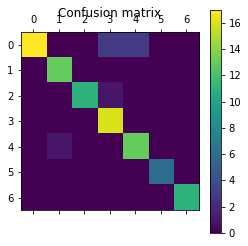

---------------------------------------------
Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] max_depth=10, max_features=888, min_samples_leaf=1 ..............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=10, max_features=888, min_samples_leaf=1, total=   1.3s
[CV] max_depth=10, max_features=888, min_samples_leaf=1 ..............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s


[CV]  max_depth=10, max_features=888, min_samples_leaf=1, total=   1.3s
[CV] max_depth=10, max_features=888, min_samples_leaf=1 ..............
[CV]  max_depth=10, max_features=888, min_samples_leaf=1, total=   1.3s
[CV] max_depth=10, max_features=888, min_samples_leaf=1 ..............
[CV]  max_depth=10, max_features=888, min_samples_leaf=1, total=   1.3s
[CV] max_depth=10, max_features=888, min_samples_leaf=1 ..............
[CV]  max_depth=10, max_features=888, min_samples_leaf=1, total=   1.3s
[CV] max_depth=10, max_features=888, min_samples_leaf=3 ..............
[CV]  max_depth=10, max_features=888, min_samples_leaf=3, total=   1.3s
[CV] max_depth=10, max_features=888, min_samples_leaf=3 ..............
[CV]  max_depth=10, max_features=888, min_samples_leaf=3, total=   1.2s
[CV] max_depth=10, max_features=888, min_samples_leaf=3 ..............
[CV]  max_depth=10, max_features=888, min_samples_leaf=3, total=   1.3s
[CV] max_depth=10, max_features=888, min_samples_leaf=3 ..............

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:  1.2min finished


---------------------------------------------
best parameter : {'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 1}
best score : 0.9209859286180226
Score accuracy test =  0.9157894736842105
[[17  0  0  2  3  1  0]
 [ 0 13  0  0  0  0  0]
 [ 0  0 11  1  0  0  0]
 [ 0  0  0 16  0  0  0]
 [ 0  0  0  1 13  0  0]
 [ 0  0  0  0  0  6  0]
 [ 0  0  0  0  0  0 11]]


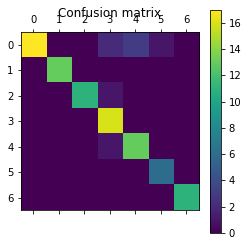

---------------------------------------------
Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] max_depth=10, max_features=888, min_samples_leaf=1 ..............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=10, max_features=888, min_samples_leaf=1, total=   1.4s
[CV] max_depth=10, max_features=888, min_samples_leaf=1 ..............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s


[CV]  max_depth=10, max_features=888, min_samples_leaf=1, total=   1.3s
[CV] max_depth=10, max_features=888, min_samples_leaf=1 ..............
[CV]  max_depth=10, max_features=888, min_samples_leaf=1, total=   1.3s
[CV] max_depth=10, max_features=888, min_samples_leaf=1 ..............
[CV]  max_depth=10, max_features=888, min_samples_leaf=1, total=   1.3s
[CV] max_depth=10, max_features=888, min_samples_leaf=1 ..............
[CV]  max_depth=10, max_features=888, min_samples_leaf=1, total=   1.3s
[CV] max_depth=10, max_features=888, min_samples_leaf=3 ..............
[CV]  max_depth=10, max_features=888, min_samples_leaf=3, total=   1.2s
[CV] max_depth=10, max_features=888, min_samples_leaf=3 ..............
[CV]  max_depth=10, max_features=888, min_samples_leaf=3, total=   1.2s
[CV] max_depth=10, max_features=888, min_samples_leaf=3 ..............
[CV]  max_depth=10, max_features=888, min_samples_leaf=3, total=   1.3s
[CV] max_depth=10, max_features=888, min_samples_leaf=3 ..............

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:  1.2min finished


---------------------------------------------
best parameter : {'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 1}
best score : 0.9196253844003355
Score accuracy test =  0.9157894736842105
[[17  0  0  2  3  1  0]
 [ 0 13  0  0  0  0  0]
 [ 0  0 11  0  0  1  0]
 [ 0  0  0 16  0  0  0]
 [ 0  0  0  1 13  0  0]
 [ 0  0  0  0  0  6  0]
 [ 0  0  0  0  0  0 11]]


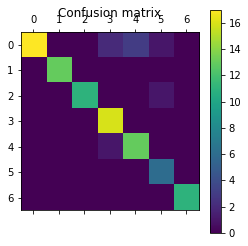

---------------------------------------------


In [ ]:
### BOUCLE
rfc_tfidf,rfc_tfidf_scor=RFclassification_boucle(set_tfidf_train.drop('catego',axis=1),
                                          set_tfidf_train['catego'],
                                          set_tfidf_test.drop('catego',axis=1),
                                          set_tfidf_test['catego'])

###Exemple prédiction 

In [ ]:
test=text_data_train['description'][245]

In [ ]:
test

'Buy Kalash Kadhai 11.5 L for Rs.1584 online. Kalash Kadhai 11.5 L at best prices with FREE shipping & cash on delivery. Only Genuine Products. 30 Day Replacement Guarantee.'

In [ ]:
le.inverse_transform(rfc_tfidf.predict(tfidf_vect.transform([test])))

array(['Kitchen & Dining'], dtype=object)

In [ ]:
le.inverse_transform([text_data_train['catego'][245]])

array(['Kitchen & Dining'], dtype=object)

##Word Embedding

###Word2vec

In [ ]:
#Model
w2v_model = Word2Vec(min_count=1,
                     window=4
                     )
#Vocabulaire
w2v_model.build_vocab(set_clean_train['des_clean'], progress_per=10000)          

#Entrainement
w2v_model.train(set_clean_train['des_clean'], total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

(740624, 927780)

In [ ]:
w2v_model.wv.index2word

['product',
 'buy',
 'delivery',
 'genuine',
 'shipping',
 'cash',
 'replacement',
 'price',
 'day',
 'flipkart',
 'mug',
 'guarantee',
 'com',
 'feature',
 'specification',
 'color',
 'type',
 'watch',
 'set',
 'pack',
 'cotton',
 'material',
 'box',
 'baby',
 'general',
 'quality',
 'package',
 'number',
 'sale',
 'inch',
 'design',
 'analog',
 'brand',
 'warranty',
 'detail',
 'model',
 'key',
 'girl',
 'laptop',
 'fabric',
 'gift',
 'size',
 'showpiece',
 'dimension',
 'boy',
 'coffee',
 'multicolor',
 'home',
 'india',
 'print',
 'content',
 'usb',
 'men',
 'battery',
 'water',
 'woman',
 'cover',
 'combo',
 'width',
 'printed',
 'discount',
 'adapter',
 'light',
 'towel',
 'wash',
 'care',
 'body',
 'blue',
 'length',
 'pattern',
 'height',
 'look',
 'style',
 'power',
 'designed',
 'shape',
 'come',
 'round',
 'use',
 'weight',
 'brass',
 'sheet',
 'wall',
 'strap',
 'dial',
 'white',
 'dress',
 'sleeve',
 'steel',
 'art',
 'code',
 'tea',
 'fit',
 'bedsheet',
 'loved',
 'room',

In [ ]:
w2v = dict(zip(w2v_model.wv.index2word, w2v_model.wv.vectors))

In [ ]:
#Matrice features vectorisées

def get_vect(word, mod):
    try:
        return mod.wv[word]
    except KeyError:
        return np.zeros((mod.vector_size,))

def sum_vectors(phrase, mod):
    return sum(get_vect(w, mod) for w in phrase)

def word2vec_features(X, mod):
    feats = np.vstack([sum_vectors(p, mod) for p in X])
    return feats

In [ ]:
wv_train_feat = word2vec_features(set_clean_train['des_clean'], w2v_model)
wv_train_feat.shape

(734, 100)

In [ ]:
wv_test_feat = word2vec_features(set_clean_test['des_clean'], w2v_model)
wv_test_feat.shape

(95, 100)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] max_depth=10, max_features=100, min_samples_leaf=1 ..............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=10, max_features=100, min_samples_leaf=1, total=   2.1s
[CV] max_depth=10, max_features=100, min_samples_leaf=1 ..............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.1s remaining:    0.0s


[CV]  max_depth=10, max_features=100, min_samples_leaf=1, total=   2.0s
[CV] max_depth=10, max_features=100, min_samples_leaf=1 ..............
[CV]  max_depth=10, max_features=100, min_samples_leaf=1, total=   2.0s
[CV] max_depth=10, max_features=100, min_samples_leaf=1 ..............
[CV]  max_depth=10, max_features=100, min_samples_leaf=1, total=   2.0s
[CV] max_depth=10, max_features=100, min_samples_leaf=1 ..............
[CV]  max_depth=10, max_features=100, min_samples_leaf=1, total=   2.0s
[CV] max_depth=10, max_features=100, min_samples_leaf=3 ..............
[CV]  max_depth=10, max_features=100, min_samples_leaf=3, total=   1.9s
[CV] max_depth=10, max_features=100, min_samples_leaf=3 ..............
[CV]  max_depth=10, max_features=100, min_samples_leaf=3, total=   1.9s
[CV] max_depth=10, max_features=100, min_samples_leaf=3 ..............
[CV]  max_depth=10, max_features=100, min_samples_leaf=3, total=   1.9s
[CV] max_depth=10, max_features=100, min_samples_leaf=3 ..............

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:  1.7min finished


---------------------------------------------
best parameter : {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1}
best score : 0.9086944366787811
Score accuracy test =  0.8842105263157894
[[17  1  0  1  4  0  0]
 [ 0 13  0  0  0  0  0]
 [ 1  0 11  0  0  0  0]
 [ 0  0  1 14  1  0  0]
 [ 1  0  0  0 13  0  0]
 [ 0  0  0  1  0  5  0]
 [ 0  0  0  0  0  0 11]]


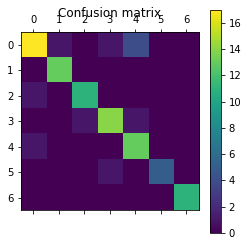

---------------------------------------------


In [ ]:
rfc_w2v, rfc_w2v_scor=RFclassification(wv_train_feat,
                                       set_clean_train['catego'],
                                       wv_test_feat,
                                       set_clean_test['catego'])

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] max_depth=10, max_features=100, min_samples_leaf=1 ..............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=10, max_features=100, min_samples_leaf=1, total=   2.0s
[CV] max_depth=10, max_features=100, min_samples_leaf=1 ..............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s remaining:    0.0s


[CV]  max_depth=10, max_features=100, min_samples_leaf=1, total=   2.0s
[CV] max_depth=10, max_features=100, min_samples_leaf=1 ..............
[CV]  max_depth=10, max_features=100, min_samples_leaf=1, total=   2.0s
[CV] max_depth=10, max_features=100, min_samples_leaf=1 ..............
[CV]  max_depth=10, max_features=100, min_samples_leaf=1, total=   2.0s
[CV] max_depth=10, max_features=100, min_samples_leaf=1 ..............
[CV]  max_depth=10, max_features=100, min_samples_leaf=1, total=   2.0s
[CV] max_depth=10, max_features=100, min_samples_leaf=3 ..............
[CV]  max_depth=10, max_features=100, min_samples_leaf=3, total=   1.9s
[CV] max_depth=10, max_features=100, min_samples_leaf=3 ..............
[CV]  max_depth=10, max_features=100, min_samples_leaf=3, total=   1.9s
[CV] max_depth=10, max_features=100, min_samples_leaf=3 ..............
[CV]  max_depth=10, max_features=100, min_samples_leaf=3, total=   2.0s
[CV] max_depth=10, max_features=100, min_samples_leaf=3 ..............

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:  1.7min finished


---------------------------------------------
best parameter : {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 3}
best score : 0.9086944366787811
Score accuracy test =  0.9157894736842105
[[18  0  0  1  4  0  0]
 [ 0 13  0  0  0  0  0]
 [ 1  0 11  0  0  0  0]
 [ 0  0  1 14  1  0  0]
 [ 0  0  0  0 14  0  0]
 [ 0  0  0  0  0  6  0]
 [ 0  0  0  0  0  0 11]]


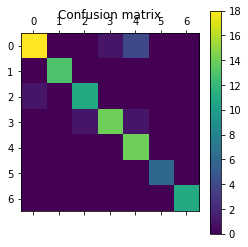

---------------------------------------------
Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] max_depth=10, max_features=100, min_samples_leaf=1 ..............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=10, max_features=100, min_samples_leaf=1, total=   2.0s
[CV] max_depth=10, max_features=100, min_samples_leaf=1 ..............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s remaining:    0.0s


[CV]  max_depth=10, max_features=100, min_samples_leaf=1, total=   2.0s
[CV] max_depth=10, max_features=100, min_samples_leaf=1 ..............
[CV]  max_depth=10, max_features=100, min_samples_leaf=1, total=   2.0s
[CV] max_depth=10, max_features=100, min_samples_leaf=1 ..............
[CV]  max_depth=10, max_features=100, min_samples_leaf=1, total=   2.0s
[CV] max_depth=10, max_features=100, min_samples_leaf=1 ..............
[CV]  max_depth=10, max_features=100, min_samples_leaf=1, total=   2.0s
[CV] max_depth=10, max_features=100, min_samples_leaf=3 ..............
[CV]  max_depth=10, max_features=100, min_samples_leaf=3, total=   1.9s
[CV] max_depth=10, max_features=100, min_samples_leaf=3 ..............
[CV]  max_depth=10, max_features=100, min_samples_leaf=3, total=   1.8s
[CV] max_depth=10, max_features=100, min_samples_leaf=3 ..............
[CV]  max_depth=10, max_features=100, min_samples_leaf=3, total=   1.9s
[CV] max_depth=10, max_features=100, min_samples_leaf=3 ..............

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:  1.7min finished


---------------------------------------------
best parameter : {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1}
best score : 0.9087317118628274
Score accuracy test =  0.8947368421052632
[[15  1  0  2  4  1  0]
 [ 0 13  0  0  0  0  0]
 [ 0  0 11  0  1  0  0]
 [ 0  0  0 15  1  0  0]
 [ 0  0  0  0 14  0  0]
 [ 0  0  0  0  0  6  0]
 [ 0  0  0  0  0  0 11]]


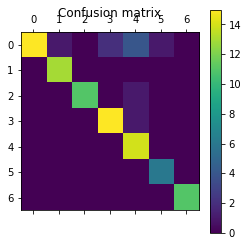

---------------------------------------------
Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] max_depth=10, max_features=100, min_samples_leaf=1 ..............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=10, max_features=100, min_samples_leaf=1, total=   2.0s
[CV] max_depth=10, max_features=100, min_samples_leaf=1 ..............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s remaining:    0.0s


[CV]  max_depth=10, max_features=100, min_samples_leaf=1, total=   1.9s
[CV] max_depth=10, max_features=100, min_samples_leaf=1 ..............
[CV]  max_depth=10, max_features=100, min_samples_leaf=1, total=   2.0s
[CV] max_depth=10, max_features=100, min_samples_leaf=1 ..............
[CV]  max_depth=10, max_features=100, min_samples_leaf=1, total=   2.0s
[CV] max_depth=10, max_features=100, min_samples_leaf=1 ..............
[CV]  max_depth=10, max_features=100, min_samples_leaf=1, total=   2.0s
[CV] max_depth=10, max_features=100, min_samples_leaf=3 ..............
[CV]  max_depth=10, max_features=100, min_samples_leaf=3, total=   1.9s
[CV] max_depth=10, max_features=100, min_samples_leaf=3 ..............
[CV]  max_depth=10, max_features=100, min_samples_leaf=3, total=   1.8s
[CV] max_depth=10, max_features=100, min_samples_leaf=3 ..............
[CV]  max_depth=10, max_features=100, min_samples_leaf=3, total=   1.9s
[CV] max_depth=10, max_features=100, min_samples_leaf=3 ..............

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:  1.7min finished


---------------------------------------------
best parameter : {'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 1}
best score : 0.9073432112571055
Score accuracy test =  0.9052631578947369
[[17  1  0  1  4  0  0]
 [ 0 13  0  0  0  0  0]
 [ 1  0 11  0  0  0  0]
 [ 0  0  0 15  1  0  0]
 [ 1  0  0  0 13  0  0]
 [ 0  0  0  0  0  6  0]
 [ 0  0  0  0  0  0 11]]


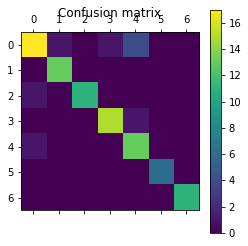

---------------------------------------------
Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] max_depth=10, max_features=100, min_samples_leaf=1 ..............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=10, max_features=100, min_samples_leaf=1, total=   2.0s
[CV] max_depth=10, max_features=100, min_samples_leaf=1 ..............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s remaining:    0.0s


[CV]  max_depth=10, max_features=100, min_samples_leaf=1, total=   2.0s
[CV] max_depth=10, max_features=100, min_samples_leaf=1 ..............
[CV]  max_depth=10, max_features=100, min_samples_leaf=1, total=   2.0s
[CV] max_depth=10, max_features=100, min_samples_leaf=1 ..............
[CV]  max_depth=10, max_features=100, min_samples_leaf=1, total=   2.0s
[CV] max_depth=10, max_features=100, min_samples_leaf=1 ..............
[CV]  max_depth=10, max_features=100, min_samples_leaf=1, total=   2.1s
[CV] max_depth=10, max_features=100, min_samples_leaf=3 ..............
[CV]  max_depth=10, max_features=100, min_samples_leaf=3, total=   1.9s
[CV] max_depth=10, max_features=100, min_samples_leaf=3 ..............
[CV]  max_depth=10, max_features=100, min_samples_leaf=3, total=   1.9s
[CV] max_depth=10, max_features=100, min_samples_leaf=3 ..............
[CV]  max_depth=10, max_features=100, min_samples_leaf=3, total=   1.9s
[CV] max_depth=10, max_features=100, min_samples_leaf=3 ..............

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:  1.7min finished


---------------------------------------------
best parameter : {'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 1}
best score : 0.9073618488491288
Score accuracy test =  0.9052631578947369
[[17  1  0  1  4  0  0]
 [ 0 13  0  0  0  0  0]
 [ 1  0 11  0  0  0  0]
 [ 0  0  0 15  1  0  0]
 [ 1  0  0  0 13  0  0]
 [ 0  0  0  0  0  6  0]
 [ 0  0  0  0  0  0 11]]


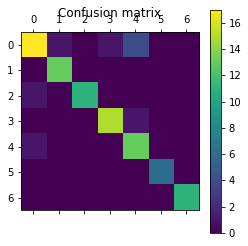

---------------------------------------------
Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] max_depth=10, max_features=100, min_samples_leaf=1 ..............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=10, max_features=100, min_samples_leaf=1, total=   2.0s
[CV] max_depth=10, max_features=100, min_samples_leaf=1 ..............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s remaining:    0.0s


[CV]  max_depth=10, max_features=100, min_samples_leaf=1, total=   1.9s
[CV] max_depth=10, max_features=100, min_samples_leaf=1 ..............
[CV]  max_depth=10, max_features=100, min_samples_leaf=1, total=   2.0s
[CV] max_depth=10, max_features=100, min_samples_leaf=1 ..............
[CV]  max_depth=10, max_features=100, min_samples_leaf=1, total=   2.0s
[CV] max_depth=10, max_features=100, min_samples_leaf=1 ..............
[CV]  max_depth=10, max_features=100, min_samples_leaf=1, total=   2.0s
[CV] max_depth=10, max_features=100, min_samples_leaf=3 ..............
[CV]  max_depth=10, max_features=100, min_samples_leaf=3, total=   1.9s
[CV] max_depth=10, max_features=100, min_samples_leaf=3 ..............
[CV]  max_depth=10, max_features=100, min_samples_leaf=3, total=   1.8s
[CV] max_depth=10, max_features=100, min_samples_leaf=3 ..............
[CV]  max_depth=10, max_features=100, min_samples_leaf=3, total=   1.9s
[CV] max_depth=10, max_features=100, min_samples_leaf=3 ..............

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:  1.7min finished


---------------------------------------------
best parameter : {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1}
best score : 0.9100736184884912
Score accuracy test =  0.9052631578947369
[[17  0  0  1  5  0  0]
 [ 0 13  0  0  0  0  0]
 [ 1  0 11  0  0  0  0]
 [ 0  0  0 15  1  0  0]
 [ 1  0  0  0 13  0  0]
 [ 0  0  0  0  0  6  0]
 [ 0  0  0  0  0  0 11]]


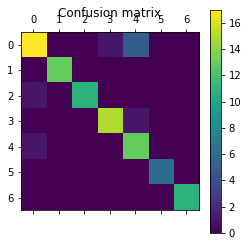

---------------------------------------------


In [ ]:
### BOUCLE
rfc_w2v, rfc_w2v_scor=RFclassification_boucle(wv_train_feat,
                                       set_clean_train['catego'],
                                       wv_test_feat,
                                       set_clean_test['catego'])

### BERT

In [ ]:
model_bert = SentenceTransformer('distiluse-base-multilingual-cased') 

100%|██████████| 504M/504M [00:27<00:00, 18.2MB/s]


In [ ]:
corpus_train = text_data_train['description'].reset_index(drop=True)
corpus_embeddings_train = model_bert.encode(corpus_train)

corpus_test = text_data_test['description'].reset_index(drop=True)
corpus_embeddings_test = model_bert.encode(corpus_test)

In [ ]:
rfc_BERT, rfc_BERT_scor=RFclassification(corpus_embeddings_train,
                                         text_data_train['catego'],
                                         corpus_embeddings_test,
                                         text_data_test['catego'])

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] max_depth=10, max_features=512, min_samples_leaf=1 ..............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=10, max_features=512, min_samples_leaf=1, total=  10.9s
[CV] max_depth=10, max_features=512, min_samples_leaf=1 ..............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.9s remaining:    0.0s


[CV]  max_depth=10, max_features=512, min_samples_leaf=1, total=  10.9s
[CV] max_depth=10, max_features=512, min_samples_leaf=1 ..............
[CV]  max_depth=10, max_features=512, min_samples_leaf=1, total=  10.9s
[CV] max_depth=10, max_features=512, min_samples_leaf=1 ..............
[CV]  max_depth=10, max_features=512, min_samples_leaf=1, total=  10.8s
[CV] max_depth=10, max_features=512, min_samples_leaf=1 ..............
[CV]  max_depth=10, max_features=512, min_samples_leaf=1, total=  10.7s
[CV] max_depth=10, max_features=512, min_samples_leaf=3 ..............
[CV]  max_depth=10, max_features=512, min_samples_leaf=3, total=  10.3s
[CV] max_depth=10, max_features=512, min_samples_leaf=3 ..............
[CV]  max_depth=10, max_features=512, min_samples_leaf=3, total=  10.3s
[CV] max_depth=10, max_features=512, min_samples_leaf=3 ..............
[CV]  max_depth=10, max_features=512, min_samples_leaf=3, total=  10.3s
[CV] max_depth=10, max_features=512, min_samples_leaf=3 ..............

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:  8.3min finished


---------------------------------------------
best parameter : {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 5}
best score : 0.8991333519709255
Score accuracy test =  0.8947368421052632
[[16  1  1  0  5  0  0]
 [ 0 13  0  0  0  0  0]
 [ 0  0 12  0  0  0  0]
 [ 0  0  0 15  0  1  0]
 [ 0  0  0  1 13  0  0]
 [ 1  0  0  0  0  5  0]
 [ 0  0  0  0  0  0 11]]


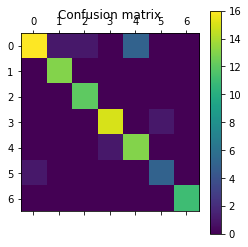

---------------------------------------------
Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] max_depth=10, max_features=512, min_samples_leaf=1 ..............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=10, max_features=512, min_samples_leaf=1, total=  10.9s
[CV] max_depth=10, max_features=512, min_samples_leaf=1 ..............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.9s remaining:    0.0s


[CV]  max_depth=10, max_features=512, min_samples_leaf=1, total=  10.8s
[CV] max_depth=10, max_features=512, min_samples_leaf=1 ..............
[CV]  max_depth=10, max_features=512, min_samples_leaf=1, total=  10.8s
[CV] max_depth=10, max_features=512, min_samples_leaf=1 ..............
[CV]  max_depth=10, max_features=512, min_samples_leaf=1, total=  10.8s
[CV] max_depth=10, max_features=512, min_samples_leaf=1 ..............
[CV]  max_depth=10, max_features=512, min_samples_leaf=1, total=  10.8s
[CV] max_depth=10, max_features=512, min_samples_leaf=3 ..............
[CV]  max_depth=10, max_features=512, min_samples_leaf=3, total=  10.5s
[CV] max_depth=10, max_features=512, min_samples_leaf=3 ..............
[CV]  max_depth=10, max_features=512, min_samples_leaf=3, total=  10.4s
[CV] max_depth=10, max_features=512, min_samples_leaf=3 ..............
[CV]  max_depth=10, max_features=512, min_samples_leaf=3, total=  10.4s
[CV] max_depth=10, max_features=512, min_samples_leaf=3 ..............

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:  8.3min finished


---------------------------------------------
best parameter : {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 5}
best score : 0.9073152548690709
Score accuracy test =  0.9157894736842105
[[16  0  0  2  5  0  0]
 [ 0 13  0  0  0  0  0]
 [ 0  0 12  0  0  0  0]
 [ 0  0  0 15  0  1  0]
 [ 0  0  0  0 14  0  0]
 [ 0  0  0  0  0  6  0]
 [ 0  0  0  0  0  0 11]]


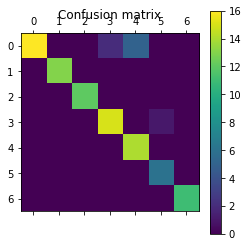

---------------------------------------------
Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] max_depth=10, max_features=512, min_samples_leaf=1 ..............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=10, max_features=512, min_samples_leaf=1, total=  10.8s
[CV] max_depth=10, max_features=512, min_samples_leaf=1 ..............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.8s remaining:    0.0s


[CV]  max_depth=10, max_features=512, min_samples_leaf=1, total=  10.8s
[CV] max_depth=10, max_features=512, min_samples_leaf=1 ..............
[CV]  max_depth=10, max_features=512, min_samples_leaf=1, total=  10.9s
[CV] max_depth=10, max_features=512, min_samples_leaf=1 ..............
[CV]  max_depth=10, max_features=512, min_samples_leaf=1, total=  10.7s
[CV] max_depth=10, max_features=512, min_samples_leaf=1 ..............
[CV]  max_depth=10, max_features=512, min_samples_leaf=1, total=  10.8s
[CV] max_depth=10, max_features=512, min_samples_leaf=3 ..............
[CV]  max_depth=10, max_features=512, min_samples_leaf=3, total=  10.4s
[CV] max_depth=10, max_features=512, min_samples_leaf=3 ..............
[CV]  max_depth=10, max_features=512, min_samples_leaf=3, total=  10.6s
[CV] max_depth=10, max_features=512, min_samples_leaf=3 ..............
[CV]  max_depth=10, max_features=512, min_samples_leaf=3, total=  10.3s
[CV] max_depth=10, max_features=512, min_samples_leaf=3 ..............

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:  8.3min finished


---------------------------------------------
best parameter : {'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 1}
best score : 0.9100270245084335
Score accuracy test =  0.9157894736842105
[[17  0  0  2  4  0  0]
 [ 0 13  0  0  0  0  0]
 [ 0  0 12  0  0  0  0]
 [ 0  0  0 16  0  0  0]
 [ 0  0  0  1 13  0  0]
 [ 1  0  0  0  0  5  0]
 [ 0  0  0  0  0  0 11]]


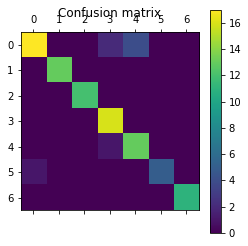

---------------------------------------------
Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] max_depth=10, max_features=512, min_samples_leaf=1 ..............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=10, max_features=512, min_samples_leaf=1, total=  10.8s
[CV] max_depth=10, max_features=512, min_samples_leaf=1 ..............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.8s remaining:    0.0s


[CV]  max_depth=10, max_features=512, min_samples_leaf=1, total=  10.7s
[CV] max_depth=10, max_features=512, min_samples_leaf=1 ..............
[CV]  max_depth=10, max_features=512, min_samples_leaf=1, total=  10.8s
[CV] max_depth=10, max_features=512, min_samples_leaf=1 ..............
[CV]  max_depth=10, max_features=512, min_samples_leaf=1, total=  11.1s
[CV] max_depth=10, max_features=512, min_samples_leaf=1 ..............
[CV]  max_depth=10, max_features=512, min_samples_leaf=1, total=  11.0s
[CV] max_depth=10, max_features=512, min_samples_leaf=3 ..............
[CV]  max_depth=10, max_features=512, min_samples_leaf=3, total=  10.5s
[CV] max_depth=10, max_features=512, min_samples_leaf=3 ..............
[CV]  max_depth=10, max_features=512, min_samples_leaf=3, total=  10.4s
[CV] max_depth=10, max_features=512, min_samples_leaf=3 ..............
[CV]  max_depth=10, max_features=512, min_samples_leaf=3, total=  10.3s
[CV] max_depth=10, max_features=512, min_samples_leaf=3 ..............

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:  8.3min finished


---------------------------------------------
best parameter : {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1}
best score : 0.9073432112571055
Score accuracy test =  0.9052631578947369
[[16  0  2  0  5  0  0]
 [ 0 13  0  0  0  0  0]
 [ 0  0 12  0  0  0  0]
 [ 0  0  0 15  1  0  0]
 [ 1  0  0  0 13  0  0]
 [ 0  0  0  0  0  6  0]
 [ 0  0  0  0  0  0 11]]


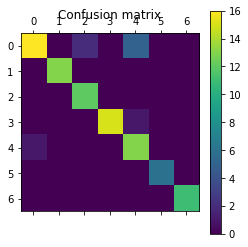

---------------------------------------------
Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] max_depth=10, max_features=512, min_samples_leaf=1 ..............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=10, max_features=512, min_samples_leaf=1, total=  10.8s
[CV] max_depth=10, max_features=512, min_samples_leaf=1 ..............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.8s remaining:    0.0s


[CV]  max_depth=10, max_features=512, min_samples_leaf=1, total=  10.7s
[CV] max_depth=10, max_features=512, min_samples_leaf=1 ..............
[CV]  max_depth=10, max_features=512, min_samples_leaf=1, total=  10.9s
[CV] max_depth=10, max_features=512, min_samples_leaf=1 ..............
[CV]  max_depth=10, max_features=512, min_samples_leaf=1, total=  10.9s
[CV] max_depth=10, max_features=512, min_samples_leaf=1 ..............
[CV]  max_depth=10, max_features=512, min_samples_leaf=1, total=  10.7s
[CV] max_depth=10, max_features=512, min_samples_leaf=3 ..............
[CV]  max_depth=10, max_features=512, min_samples_leaf=3, total=  10.3s
[CV] max_depth=10, max_features=512, min_samples_leaf=3 ..............
[CV]  max_depth=10, max_features=512, min_samples_leaf=3, total=  10.4s
[CV] max_depth=10, max_features=512, min_samples_leaf=3 ..............
[CV]  max_depth=10, max_features=512, min_samples_leaf=3, total=  10.4s
[CV] max_depth=10, max_features=512, min_samples_leaf=3 ..............

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:  8.3min finished


---------------------------------------------
best parameter : {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1}
best score : 0.9046221228217315
Score accuracy test =  0.9052631578947369
[[16  0  1  1  5  0  0]
 [ 0 13  0  0  0  0  0]
 [ 0  0 12  0  0  0  0]
 [ 0  0  0 15  0  1  0]
 [ 0  0  0  1 13  0  0]
 [ 0  0  0  0  0  6  0]
 [ 0  0  0  0  0  0 11]]


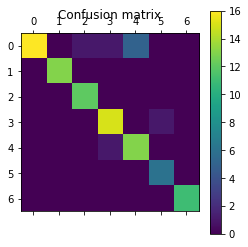

---------------------------------------------


In [ ]:
### BOUCLE
rfc_BERT, rfc_BERT_scor=RFclassification_boucle(corpus_embeddings_train,
                                         text_data_train['catego'],
                                         corpus_embeddings_test,
                                         text_data_test['catego'])

####Clustering BERT

In [ ]:
num_clusters = 7
clustering_model = KMeans(n_clusters=num_clusters)
clustering_model.fit(corpus_embeddings_train)
cluster_assignment = clustering_model.labels_

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


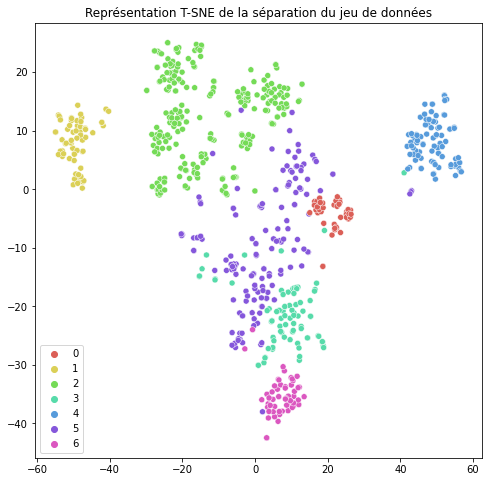

In [ ]:
tsne_pic = TSNE(n_components=2)
set_tsne = tsne_pic.fit_transform(corpus_embeddings_train.copy())

plt.figure(figsize=(8,8))
plt.title('Représentation T-SNE de la séparation du jeu de données')
sns.scatterplot(set_tsne[:,0],set_tsne[:,1],hue=cluster_assignment,
                legend='full', palette=sns.color_palette("hls",7))
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


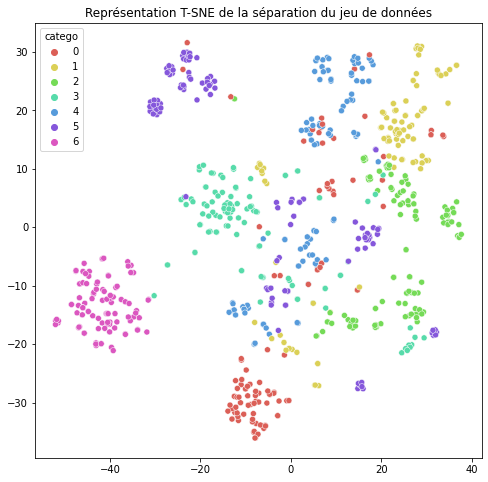

In [ ]:
#Comparaison avec le Tf-IDF
tsne_pic = TSNE(n_components=2)
set_tsne = tsne_pic.fit_transform(text_tfidf_train.toarray().copy())

plt.figure(figsize=(8,8))
plt.title('Représentation T-SNE de la séparation du jeu de données')
sns.scatterplot(set_tsne[:,0],set_tsne[:,1],hue=text_data_train['catego'],
                legend='full', palette=sns.color_palette("hls",7))
plt.show()

##Comparaison des résultats de classification RF pour le texte

In [ ]:
result_rfc=pd.DataFrame()
result_rfc['method']=['BoW','TF-idf','Word2Vac','BERT']
result_rfc['Score accurancy']=[rfc_bow_scor,rfc_tfidf_scor,rfc_w2v_scor,rfc_BERT_scor]
result_rfc

## Recherche de topics (non sup)

###NMF

In [ ]:
def display_topics(mod, feature_names, no_top_words):
    for topic_idx, topic in enumerate(mod.components_):
        print("Topic {}:".format(topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [ ]:
nmf = NMF(n_components=7,
          random_state=1, 
          alpha=.1, 
          l1_ratio=.5, 
          init='nndsvd')

nmf.fit(text_tfidf_train)

display_topics(nmf, tfidf_vect.get_feature_names(), 10)

Topic 0:
com flipkart cash genuine shipping delivery buy product guarantee replacement
Topic 1:
watch analog men discount india woman dial strap guarantee replacement
Topic 2:
baby detail girl fabric cotton boy sleeve pack dress pattern
Topic 3:
mug coffee prithish gift rockmantra loved design tea microwave material
Topic 4:
showpiece guarantee replacement day price genuine cash shipping delivery buy
Topic 5:
laptop battery cell pavilion lapguard warranty mouse rega shape pad
Topic 6:
towel bath cotton hand absorbent face buy yellow genuine shipping


###LDA

In [ ]:
lda = LatentDirichletAllocation(
        n_components=7, 
        max_iter=5, 
        learning_method='online', 
        learning_offset=50.,
        random_state=0)

# Fitter sur les données
lda.fit(text_tfidf_train)

display_topics(lda, tfidf_vect.get_feature_names(), 10)

Topic 0:
towel adapter bath vaio vgn cre cotton absorbent smartpro warranty
Topic 1:
curtain eyelet polyester door aroma comfort design height window art
Topic 2:
mug coffee prithish usb rockmantra gift loved design pizza material
Topic 3:
baby cotton girl detail pack fabric color type specification feature
Topic 4:
laptop warranty battery pot print mouse quality pad shape bottle
Topic 5:
com flipkart genuine cash shipping delivery buy product guarantee replacement
Topic 6:
duvet quilt bed exquisite velvet decor ensure crafted provide designed


#Classification de textes et images

##Récupération des Features CNN 

In [ ]:
### Récupération de la sortie du modèle MobileNetV2 (sans couche dense) pour les images

In [ ]:
#Fonction pour récupérer le file_path d'un batch d'images

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np

from tensorflow.python.data.ops import dataset_ops
from tensorflow.python.keras.layers.preprocessing import image_preprocessing
from tensorflow.python.keras.preprocessing import dataset_utils
from tensorflow.python.ops import image_ops
from tensorflow.python.ops import io_ops
from tensorflow.python.util.tf_export import keras_export

WHITELIST_FORMATS = ('.bmp', '.gif', '.jpeg', '.jpg', '.png')

## Tensorflow override method to return fname as list as well as dataset

def image_dataset_from_directory(directory,
                                 labels='inferred',
                                 label_mode='int',
                                 class_names=None,
                                 color_mode='rgb',
                                 batch_size=32,
                                 image_size=(256, 256),
                                 shuffle=True,
                                 seed=None,
                                 validation_split=None,
                                 subset=None,
                                 interpolation='bilinear',
                                 follow_links=False):
  if labels != 'inferred':
    if not isinstance(labels, (list, tuple)):
      raise ValueError(
          '`labels` argument should be a list/tuple of integer labels, of '
          'the same size as the number of image files in the target '
          'directory. If you wish to infer the labels from the subdirectory '
          'names in the target directory, pass `labels="inferred"`. '
          'If you wish to get a dataset that only contains images '
          '(no labels), pass `label_mode=None`.')
    if class_names:
      raise ValueError('You can only pass `class_names` if the labels are '
                       'inferred from the subdirectory names in the target '
                       'directory (`labels="inferred"`).')
  if label_mode not in {'int', 'categorical', 'binary', None}:
    raise ValueError(
        '`label_mode` argument must be one of "int", "categorical", "binary", '
        'or None. Received: %s' % (label_mode,))
  if color_mode == 'rgb':
    num_channels = 3
  elif color_mode == 'rgba':
    num_channels = 4
  elif color_mode == 'grayscale':
    num_channels = 1
  else:
    raise ValueError(
        '`color_mode` must be one of {"rbg", "rgba", "grayscale"}. '
        'Received: %s' % (color_mode,))
  interpolation = image_preprocessing.get_interpolation(interpolation)
  dataset_utils.check_validation_split_arg(
      validation_split, subset, shuffle, seed)  

  if seed is None:
    seed = np.random.randint(1e6)
  image_paths, labels, class_names = dataset_utils.index_directory(
      directory,
      labels,
      formats=WHITELIST_FORMATS,
      class_names=class_names,
      shuffle=shuffle,
      seed=seed,
      follow_links=follow_links)

  if label_mode == 'binary' and len(class_names) != 2:
    raise ValueError(
        'When passing `label_mode="binary", there must exactly 2 classes. '
        'Found the following classes: %s' % (class_names,))

  image_paths, labels = dataset_utils.get_training_or_validation_split(
      image_paths, labels, validation_split, subset)

  dataset = paths_and_labels_to_dataset(
      image_paths=image_paths,
      image_size=image_size,
      num_channels=num_channels,
      labels=labels,
      label_mode=label_mode,
      num_classes=len(class_names),
      interpolation=interpolation)
  if shuffle:
    # Shuffle locally at each iteration
    dataset = dataset.shuffle(buffer_size=batch_size * 8, seed=seed)
  dataset = dataset.batch(batch_size)
  # Users may need to reference `class_names`.
  dataset.class_names = class_names
  return dataset, image_paths

def paths_and_labels_to_dataset(image_paths,
                                image_size,
                                num_channels,
                                labels,
                                label_mode,
                                num_classes,
                                interpolation):
  """Constructs a dataset of images and labels."""
  
  path_ds = dataset_ops.Dataset.from_tensor_slices(image_paths)
  img_ds = path_ds.map(
      lambda x: path_to_image(x, image_size, num_channels, interpolation))
  if label_mode:
    label_ds = dataset_utils.labels_to_dataset(labels, label_mode, num_classes)
    img_ds = dataset_ops.Dataset.zip((img_ds, label_ds))
  return img_ds

def path_to_image(path, image_size, num_channels, interpolation):
  img = io_ops.read_file(path)
  img = image_ops.decode_image(
      img, channels=num_channels, expand_animations=False)
  img = image_ops.resize_images_v2(img, image_size, method=interpolation)
  img.set_shape((image_size[0], image_size[1], num_channels))
  return img

In [ ]:
#Train
train_dir = 'Images_train/'
BATCH_SIZE = len(set_train['image'])
IMG_SIZE = (160, 160)

img_dataset_train, img_paths_train = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

#Test
train_dir = 'Images_test_stack/'
BATCH_SIZE = len(set_test_stack['image'])
IMG_SIZE = (160, 160)

img_dataset_test, img_paths_test = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 734 files belonging to 7 classes.
Found 95 files belonging to 7 classes.


In [ ]:
#retrait de la couche dense du model
model_CNN = Sequential()
for layer in model_mnv2.layers[:-1]: # just exclude last layer from copying
  model_CNN.add(layer)
for layer in model_CNN.layers:
  layer.trainable = False

In [ ]:
#Output Train
name_predic_vec_train= model_CNN.predict(img_dataset_train)

# ACP
pca = PCA()
des_ss = StandardScaler() 
outputnon_sup_ss_train=des_ss.fit_transform(name_predic_vec_train)
pca.fit(outputnon_sup_ss_train)
CNN_reduit_train = pca.transform(name_predic_vec_train)[:,:300]
print(np.cumsum(pca.explained_variance_ratio_)[300])

set_predict_modilnet_train=pd.DataFrame(CNN_reduit_train)

list_img_name=[]
for t in range(len(img_paths_train)):
  list_img_name.append(img_paths_train[t][15:52])#ne garde que le nom de l'image 

set_predict_modilnet_train['image']=list_img_name

test_set_data_train=set_train.copy()
set_merge_train=pd.merge(test_set_data_train,set_predict_modilnet_train)#merge sur le nom de l'image

#Output Test
name_predic_vec_test= model_CNN.predict(img_dataset_test)

# ACP
CNN_reduit_test = pca.transform(name_predic_vec_test)[:,:300]
print(np.cumsum(pca.explained_variance_ratio_)[300])

set_predict_modilnet_test=pd.DataFrame(CNN_reduit_test)

list_img_name=[]
for t in range(len(img_paths_test)):
  list_img_name.append(img_paths_test[t][20:57])#ne garde que le nom de l'image 

set_predict_modilnet_test['image']=list_img_name

test_set_data_test=set_test_stack.copy()
set_merge_test=pd.merge(test_set_data_test,set_predict_modilnet_test)#merge sur le nom de l'image

##Récupération des features NLP

In [ ]:
### Chargement des feature NLP
feat_nlp_train = set_tfidf_train.copy().drop(['catego'],axis=1)
feat_nlp_test = set_tfidf_test.copy().drop(['catego'],axis=1)

# Train
pca_nlp = PCA()
des_ss_nlp = StandardScaler()
nlp_ss_train=des_ss_nlp.fit_transform(feat_nlp_train)
pca_nlp.fit(nlp_ss_train)
nlp_reduit_vec_train = pca_nlp.transform(feat_nlp_train)[:,:300]
NLP_reduit_train=pd.DataFrame(nlp_reduit_vec_train)
print(np.cumsum(pca_nlp.explained_variance_ratio_)[300])

# Test
nlp_reduit_vec_test = pca_nlp.transform(feat_nlp_test)[:,:300]
NLP_reduit_test=pd.DataFrame(nlp_reduit_vec_test)
print(np.cumsum(pca_nlp.explained_variance_ratio_)[300])

In [ ]:
set_nlp_cnn_train=pd.concat([set_merge_train,NLP_reduit_train],axis=1)
set_nlp_cnn_test=pd.concat([set_merge_test,NLP_reduit_test],axis=1)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] max_depth=10, max_features=600, min_samples_leaf=1 ..............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=10, max_features=600, min_samples_leaf=1, total=  12.3s
[CV] max_depth=10, max_features=600, min_samples_leaf=1 ..............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.3s remaining:    0.0s


[CV]  max_depth=10, max_features=600, min_samples_leaf=1, total=  12.3s
[CV] max_depth=10, max_features=600, min_samples_leaf=1 ..............
[CV]  max_depth=10, max_features=600, min_samples_leaf=1, total=  12.2s
[CV] max_depth=10, max_features=600, min_samples_leaf=1 ..............
[CV]  max_depth=10, max_features=600, min_samples_leaf=1, total=  12.4s
[CV] max_depth=10, max_features=600, min_samples_leaf=1 ..............
[CV]  max_depth=10, max_features=600, min_samples_leaf=1, total=  12.3s
[CV] max_depth=10, max_features=600, min_samples_leaf=3 ..............
[CV]  max_depth=10, max_features=600, min_samples_leaf=3, total=  11.8s
[CV] max_depth=10, max_features=600, min_samples_leaf=3 ..............
[CV]  max_depth=10, max_features=600, min_samples_leaf=3, total=  11.8s
[CV] max_depth=10, max_features=600, min_samples_leaf=3 ..............
[CV]  max_depth=10, max_features=600, min_samples_leaf=3, total=  11.7s
[CV] max_depth=10, max_features=600, min_samples_leaf=3 ..............

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:  9.4min finished


---------------------------------------------
best parameter : {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 3}
best score : 0.8936911751001769
Score accuracy test =  0.9263157894736842
[[17  0  0  2  4  0  0]
 [ 0 13  0  0  0  0  0]
 [ 0  0 11  0  1  0  0]
 [ 0  0  0 16  0  0  0]
 [ 0  0  0  0 14  0  0]
 [ 0  0  0  0  0  6  0]
 [ 0  0  0  0  0  0 11]]


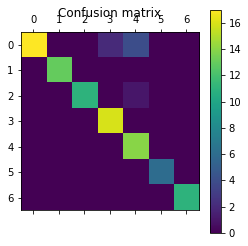

---------------------------------------------


In [ ]:
rfc_nlp_cnn,rfc_nlp_cnn_scor=RFclassification(set_nlp_cnn_train.drop(['image','description','catego'],axis=1),
                                              set_nlp_cnn_train['catego'],
                                              set_nlp_cnn_test.drop(['image','description','catego'],axis=1),
                                              set_nlp_cnn_test['catego'])

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] max_depth=10, max_features=600, min_samples_leaf=1 ..............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=10, max_features=600, min_samples_leaf=1, total=  12.6s
[CV] max_depth=10, max_features=600, min_samples_leaf=1 ..............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.6s remaining:    0.0s


[CV]  max_depth=10, max_features=600, min_samples_leaf=1, total=  12.5s
[CV] max_depth=10, max_features=600, min_samples_leaf=1 ..............
[CV]  max_depth=10, max_features=600, min_samples_leaf=1, total=  12.9s
[CV] max_depth=10, max_features=600, min_samples_leaf=1 ..............
[CV]  max_depth=10, max_features=600, min_samples_leaf=1, total=  13.0s
[CV] max_depth=10, max_features=600, min_samples_leaf=1 ..............
[CV]  max_depth=10, max_features=600, min_samples_leaf=1, total=  13.3s
[CV] max_depth=10, max_features=600, min_samples_leaf=3 ..............
[CV]  max_depth=10, max_features=600, min_samples_leaf=3, total=  12.9s
[CV] max_depth=10, max_features=600, min_samples_leaf=3 ..............
[CV]  max_depth=10, max_features=600, min_samples_leaf=3, total=  12.3s
[CV] max_depth=10, max_features=600, min_samples_leaf=3 ..............
[CV]  max_depth=10, max_features=600, min_samples_leaf=3, total=  12.1s
[CV] max_depth=10, max_features=600, min_samples_leaf=3 ..............

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:  9.6min finished


---------------------------------------------
best parameter : {'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 1}
best score : 0.8896374988351505
Score accuracy test =  0.9157894736842105
[[16  0  0  3  4  0  0]
 [ 0 13  0  0  0  0  0]
 [ 0  0 12  0  0  0  0]
 [ 0  0  0 16  0  0  0]
 [ 1  0  0  0 13  0  0]
 [ 0  0  0  0  0  6  0]
 [ 0  0  0  0  0  0 11]]


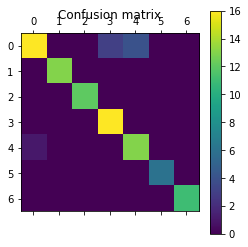

---------------------------------------------
Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] max_depth=10, max_features=600, min_samples_leaf=1 ..............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=10, max_features=600, min_samples_leaf=1, total=  12.2s
[CV] max_depth=10, max_features=600, min_samples_leaf=1 ..............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.2s remaining:    0.0s


[CV]  max_depth=10, max_features=600, min_samples_leaf=1, total=  12.4s
[CV] max_depth=10, max_features=600, min_samples_leaf=1 ..............
[CV]  max_depth=10, max_features=600, min_samples_leaf=1, total=  12.3s
[CV] max_depth=10, max_features=600, min_samples_leaf=1 ..............
[CV]  max_depth=10, max_features=600, min_samples_leaf=1, total=  12.5s
[CV] max_depth=10, max_features=600, min_samples_leaf=1 ..............
[CV]  max_depth=10, max_features=600, min_samples_leaf=1, total=  12.4s
[CV] max_depth=10, max_features=600, min_samples_leaf=3 ..............
[CV]  max_depth=10, max_features=600, min_samples_leaf=3, total=  11.8s
[CV] max_depth=10, max_features=600, min_samples_leaf=3 ..............
[CV]  max_depth=10, max_features=600, min_samples_leaf=3, total=  11.9s
[CV] max_depth=10, max_features=600, min_samples_leaf=3 ..............
[CV]  max_depth=10, max_features=600, min_samples_leaf=3, total=  12.0s
[CV] max_depth=10, max_features=600, min_samples_leaf=3 ..............

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:  9.5min finished


---------------------------------------------
best parameter : {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1}
best score : 0.8964215823315629
Score accuracy test =  0.9052631578947369
[[17  0  0  2  4  0  0]
 [ 0 13  0  0  0  0  0]
 [ 0  0 11  1  0  0  0]
 [ 0  0  0 16  0  0  0]
 [ 1  0  0  1 12  0  0]
 [ 0  0  0  0  0  6  0]
 [ 0  0  0  0  0  0 11]]


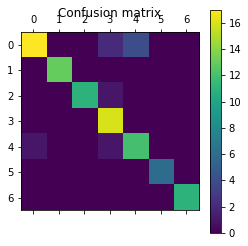

---------------------------------------------
Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] max_depth=10, max_features=600, min_samples_leaf=1 ..............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=10, max_features=600, min_samples_leaf=1, total=  12.2s
[CV] max_depth=10, max_features=600, min_samples_leaf=1 ..............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.2s remaining:    0.0s


[CV]  max_depth=10, max_features=600, min_samples_leaf=1, total=  12.3s
[CV] max_depth=10, max_features=600, min_samples_leaf=1 ..............
[CV]  max_depth=10, max_features=600, min_samples_leaf=1, total=  12.5s
[CV] max_depth=10, max_features=600, min_samples_leaf=1 ..............
[CV]  max_depth=10, max_features=600, min_samples_leaf=1, total=  12.5s
[CV] max_depth=10, max_features=600, min_samples_leaf=1 ..............
[CV]  max_depth=10, max_features=600, min_samples_leaf=1, total=  12.5s
[CV] max_depth=10, max_features=600, min_samples_leaf=3 ..............
[CV]  max_depth=10, max_features=600, min_samples_leaf=3, total=  11.9s
[CV] max_depth=10, max_features=600, min_samples_leaf=3 ..............
[CV]  max_depth=10, max_features=600, min_samples_leaf=3, total=  11.9s
[CV] max_depth=10, max_features=600, min_samples_leaf=3 ..............
[CV]  max_depth=10, max_features=600, min_samples_leaf=3, total=  11.7s
[CV] max_depth=10, max_features=600, min_samples_leaf=3 ..............

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:  9.5min finished


---------------------------------------------
best parameter : {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1}
best score : 0.8936911751001771
Score accuracy test =  0.9157894736842105
[[17  0  0  3  3  0  0]
 [ 0 13  0  0  0  0  0]
 [ 0  0 11  1  0  0  0]
 [ 0  0  0 16  0  0  0]
 [ 1  0  0  0 13  0  0]
 [ 0  0  0  0  0  6  0]
 [ 0  0  0  0  0  0 11]]


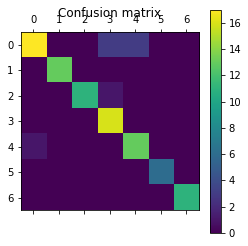

---------------------------------------------
Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] max_depth=10, max_features=600, min_samples_leaf=1 ..............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=10, max_features=600, min_samples_leaf=1, total=  12.3s
[CV] max_depth=10, max_features=600, min_samples_leaf=1 ..............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.3s remaining:    0.0s


[CV]  max_depth=10, max_features=600, min_samples_leaf=1, total=  12.5s
[CV] max_depth=10, max_features=600, min_samples_leaf=1 ..............
[CV]  max_depth=10, max_features=600, min_samples_leaf=1, total=  12.2s
[CV] max_depth=10, max_features=600, min_samples_leaf=1 ..............
[CV]  max_depth=10, max_features=600, min_samples_leaf=1, total=  12.3s
[CV] max_depth=10, max_features=600, min_samples_leaf=1 ..............
[CV]  max_depth=10, max_features=600, min_samples_leaf=1, total=  12.3s
[CV] max_depth=10, max_features=600, min_samples_leaf=3 ..............
[CV]  max_depth=10, max_features=600, min_samples_leaf=3, total=  11.8s
[CV] max_depth=10, max_features=600, min_samples_leaf=3 ..............
[CV]  max_depth=10, max_features=600, min_samples_leaf=3, total=  11.8s
[CV] max_depth=10, max_features=600, min_samples_leaf=3 ..............
[CV]  max_depth=10, max_features=600, min_samples_leaf=3, total=  11.8s
[CV] max_depth=10, max_features=600, min_samples_leaf=3 ..............

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:  9.5min finished


---------------------------------------------
best parameter : {'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 1}
best score : 0.89233063088249
Score accuracy test =  0.9052631578947369
[[16  0  0  3  4  0  0]
 [ 0 13  0  0  0  0  0]
 [ 1  0 10  1  0  0  0]
 [ 0  0  0 16  0  0  0]
 [ 0  0  0  0 14  0  0]
 [ 0  0  0  0  0  6  0]
 [ 0  0  0  0  0  0 11]]


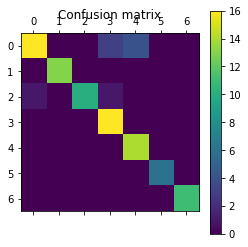

---------------------------------------------
Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] max_depth=10, max_features=600, min_samples_leaf=1 ..............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=10, max_features=600, min_samples_leaf=1, total=  12.4s
[CV] max_depth=10, max_features=600, min_samples_leaf=1 ..............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.4s remaining:    0.0s


[CV]  max_depth=10, max_features=600, min_samples_leaf=1, total=  12.6s
[CV] max_depth=10, max_features=600, min_samples_leaf=1 ..............
[CV]  max_depth=10, max_features=600, min_samples_leaf=1, total=  12.3s
[CV] max_depth=10, max_features=600, min_samples_leaf=1 ..............
[CV]  max_depth=10, max_features=600, min_samples_leaf=1, total=  12.5s
[CV] max_depth=10, max_features=600, min_samples_leaf=1 ..............
[CV]  max_depth=10, max_features=600, min_samples_leaf=1, total=  12.4s
[CV] max_depth=10, max_features=600, min_samples_leaf=3 ..............
[CV]  max_depth=10, max_features=600, min_samples_leaf=3, total=  11.8s
[CV] max_depth=10, max_features=600, min_samples_leaf=3 ..............
[CV]  max_depth=10, max_features=600, min_samples_leaf=3, total=  11.8s
[CV] max_depth=10, max_features=600, min_samples_leaf=3 ..............
[CV]  max_depth=10, max_features=600, min_samples_leaf=3, total=  11.8s
[CV] max_depth=10, max_features=600, min_samples_leaf=3 ..............

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:  9.5min finished


---------------------------------------------
best parameter : {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1}
best score : 0.8964309011275743
Score accuracy test =  0.9052631578947369
[[17  0  0  3  3  0  0]
 [ 0 13  0  0  0  0  0]
 [ 0  0 11  1  0  0  0]
 [ 0  0  0 15  1  0  0]
 [ 1  0  0  0 13  0  0]
 [ 0  0  0  0  0  6  0]
 [ 0  0  0  0  0  0 11]]


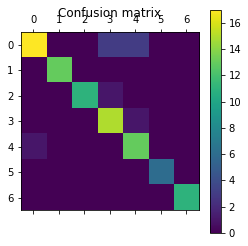

---------------------------------------------


In [ ]:
### BOUCLE
rfc_nlp_cnn,rfc_nlp_cnn_scor=RFclassification_boucle(set_nlp_cnn_train.drop(['image','description','catego'],axis=1),
                                              set_nlp_cnn_train['catego'],
                                              set_nlp_cnn_test.drop(['image','description','catego'],axis=1),
                                              set_nlp_cnn_test['catego'])

#Stacking

## proba Model CNN

In [ ]:
train_dir = 'Images_train/'
BATCH_SIZE = len(set_train['image'])
IMG_SIZE = (160, 160)

img_dataset_train, img_paths_train = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

# Couche d'augmentation des données
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

# Couche de formatages des images
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

#Chargement du model MobileNetV2
IMG_SIZE = (160, 160)
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

#Freeze des couches profondes
base_model.trainable = False

# Couche de réduction dimentionnelle pour approche non sup
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

# Couche de prédiction (7 sorties)
prediction_layer = tf.keras.layers.Dense(7,activation='softmax')

# Construction du modèle
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model_mnv2_stack = tf.keras.Model(inputs, outputs)

# Compilation du modèle
model_mnv2_stack.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

# Callback
stacking_callbacks = [
                
    keras.callbacks.EarlyStopping(
        monitor="loss",
        min_delta=1e-3,
        patience=5,
        verbose=1,),
  ]

# Entrainement du modèle sur le set de train
history_stack = model_mnv2_stack.fit(img_dataset_train,epochs=80,callbacks=[stacking_callbacks])


### Récupération des proba du set de validation

creat_img_folder (set_val['image'],set_val['catego'],'val')

train_dir = 'Images_val/'
BATCH_SIZE = len(set_val['image'])
IMG_SIZE = (160, 160)

img_dataset_val, img_paths_val = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

#prediction sur le set de validation
predic_val= model_mnv2_stack.predict(img_dataset_val)

set_predict_val=pd.DataFrame(predic_val,columns=['CNN_0','CNN_1','CNN_2','CNN_3','CNN_4','CNN_5','CNN_6'])

list_img_name=[]
for t in range(len(img_paths_val)):
  list_img_name.append(img_paths_val[t][13:50])#ne garde que le nom de l'image

set_predict_val['image']=list_img_name

set_val=pd.merge(set_val,set_predict_val)#merge sur le nom de l'image
set_val.head()

Found 734 files belonging to 7 classes.
Epoch 1/80
1/1 [==============================] - 0s 2ms/step - loss: 2.3659 - accuracy: 0.1689
Epoch 2/80
1/1 [==============================] - 0s 1ms/step - loss: 2.1343 - accuracy: 0.2275
Epoch 3/80
1/1 [==============================] - 0s 1ms/step - loss: 2.0109 - accuracy: 0.2698
Epoch 4/80
1/1 [==============================] - 0s 1ms/step - loss: 1.7951 - accuracy: 0.3283
Epoch 5/80
1/1 [==============================] - 0s 1ms/step - loss: 1.7030 - accuracy: 0.3733
Epoch 6/80
1/1 [==============================] - 0s 4ms/step - loss: 1.5793 - accuracy: 0.4537
Epoch 7/80
1/1 [==============================] - 0s 1ms/step - loss: 1.4787 - accuracy: 0.4687
Epoch 8/80
1/1 [==============================] - 0s 1ms/step - loss: 1.4326 - accuracy: 0.5150
Epoch 9/80
1/1 [==============================] - 0s 1ms/step - loss: 1.3030 - accuracy: 0.5490
Epoch 10/80
1/1 [==============================] - 0s 2ms/step - loss: 1.2546 - accuracy: 0.5708

image  ...     CNN_6
0  cdc33ed715261b08e315a2a19427bc23.jpg  ...  0.000130
1  159b45e4dede207f28319bf1cacee3bc.jpg  ...  0.012448
2  285075cfac3036e8d51591dfe5ba24ab.jpg  ...  0.000808
3  b5834f1e97c74d2833dbcb09a3f27926.jpg  ...  0.000089
4  7616c21074fe889defce033dcd0d7cb6.jpg  ...  0.009740

[5 rows x 10 columns]

##Proba model NLP

In [ ]:
string_list_train, set_clean_train_stack = clean_nlp (set_train)

In [ ]:
tfidf_vect_train = TfidfVectorizer(
                    analyzer='word',
                    max_df=0.65,
                    min_df=3
                    )

text_tfidf_train = tfidf_vect_train.fit_transform(string_list_train)

set_tfidf_train = pd.DataFrame(text_tfidf_train.toarray(), columns=tfidf_vect_train.get_feature_names())
set_tfidf_train['catego']=list(set_train['catego'])
set_tfidf_train.head()

absorbent  abstract  accessory  act  ...  yardley      year  yellow  catego
0        0.0       0.0        0.0  0.0  ...      0.0  0.000000     0.0       1
1        0.0       0.0        0.0  0.0  ...      0.0  0.000000     0.0       0
2        0.0       0.0        0.0  0.0  ...      0.0  0.000000     0.0       2
3        0.0       0.0        0.0  0.0  ...      0.0  0.000000     0.0       2
4        0.0       0.0        0.0  0.0  ...      0.0  0.200237     0.0       5

[5 rows x 889 columns]

In [ ]:
X_train=set_tfidf_train.drop('catego',axis=1)
y_train=set_tfidf_train['catego']

# Modélisation RFC
n_featur = X_train.shape[1]

param = {
    
    'max_depth' : [10,20,50], 
    'min_samples_leaf' : [1,3,5], 
    'max_features': [n_featur, 'sqrt'] 
    }

rfc_tfidf_train = GridSearchCV(RandomForestClassifier(),
                              param_grid = param,
                              scoring='accuracy',
                              verbose=2,
                              cv=5)

rfc_tfidf_train.fit(X_train, y_train)
print('-'*45)
print('best parameter :', rfc_tfidf_train.best_params_)
print('best score :', rfc_tfidf_train.best_score_)


Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] max_depth=10, max_features=888, min_samples_leaf=1 ..............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=10, max_features=888, min_samples_leaf=1, total=   1.3s
[CV] max_depth=10, max_features=888, min_samples_leaf=1 ..............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s


[CV]  max_depth=10, max_features=888, min_samples_leaf=1, total=   1.2s
[CV] max_depth=10, max_features=888, min_samples_leaf=1 ..............
[CV]  max_depth=10, max_features=888, min_samples_leaf=1, total=   1.2s
[CV] max_depth=10, max_features=888, min_samples_leaf=1 ..............
[CV]  max_depth=10, max_features=888, min_samples_leaf=1, total=   1.2s
[CV] max_depth=10, max_features=888, min_samples_leaf=1 ..............
[CV]  max_depth=10, max_features=888, min_samples_leaf=1, total=   1.2s
[CV] max_depth=10, max_features=888, min_samples_leaf=3 ..............
[CV]  max_depth=10, max_features=888, min_samples_leaf=3, total=   1.2s
[CV] max_depth=10, max_features=888, min_samples_leaf=3 ..............
[CV]  max_depth=10, max_features=888, min_samples_leaf=3, total=   1.1s
[CV] max_depth=10, max_features=888, min_samples_leaf=3 ..............
[CV]  max_depth=10, max_features=888, min_samples_leaf=3, total=   1.2s
[CV] max_depth=10, max_features=888, min_samples_leaf=3 ..............

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:  1.1min finished


---------------------------------------------
best parameter : {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1}
best score : 0.9237163358494083


In [ ]:
# Prédiction sur le set de validation

#Clean des description 
string_list_val, set_clean_val = clean_nlp (set_val)

#prédiction des proba 
predict_nlp_val=rfc_tfidf_train.predict_proba(tfidf_vect_train.transform(string_list_val))

#fusion avec les sorties CNN
set_predict_nlp_val=pd.DataFrame(predict_nlp_val,columns=['NLP_0','NLP_1','NLP_2','NLP_3','NLP_4','NLP_5','NLP_6'])
set_predict_nlp_val['image']=set_val['image']
set_val_proba=pd.merge(set_val,set_predict_nlp_val)#merge sur le nom de l'image
set_val_proba.head()

image  ...     NLP_6
0  cdc33ed715261b08e315a2a19427bc23.jpg  ...  0.009467
1  159b45e4dede207f28319bf1cacee3bc.jpg  ...  0.011675
2  285075cfac3036e8d51591dfe5ba24ab.jpg  ...  0.001053
3  b5834f1e97c74d2833dbcb09a3f27926.jpg  ...  0.000627
4  7616c21074fe889defce033dcd0d7cb6.jpg  ...  0.919173

[5 rows x 17 columns]

##Model validation

In [ ]:
set_val_proba.head()

image  ...     NLP_6
0  cdc33ed715261b08e315a2a19427bc23.jpg  ...  0.009467
1  159b45e4dede207f28319bf1cacee3bc.jpg  ...  0.011675
2  285075cfac3036e8d51591dfe5ba24ab.jpg  ...  0.001053
3  b5834f1e97c74d2833dbcb09a3f27926.jpg  ...  0.000627
4  7616c21074fe889defce033dcd0d7cb6.jpg  ...  0.919173

[5 rows x 17 columns]

In [ ]:
X_train=set_val_proba.drop(['image','description','catego'],axis=1)
y_train=set_val_proba['catego']

# Modélisation RFC
n_featur = X_train.shape[1]

param = {
    
    'max_depth' : [10,20,50], #profondeur de l'arbre
    'min_samples_leaf' : [1,3,5], #nombre de feuilles minimales dans un noeud
    'max_features': [n_featur, 'sqrt'] #nombre de features observées pour chaque arbre
    }

rfc_stacking_val = GridSearchCV(RandomForestClassifier(),
                              param_grid = param,
                              scoring='accuracy',
                              verbose=2,
                              cv=5)

rfc_stacking_val.fit(X_train, y_train)
print('-'*45)
print('best parameter :', rfc_stacking_val.best_params_)
print('best score :', rfc_stacking_val.best_score_)


Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] max_depth=10, max_features=14, min_samples_leaf=1 ...............
[CV]  max_depth=10, max_features=14, min_samples_leaf=1, total=   0.2s
[CV] max_depth=10, max_features=14, min_samples_leaf=1 ...............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV]  max_depth=10, max_features=14, min_samples_leaf=1, total=   0.2s
[CV] max_depth=10, max_features=14, min_samples_leaf=1 ...............
[CV]  max_depth=10, max_features=14, min_samples_leaf=1, total=   0.2s
[CV] max_depth=10, max_features=14, min_samples_leaf=1 ...............
[CV]  max_depth=10, max_features=14, min_samples_leaf=1, total=   0.2s
[CV] max_depth=10, max_features=14, min_samples_leaf=1 ...............
[CV]  max_depth=10, max_features=14, min_samples_leaf=1, total=   0.2s
[CV] max_depth=10, max_features=14, min_samples_leaf=3 ...............
[CV]  max_depth=10, max_features=14, min_samples_leaf=3, total=   0.2s
[CV] max_depth=10, max_features=14, min_samples_leaf=3 ...............
[CV]  max_depth=10, max_features=14, min_samples_leaf=3, total=   0.2s
[CV] max_depth=10, max_features=14, min_samples_leaf=3 ...............
[CV]  max_depth=10, max_features=14, min_samples_leaf=3, total=   0.2s
[CV] max_depth=10, max_features=14, min_samples_leaf=3 ...............
[CV]  

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:   13.7s finished


##Prédiction sur le set de test

In [ ]:
### CNN_TEST
creat_img_folder (set_test_stack['image'],set_test_stack['catego'],'test_stack')

train_dir = 'Images_test_stack/'
BATCH_SIZE = len(set_test_stack['image'])
IMG_SIZE = (160, 160)

img_dataset_test_stack, img_paths_test_stack = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

#prediction
predic_test_stack= model_mnv2_stack.predict(img_dataset_test_stack)

set_predict_test_stack=pd.DataFrame(predic_test_stack,columns=['CNN_0','CNN_1','CNN_2','CNN_3','CNN_4','CNN_5','CNN_6'])

list_img_name=[]
for t in range(len(img_paths_test_stack)):
  list_img_name.append(img_paths_test_stack[t][20:57])#ne garde que le nom de l'image

set_predict_test_stack['image']=list_img_name

set_test_cnn=pd.merge(set_test_stack,set_predict_test_stack)#merge sur le nom de l'image
set_test_cnn.head()

Found 95 files belonging to 7 classes.


image  ...     CNN_6
0  ed1a2a831475966a779524ba67ae2ac7.jpg  ...  0.015467
1  b7214d4c357e3f7acae72fcbe7d31afe.jpg  ...  0.013177
2  8c62cbbd23958ae380fea906f6b5a994.jpg  ...  0.001868
3  1e15dbd9f59a8b2001f91d18ddc84b5a.jpg  ...  0.006051
4  f622e6c12de2c6534c94635f671af107.jpg  ...  0.000753

[5 rows x 10 columns]

In [ ]:
# Prédiction sur le set de test

#Clean des descriptions 
string_list_test, set_clean_test_stack = clean_nlp (set_test_cnn)

#prédiction des proba 
predict_nlp_test=rfc_tfidf_train.predict_proba(tfidf_vect_train.transform(string_list_test))

#fusion avec les sorties CNN
set_predict_nlp_test=pd.DataFrame(predict_nlp_test,columns=['NLP_0','NLP_1','NLP_2','NLP_3','NLP_4','NLP_5','NLP_6'])
set_predict_nlp_test['image']=set_test_cnn['image']
set_test_proba=pd.merge(set_test_cnn,set_predict_nlp_test)#merge sur le nom de l'image
set_test_proba.head()

image  ...     NLP_6
0  ed1a2a831475966a779524ba67ae2ac7.jpg  ...  0.000074
1  b7214d4c357e3f7acae72fcbe7d31afe.jpg  ...  0.006233
2  8c62cbbd23958ae380fea906f6b5a994.jpg  ...  0.000000
3  1e15dbd9f59a8b2001f91d18ddc84b5a.jpg  ...  1.000000
4  f622e6c12de2c6534c94635f671af107.jpg  ...  0.002211

[5 rows x 17 columns]

Score accuracy test =  0.9157894736842105
[[17  0  0  1  3  2  0]
 [ 0 13  0  0  0  0  0]
 [ 0  0 11  0  0  1  0]
 [ 0  0  0 15  0  1  0]
 [ 0  0  0  0 14  0  0]
 [ 0  0  0  0  0  6  0]
 [ 0  0  0  0  0  0 11]]


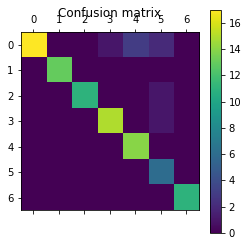

---------------------------------------------


In [ ]:
#Prédiction sur les proba set de test
X_cat=set_test_proba.drop(['image','description','catego'],axis=1)
y_cat=set_test_proba['catego']

catego_staking_test=rfc_stacking_val.predict(X_cat)

def showconfusionmatrix(cm):
      pl.matshow(cm)
      pl.title('Confusion matrix')
      pl.colorbar()
      pl.show()

rfc_stacking_scor = accuracy_score(y_cat, catego_staking_test)
print("Score accuracy test = ", rfc_stacking_scor)
cm = confusion_matrix(y_cat, catego_staking_test)
print (cm)

showconfusionmatrix(cm)
print('-'*45)

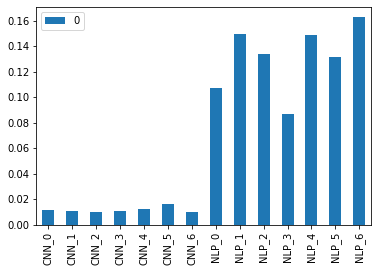

0
CNN_0  0.011322
CNN_1  0.010508
CNN_2  0.009889
CNN_3  0.010404
CNN_4  0.012084
CNN_5  0.015884
CNN_6  0.009841
NLP_0  0.106890
NLP_1  0.149838
NLP_2  0.134046
NLP_3  0.086703
NLP_4  0.148632
NLP_5  0.131306
NLP_6  0.162652

In [ ]:
#Importance des feature dans le stacking
feat_importance=pd.DataFrame(rfc_stacking_val.best_estimator_.feature_importances_,set_test_proba.drop(['image', 'description', 'catego'],axis=1).columns)
feat_importance.plot.bar()
plt.show()
feat_importance

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] max_depth=10, max_features=14, min_samples_leaf=1 ...............
[CV]  max_depth=10, max_features=14, min_samples_leaf=1, total=   0.2s
[CV] max_depth=10, max_features=14, min_samples_leaf=1 ...............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV]  max_depth=10, max_features=14, min_samples_leaf=1, total=   0.2s
[CV] max_depth=10, max_features=14, min_samples_leaf=1 ...............
[CV]  max_depth=10, max_features=14, min_samples_leaf=1, total=   0.2s
[CV] max_depth=10, max_features=14, min_samples_leaf=1 ...............
[CV]  max_depth=10, max_features=14, min_samples_leaf=1, total=   0.2s
[CV] max_depth=10, max_features=14, min_samples_leaf=1 ...............
[CV]  max_depth=10, max_features=14, min_samples_leaf=1, total=   0.2s
[CV] max_depth=10, max_features=14, min_samples_leaf=3 ...............
[CV]  max_depth=10, max_features=14, min_samples_leaf=3, total=   0.2s
[CV] max_depth=10, max_features=14, min_samples_leaf=3 ...............
[CV]  max_depth=10, max_features=14, min_samples_leaf=3, total=   0.2s
[CV] max_depth=10, max_features=14, min_samples_leaf=3 ...............
[CV]  max_depth=10, max_features=14, min_samples_leaf=3, total=   0.2s
[CV] max_depth=10, max_features=14, min_samples_leaf=3 ...............
[CV]  

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:   13.9s finished


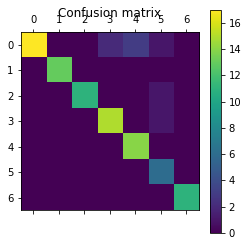

---------------------------------------------
Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] max_depth=10, max_features=14, min_samples_leaf=1 ...............
[CV]  max_depth=10, max_features=14, min_samples_leaf=1, total=   0.2s
[CV] max_depth=10, max_features=14, min_samples_leaf=1 ...............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV]  max_depth=10, max_features=14, min_samples_leaf=1, total=   0.2s
[CV] max_depth=10, max_features=14, min_samples_leaf=1 ...............
[CV]  max_depth=10, max_features=14, min_samples_leaf=1, total=   0.2s
[CV] max_depth=10, max_features=14, min_samples_leaf=1 ...............
[CV]  max_depth=10, max_features=14, min_samples_leaf=1, total=   0.2s
[CV] max_depth=10, max_features=14, min_samples_leaf=1 ...............
[CV]  max_depth=10, max_features=14, min_samples_leaf=1, total=   0.2s
[CV] max_depth=10, max_features=14, min_samples_leaf=3 ...............
[CV]  max_depth=10, max_features=14, min_samples_leaf=3, total=   0.2s
[CV] max_depth=10, max_features=14, min_samples_leaf=3 ...............
[CV]  max_depth=10, max_features=14, min_samples_leaf=3, total=   0.2s
[CV] max_depth=10, max_features=14, min_samples_leaf=3 ...............
[CV]  max_depth=10, max_features=14, min_samples_leaf=3, total=   0.2s
[CV] max_depth=10, max_features=14, min_samples_leaf=3 ...............
[CV]  

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:   13.8s finished


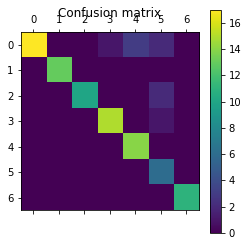

---------------------------------------------
Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] max_depth=10, max_features=14, min_samples_leaf=1 ...............
[CV]  max_depth=10, max_features=14, min_samples_leaf=1, total=   0.2s
[CV] max_depth=10, max_features=14, min_samples_leaf=1 ...............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV]  max_depth=10, max_features=14, min_samples_leaf=1, total=   0.2s
[CV] max_depth=10, max_features=14, min_samples_leaf=1 ...............
[CV]  max_depth=10, max_features=14, min_samples_leaf=1, total=   0.2s
[CV] max_depth=10, max_features=14, min_samples_leaf=1 ...............
[CV]  max_depth=10, max_features=14, min_samples_leaf=1, total=   0.2s
[CV] max_depth=10, max_features=14, min_samples_leaf=1 ...............
[CV]  max_depth=10, max_features=14, min_samples_leaf=1, total=   0.2s
[CV] max_depth=10, max_features=14, min_samples_leaf=3 ...............
[CV]  max_depth=10, max_features=14, min_samples_leaf=3, total=   0.2s
[CV] max_depth=10, max_features=14, min_samples_leaf=3 ...............
[CV]  max_depth=10, max_features=14, min_samples_leaf=3, total=   0.2s
[CV] max_depth=10, max_features=14, min_samples_leaf=3 ...............
[CV]  max_depth=10, max_features=14, min_samples_leaf=3, total=   0.2s
[CV] max_depth=10, max_features=14, min_samples_leaf=3 ...............
[CV]  

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:   13.8s finished


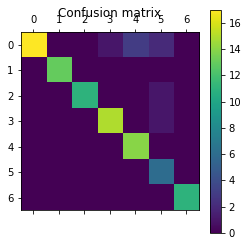

---------------------------------------------
Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] max_depth=10, max_features=14, min_samples_leaf=1 ...............
[CV]  max_depth=10, max_features=14, min_samples_leaf=1, total=   0.2s
[CV] max_depth=10, max_features=14, min_samples_leaf=1 ...............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV]  max_depth=10, max_features=14, min_samples_leaf=1, total=   0.2s
[CV] max_depth=10, max_features=14, min_samples_leaf=1 ...............
[CV]  max_depth=10, max_features=14, min_samples_leaf=1, total=   0.2s
[CV] max_depth=10, max_features=14, min_samples_leaf=1 ...............
[CV]  max_depth=10, max_features=14, min_samples_leaf=1, total=   0.2s
[CV] max_depth=10, max_features=14, min_samples_leaf=1 ...............
[CV]  max_depth=10, max_features=14, min_samples_leaf=1, total=   0.2s
[CV] max_depth=10, max_features=14, min_samples_leaf=3 ...............
[CV]  max_depth=10, max_features=14, min_samples_leaf=3, total=   0.2s
[CV] max_depth=10, max_features=14, min_samples_leaf=3 ...............
[CV]  max_depth=10, max_features=14, min_samples_leaf=3, total=   0.2s
[CV] max_depth=10, max_features=14, min_samples_leaf=3 ...............
[CV]  max_depth=10, max_features=14, min_samples_leaf=3, total=   0.2s
[CV] max_depth=10, max_features=14, min_samples_leaf=3 ...............
[CV]  

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:   13.8s finished


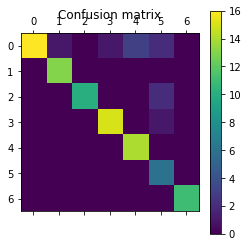

---------------------------------------------
Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] max_depth=10, max_features=14, min_samples_leaf=1 ...............
[CV]  max_depth=10, max_features=14, min_samples_leaf=1, total=   0.2s
[CV] max_depth=10, max_features=14, min_samples_leaf=1 ...............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV]  max_depth=10, max_features=14, min_samples_leaf=1, total=   0.2s
[CV] max_depth=10, max_features=14, min_samples_leaf=1 ...............
[CV]  max_depth=10, max_features=14, min_samples_leaf=1, total=   0.2s
[CV] max_depth=10, max_features=14, min_samples_leaf=1 ...............
[CV]  max_depth=10, max_features=14, min_samples_leaf=1, total=   0.2s
[CV] max_depth=10, max_features=14, min_samples_leaf=1 ...............
[CV]  max_depth=10, max_features=14, min_samples_leaf=1, total=   0.2s
[CV] max_depth=10, max_features=14, min_samples_leaf=3 ...............
[CV]  max_depth=10, max_features=14, min_samples_leaf=3, total=   0.2s
[CV] max_depth=10, max_features=14, min_samples_leaf=3 ...............
[CV]  max_depth=10, max_features=14, min_samples_leaf=3, total=   0.2s
[CV] max_depth=10, max_features=14, min_samples_leaf=3 ...............
[CV]  max_depth=10, max_features=14, min_samples_leaf=3, total=   0.2s
[CV] max_depth=10, max_features=14, min_samples_leaf=3 ...............
[CV]  

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:   13.9s finished


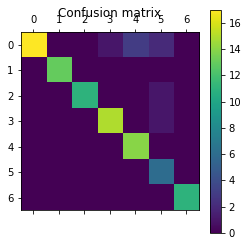

---------------------------------------------


In [ ]:
### BOUCLE
X_train=set_val_proba.drop(['image','description','catego'],axis=1)
y_train=set_val_proba['catego']

# Modélisation RFC
list_scor_stacking=[]
for i in range(1,6,1):
  n_featur = X_train.shape[1]

  param = {
      
      'max_depth' : [10,20,50], #profondeur de l'arbre
      'min_samples_leaf' : [1,3,5], #nombre de feuilles minimales dans un noeud
      'max_features': [n_featur, 'sqrt'] #nombre de features observées pour chaque arbre
      }

  rfc_stacking_val = GridSearchCV(RandomForestClassifier(),
                                param_grid = param,
                                scoring='accuracy',
                                verbose=2,
                                cv=5)

  rfc_stacking_val.fit(X_train, y_train)
  print('-'*45)
  print('best parameter :', rfc_stacking_val.best_params_)
  print('best score :', rfc_stacking_val.best_score_)


  #Prédiction sur les proba set de test
  X_cat=set_test_proba.drop(['image','description','catego'],axis=1)
  y_cat=set_test_proba['catego']

  catego_staking_test=rfc_stacking_val.predict(X_cat)

  def showconfusionmatrix(cm):
        pl.matshow(cm)
        pl.title('Confusion matrix')
        pl.colorbar()
        pl.show()

  rfc_stacking_scor = accuracy_score(y_cat, catego_staking_test)
  print("Score accuracy test = ", rfc_stacking_scor)
  cm = confusion_matrix(y_cat, catego_staking_test)
  print (cm)

  showconfusionmatrix(cm)
  print('-'*45)

  list_scor_stacking.append(rfc_stacking_scor)

#Comparaison des différentes méthodes de classification

In [ ]:
result_rfc=pd.DataFrame()
result_rfc['method']=['BoVW','MobilNetV2','BoW','TF-idf','Word2Vac','BERT','CNN+NLP','Stacking']
result_rfc['Score accurancy']=[rfc_bovw_scor,rfc_mnv2_scor,rfc_bow_scor,rfc_tfidf_scor,rfc_w2v_scor,rfc_BERT_scor,rfc_nlp_cnn_scor,rfc_stacking_scor]
result_rfc

method  Score accurancy
0        BoVW         0.368421
1  MobilNetV2         0.810526
2         BoW         0.926316
3      TF-idf         0.926316
4    Word2Vac         0.884211
5        BERT         0.000000
6     CNN+NLP         0.926316
7    Stacking         0.915789

In [ ]:
result_rfc.to_csv('result_rfc.csv')

In [ ]:
### BOUCLE
dic_result_rfc_boucle={'BoVW':list(set_bow_scor_max),
                               'MobilNetV2':rfc_mnv2_scor,
                               'BoW':rfc_bow_scor,
                               'TF-idf':rfc_tfidf_scor,
                               'Word2Vac':rfc_w2v_scor,
                               'BERT':rfc_BERT_scor,
                               'CNN+NLP':rfc_nlp_cnn_scor,
                               'Stacking':list_scor_stacking}

result_rfc=pd.DataFrame(dic_result_rfc_boucle)

In [ ]:
result_rfc_T=result_rfc.T.copy()

list_moy_scor_bow=[]
for i in range(len(result_rfc_T)):
  list_moy_scor_bow.append(result_rfc_T.iloc[i,:].mean())

result_rfc_T['moy']=list_moy_scor_bow
result_rfc_T.to_csv('result_rfc_boucle3.csv')

In [ ]:
result_rfc_T

0         1         2         3         4       moy
BoVW        0.326316  0.294737  0.242105  0.431579  0.305263  0.320000
MobilNetV2  0.810526  0.810526  0.810526  0.810526  0.810526  0.810526
BoW         0.915789  0.884211  0.915789  0.894737  0.884211  0.898947
TF-idf      0.926316  0.926316  0.915789  0.915789  0.915789  0.920000
Word2Vac    0.915789  0.894737  0.905263  0.905263  0.905263  0.905263
BERT        0.894737  0.915789  0.915789  0.905263  0.905263  0.907368
CNN+NLP     0.915789  0.905263  0.915789  0.905263  0.905263  0.909474
Stacking    0.915789  0.905263  0.915789  0.894737  0.915789  0.909474

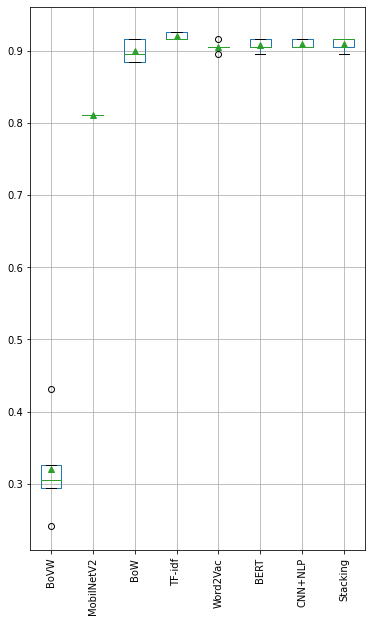

In [ ]:
plt.figure(figsize=(6, 10))
result_rfc.boxplot(labels=result_rfc.columns,rot=90, showmeans=True)